In [ ]:
!pip install -q ensemble-boxes pyyaml pandas matplotlib

In [ ]:
from google.colab import files

print("Please upload:")
print("  - preds_yolo8n_clean.json")
print("  - preds_yolo8s_clean.json")
print("  - preds_frcnn_clean.json")

uploaded = files.upload()
list(uploaded.keys())

Please upload:
  - preds_yolo8n_clean.json
  - preds_yolo8s_clean.json
  - preds_frcnn_clean.json


Saving preds_yolo8s_clean.json to preds_yolo8s_clean.json
Saving preds_yolo8n_clean.json to preds_yolo8n_clean.json
Saving preds_frcnn_clean.json to preds_frcnn_clean.json


['preds_yolo8s_clean.json',
 'preds_yolo8n_clean.json',
 'preds_frcnn_clean.json']

In [ ]:
from google.colab import files

print("Please upload:")
print("  - hardhat_yolo_data.zip")
uploaded = files.upload()
list(uploaded.keys())

Please upload:
  - hardhat_yolo_data.zip


Saving hardhat_yolo_data.zip to hardhat_yolo_data.zip


['hardhat_yolo_data.zip']

In [ ]:
import os

DATA_ROOT = os.path.abspath("data")
print("DATA_ROOT:", DATA_ROOT)
print("Contents:", os.listdir(DATA_ROOT))

DATA_ROOT: /content/data


FileNotFoundError: [Errno 2] No such file or directory: '/content/data'

In [ ]:
import os, glob

print("Current dir:", os.getcwd())
print("Files here:", os.listdir("."))

os.makedirs("preds", exist_ok=True)

# Move the three JSONs into preds/ if they exist
for fname in ["preds_yolo8n_clean.json", "preds_yolo8s_clean.json", "preds_frcnn_clean.json"]:
    if os.path.exists(fname):
        print("Moving", fname, "-> preds/" + fname)
        os.replace(fname, os.path.join("preds", fname))
    else:
        print("WARNING: not found:", fname)

print("preds/ contents:", os.listdir("preds"))

Current dir: /content
Files here: ['.config', 'preds_yolo8n_clean.json', 'preds_yolo8s_clean.json', 'preds_frcnn_clean.json', 'hardhat_yolo_data.zip', 'sample_data']
Moving preds_yolo8n_clean.json -> preds/preds_yolo8n_clean.json
Moving preds_yolo8s_clean.json -> preds/preds_yolo8s_clean.json
Moving preds_frcnn_clean.json -> preds/preds_frcnn_clean.json
preds/ contents: ['preds_yolo8n_clean.json', 'preds_yolo8s_clean.json', 'preds_frcnn_clean.json']


In [ ]:
!pip install -q ensemble-boxes pyyaml pandas matplotlib
import json
import numpy as np
import yaml
import glob
import os # Added explicit import for os
import zipfile # Added explicit import for zipfile

from ensemble_boxes import weighted_boxes_fusion

# --- paths ---
VAL_IMAGES_DIR  = os.path.join(DATA_ROOT, "val", "images")
VAL_LABELS_DIR  = os.path.join(DATA_ROOT, "val", "labels")
YAML_PATH       = os.path.join(DATA_ROOT, "data.yaml")

# --- Ensure data is unzipped if data.yaml is missing ---
if not os.path.exists(YAML_PATH):
    print(f"data.yaml not found at {YAML_PATH}. Attempting to extract hardhat_yolo_data.zip.")
    if os.path.exists("hardhat_yolo_data.zip"):
        os.makedirs(DATA_ROOT, exist_ok=True) # Ensure DATA_ROOT exists before extraction
        with zipfile.ZipFile("hardhat_yolo_data.zip", "r") as z:
            z.extractall(DATA_ROOT) # Extract contents to DATA_ROOT
        print("Extraction complete.")
    else:
        raise FileNotFoundError("hardhat_yolo_data.zip not found. Please upload it first.")


PRED_DIR        = "preds"
PREDS_N_PATH    = os.path.join(PRED_DIR, "preds_yolo8n_clean.json")
PREDS_S_PATH    = os.path.join(PRED_DIR, "preds_yolo8s_clean.json")
PREDS_R_PATH    = os.path.join(PRED_DIR, "preds_frcnn_clean.json")

print("VAL_IMAGES_DIR:", VAL_IMAGES_DIR)
print("VAL_LABELS_DIR:", VAL_LABELS_DIR)
print("Pred N:", PREDS_N_PATH)
print("Pred S:", PREDS_S_PATH)
print("Pred R:", PREDS_R_PATH)

# --- class names from data.yaml ---
with open(YAML_PATH, "r") as f:
    cfg = yaml.safe_load(f)

names_dict = cfg.get("names", {})
if isinstance(names_dict, dict):
    class_names = {int(k): v for k, v in names_dict.items()}
else:
    class_names = dict(enumerate(names_dict))

print("Class names:", class_names)


# --- helper to load prediction JSONs ---
def load_preds(path):
    with open(path, "r") as f:
        data = json.load(f)
    preds = {}
    for item in data:
        img_id = item["image_id"]
        preds[img_id] = {
            "boxes":  np.array(item["boxes"],  dtype=np.float32),
            "scores": np.array(item["scores"], dtype=np.float32),
            "labels": np.array(item["labels"], dtype=np.int64),
            "height": int(item["height"]),
            "width":  int(item["width"]),
        }
    return preds

preds_n = load_preds(PREDS_N_PATH)
preds_s = load_preds(PREDS_S_PATH)
preds_r = load_preds(PREDS_R_PATH)   # Faster R-CNN

print("Loaded images: N =", len(preds_n), " S =", len(preds_s), " R =", len(preds_r))


# --- load ground-truth from YOLO txt labels ---
def load_ground_truth(val_labels_dir, preds_reference):
    gts = {}
    for img_id, p in preds_reference.items():
        stem = os.path.splitext(img_id)[0]
        label_path = os.path.join(val_labels_dir, stem + ".txt")
        h, w = p["height"], p["width"]

        boxes, labels = [], []

        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) != 5:
                        continue
                    cls = int(float(parts[0]))
                    cx  = float(parts[1]) * w
                    cy  = float(parts[2]) * h
                    bw  = float(parts[3]) * w
                    bh  = float(parts[4]) * h
                    x1 = cx - bw / 2
                    y1 = cy - bh / 2
                    x2 = cx + bw / 2
                    y2 = cy + bh / 2
                    boxes.append([x1, y1, x2, y2])
                    labels.append(cls)

        gts[img_id] = {
            "boxes":  np.array(boxes,  dtype=np.float32),
            "labels": np.array(labels, dtype=np.int64),
            "height": h,
            "width":  w,
        }

    print("Loaded GT for", len(gts), "images")
    return gts

gts = load_ground_truth(VAL_LABELS_DIR, preds_n)
class_ids = sorted(class_names.keys())


data.yaml not found at /content/data/data.yaml. Attempting to extract hardhat_yolo_data.zip.
Extraction complete.
VAL_IMAGES_DIR: /content/data/val/images
VAL_LABELS_DIR: /content/data/val/labels
Pred N: preds/preds_yolo8n_clean.json
Pred S: preds/preds_yolo8s_clean.json
Pred R: preds/preds_frcnn_clean.json
Class names: {0: 'head', 1: 'helmet', 2: 'person'}
Loaded images: N = 1000  S = 1000  R = 1000
Loaded GT for 1000 images


In [ ]:
import numpy as np

# --- IoU for xyxy boxes ---
def box_iou_xyxy(boxes1, boxes2):
    """
    boxes1: [N,4], boxes2: [M,4]
    returns IoU matrix [N,M]
    """
    if boxes1.size == 0 or boxes2.size == 0:
        return np.zeros((boxes1.shape[0], boxes2.shape[0]), dtype=np.float32)

    b1 = boxes1
    b2 = boxes2

    area1 = np.clip(b1[:, 2] - b1[:, 0], 0, None) * np.clip(b1[:, 3] - b1[:, 1], 0, None)
    area2 = np.clip(b2[:, 2] - b2[:, 0], 0, None) * np.clip(b2[:, 3] - b2[:, 1], 0, None)

    inter_x1 = np.maximum(b1[:, None, 0], b2[None, :, 0])
    inter_y1 = np.maximum(b1[:, None, 1], b2[None, :, 1])
    inter_x2 = np.minimum(b1[:, None, 2], b2[None, :, 2])
    inter_y2 = np.minimum(b1[:, None, 3], b2[None, :, 3])

    inter_w = np.clip(inter_x2 - inter_x1, 0, None)
    inter_h = np.clip(inter_y2 - inter_y1, 0, None)
    inter_area = inter_w * inter_h

    union = area1[:, None] + area2[None, :] - inter_area
    iou = np.where(union > 0, inter_area / union, 0.0)
    return iou


# --- AP from precision/recall curve (VOC-style, continuous) ---
def compute_ap(recall, precision):
    mrec = np.concatenate(([0.0], recall, [1.0]))
    mpre = np.concatenate(([0.0], precision, [0.0]))

    # make precision monotonically decreasing
    for i in range(mpre.size - 1, 0, -1):
        mpre[i-1] = np.maximum(mpre[i-1], mpre[i])

    idx = np.where(mrec[1:] != mrec[:-1])[0]
    ap = np.sum((mrec[idx + 1] - mrec[idx]) * mpre[idx + 1])
    return ap


# --- main evaluation function ---
def evaluate_predictions(preds, gts, class_ids, iou_thr=0.5, score_thr_for_stats=0.5):
    aps = {}
    per_class_stats = {}

    for cls in class_ids:
        # gather GT for this class
        gt_per_image = {}
        gt_count = 0
        for img_id, g in gts.items():
            mask = (g["labels"] == cls)
            boxes_cls = g["boxes"][mask]
            gt_per_image[img_id] = {
                "boxes": boxes_cls,
                "matched": np.zeros(len(boxes_cls), dtype=bool)
            }
            gt_count += len(boxes_cls)

        # gather predictions for this class
        dets = []  # list of (img_id, score, box)
        for img_id, p in preds.items():
            mask = (p["labels"] == cls)
            boxes_cls = p["boxes"][mask]
            scores_cls = p["scores"][mask]
            for b, s in zip(boxes_cls, scores_cls):
                dets.append((img_id, float(s), b))

        if gt_count == 0:
            aps[cls] = np.nan
            per_class_stats[cls] = {"precision": np.nan, "recall": np.nan, "f1": np.nan}
            continue

        if not dets:
            aps[cls] = 0.0
            per_class_stats[cls] = {"precision": 0.0, "recall": 0.0, "f1": 0.0}
            continue

        # sort detections by descending score
        dets.sort(key=lambda x: x[1], reverse=True)
        tp = np.zeros(len(dets))
        fp = np.zeros(len(dets))

        # compute TP/FP for AP
        for i, (img_id, score, box) in enumerate(dets):
            gt_info = gt_per_image[img_id]
            gt_boxes = gt_info["boxes"]
            if gt_boxes.size == 0:
                fp[i] = 1
                continue

            ious = box_iou_xyxy(np.expand_dims(box, 0), gt_boxes)[0]
            best_idx = np.argmax(ious)
            if ious[best_idx] >= iou_thr and not gt_info["matched"][best_idx]:
                tp[i] = 1
                gt_info["matched"][best_idx] = True
            else:
                fp[i] = 1

        cum_tp = np.cumsum(tp)
        cum_fp = np.cumsum(fp)
        recalls = cum_tp / gt_count
        precisions = cum_tp / np.maximum(cum_tp + cum_fp, 1e-9)

        ap = compute_ap(recalls, precisions)
        aps[cls] = ap

        # --- stats at score >= score_thr_for_stats & IoU >= iou_thr ---
        for img_id in gt_per_image:
            gt_per_image[img_id]["matched"][:] = False

        tp_c = 0
        fp_c = 0
        for img_id, score, box in dets:
            if score < score_thr_for_stats:
                continue
            gt_info = gt_per_image[img_id]
            gt_boxes = gt_info["boxes"]
            if gt_boxes.size == 0:
                fp_c += 1
                continue
            ious = box_iou_xyxy(np.expand_dims(box, 0), gt_boxes)[0]
            best_idx = np.argmax(ious)
            if ious[best_idx] >= iou_thr and not gt_info["matched"][best_idx]:
                tp_c += 1
                gt_info["matched"][best_idx] = True
            else:
                fp_c += 1

        fn_c = gt_count - tp_c
        prec = tp_c / (tp_c + fp_c) if (tp_c + fp_c) > 0 else 0.0
        rec  = tp_c / gt_count if gt_count > 0 else 0.0
        f1   = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0.0

        per_class_stats[cls] = {"precision": prec, "recall": rec, "f1": f1}

    valid_aps = [v for v in aps.values() if not np.isnan(v)]
    mAP = float(np.mean(valid_aps)) if valid_aps else float("nan")
    return aps, mAP, per_class_stats


def pretty_print_results(name, aps, mAP, stats, class_names):
    print(f"\n=== {name} (IoU=0.5) ===")
    print("Class ID | Class Name | AP")
    print("---------------------------")
    for cid, ap in aps.items():
        cname = class_names.get(cid, str(cid))
        print(f"{cid:7d} | {cname:10s} | {ap:0.4f}")
    print(f"\nFinal mAP@0.5: {mAP:.4f}\n")

    print("Score >= 0.5 and IoU >= 0.5:")
    print("Class Name     | Precision | Recall   | F1-Score")
    print("------------------------------------------------")
    for cid, st in stats.items():
        cname = class_names.get(cid, str(cid))
        print(f"{cname:13s} | {st['precision']:.4f}   | {st['recall']:.4f} | {st['f1']:.4f}")
    mean_prec = np.nanmean([st["precision"] for st in stats.values()])
    mean_rec  = np.nanmean([st["recall"]   for st in stats.values()])
    mean_f1   = np.nanmean([st["f1"]       for st in stats.values()])
    print("------------------------------------------------")
    print(f"MEAN           | {mean_prec:.4f}   | {mean_rec:.4f} | {mean_f1:.4f}")

In [ ]:
class_ids = sorted(class_names.keys())

aps_n, mAP_n, stats_n = evaluate_predictions(preds_n, gts, class_ids, iou_thr=0.5)
aps_s, mAP_s, stats_s = evaluate_predictions(preds_s, gts, class_ids, iou_thr=0.5)
aps_r, mAP_r, stats_r = evaluate_predictions(preds_r, gts, class_ids, iou_thr=0.5)

pretty_print_results("YOLOv8n", aps_n, mAP_n, stats_n, class_names)
pretty_print_results("YOLOv8s", aps_s, mAP_s, stats_s, class_names)
pretty_print_results("Faster R-CNN", aps_r, mAP_r, stats_r, class_names)


=== YOLOv8n (IoU=0.5) ===
Class ID | Class Name | AP
---------------------------
      0 | head       | 0.9151
      1 | helmet     | 0.9541
      2 | person     | 0.0239

Final mAP@0.5: 0.6310

Score >= 0.5 and IoU >= 0.5:
Class Name     | Precision | Recall   | F1-Score
------------------------------------------------
head          | 0.9114   | 0.8590 | 0.8844
helmet        | 0.9685   | 0.8668 | 0.9148
person        | 0.0000   | 0.0000 | 0.0000
------------------------------------------------
MEAN           | 0.6266   | 0.5753 | 0.5997

=== YOLOv8s (IoU=0.5) ===
Class ID | Class Name | AP
---------------------------
      0 | head       | 0.9204
      1 | helmet     | 0.9611
      2 | person     | 0.0184

Final mAP@0.5: 0.6333

Score >= 0.5 and IoU >= 0.5:
Class Name     | Precision | Recall   | F1-Score
------------------------------------------------
head          | 0.9107   | 0.8790 | 0.8946
helmet        | 0.9549   | 0.9014 | 0.9274
person        | 0.0000   | 0.0000 | 0.0000
---

In [ ]:
# --- generic WBF fusion for N models ---
def fuse_models_wbf(preds_list, weights=None, iou_thr=0.55, skip_box_thr=0.001):
    """
    preds_list: [preds_model1, preds_model2, ...]
    each preds_*: dict[image_id] -> {boxes,scores,labels,height,width}
    """
    num_models = len(preds_list)
    if weights is None:
        weights = [1.0] * num_models

    fused = {}
    image_ids = preds_list[0].keys()

    for img_id in image_ids:
        h = preds_list[0][img_id]["height"]
        w = preds_list[0][img_id]["width"]

        all_boxes  = []
        all_scores = []
        all_labels = []

        for preds in preds_list:
            p = preds[img_id]
            boxes  = p["boxes"]
            scores = p["scores"]
            labels = p["labels"]

            if boxes.size == 0:
                all_boxes.append([])
                all_scores.append([])
                all_labels.append([])
            else:
                norm_boxes = boxes.copy()
                norm_boxes[:, 0] /= w
                norm_boxes[:, 2] /= w
                norm_boxes[:, 1] /= h
                norm_boxes[:, 3] /= h
                all_boxes.append(norm_boxes.tolist())
                all_scores.append(scores.tolist())
                all_labels.append(labels.tolist())

        if sum(len(b) for b in all_boxes) == 0:
            fused[img_id] = {
                "boxes":  np.zeros((0, 4), dtype=np.float32),
                "scores": np.zeros((0,),   dtype=np.float32),
                "labels": np.zeros((0,),   dtype=np.int64),
                "height": h,
                "width":  w,
            }
            continue

        fb, fs, fl = weighted_boxes_fusion(
            all_boxes, all_scores, all_labels,
            weights=weights,
            iou_thr=iou_thr,
            skip_box_thr=skip_box_thr
        )

        fb = np.array(fb, dtype=np.float32)
        fs = np.array(fs, dtype=np.float32)
        fl = np.array(fl, dtype=np.int64)

        # back to absolute pixel coords
        fb[:, 0] *= w
        fb[:, 2] *= w
        fb[:, 1] *= h
        fb[:, 3] *= h

        fused[img_id] = {
            "boxes":  fb,
            "scores": fs,
            "labels": fl,
            "height": h,
            "width":  w,
        }

    return fused


# --- 2-model voter: YOLOv8n + YOLOv8s ---
fused_2 = fuse_models_wbf(
    [preds_n, preds_s],
    weights=[1.0, 1.0],
    iou_thr=0.55,
    skip_box_thr=0.001
)

aps_f2, mAP_f2, stats_f2 = evaluate_predictions(fused_2, gts, class_ids, iou_thr=0.5)
pretty_print_results("WBF (YOLOv8n + YOLOv8s)", aps_f2, mAP_f2, stats_f2, class_names)


# --- 3-model voter: YOLOv8n + YOLOv8s + Faster R-CNN ---
fused_3 = fuse_models_wbf(
    [preds_n, preds_s, preds_r],
    weights=[1.0, 1.0, 1.0],
    iou_thr=0.55,
    skip_box_thr=0.001
)

aps_f3, mAP_f3, stats_f3 = evaluate_predictions(fused_3, gts, class_ids, iou_thr=0.5)
pretty_print_results("WBF (YOLOv8n + YOLOv8s + FRCNN)", aps_f3, mAP_f3, stats_f3, class_names)


=== WBF (YOLOv8n + YOLOv8s) (IoU=0.5) ===
Class ID | Class Name | AP
---------------------------
      0 | head       | 0.9229
      1 | helmet     | 0.9642
      2 | person     | 0.0317

Final mAP@0.5: 0.6396

Score >= 0.5 and IoU >= 0.5:
Class Name     | Precision | Recall   | F1-Score
------------------------------------------------
head          | 0.9459   | 0.7311 | 0.8247
helmet        | 0.9874   | 0.7482 | 0.8513
person        | 0.0000   | 0.0000 | 0.0000
------------------------------------------------
MEAN           | 0.6444   | 0.4931 | 0.5587

=== WBF (YOLOv8n + YOLOv8s + FRCNN) (IoU=0.5) ===
Class ID | Class Name | AP
---------------------------
      0 | head       | 0.9203
      1 | helmet     | 0.9501
      2 | person     | 0.0299

Final mAP@0.5: 0.6335

Score >= 0.5 and IoU >= 0.5:
Class Name     | Precision | Recall   | F1-Score
------------------------------------------------
head          | 0.9485   | 0.7215 | 0.8196
helmet        | 0.9828   | 0.7890 | 0.8753
person

In [ ]:
import pandas as pd

# Collect mAP and mean precision/recall/F1 for each system
summary_rows = []

def row_from_results(name, mAP, stats):
    mean_prec = np.nanmean([st["precision"] for st in stats.values()])
    mean_rec  = np.nanmean([st["recall"]   for st in stats.values()])
    mean_f1   = np.nanmean([st["f1"]       for st in stats.values()])
    return {
        "model": name,
        "mAP@0.5": mAP,
        "mean_precision": mean_prec,
        "mean_recall": mean_rec,
        "mean_f1": mean_f1,
    }

summary_rows.append(row_from_results("YOLOv8n", mAP_n, stats_n))
summary_rows.append(row_from_results("YOLOv8s", mAP_s, stats_s))
summary_rows.append(row_from_results("Faster R-CNN", mAP_r, stats_r))
summary_rows.append(row_from_results("WBF(n+s)", mAP_f2, stats_f2))
summary_rows.append(row_from_results("WBF(n+s+FRCNN)", mAP_f3, stats_f3))

df_summary = pd.DataFrame(summary_rows)
print(df_summary)

df_summary.to_csv("metrics_map_summary_nversion.csv", index=False)
print("\nSaved metrics_map_summary_nversion.csv")

            model   mAP@0.5  mean_precision  mean_recall   mean_f1
0         YOLOv8n  0.631036        0.626627     0.575256  0.599743
1         YOLOv8s  0.633305        0.621890     0.593478  0.607333
2    Faster R-CNN  0.545004        0.508037     0.525289  0.513537
3        WBF(n+s)  0.639591        0.644436     0.493080  0.558675
4  WBF(n+s+FRCNN)  0.633466        0.643773     0.503504  0.564962

Saved metrics_map_summary_nversion.csv


In [ ]:
rows = []
for cid in class_ids:
    cname = class_names[cid]
    rows.append({
        "class_id": cid,
        "class_name": cname,
        "AP_YOLOv8n": aps_n[cid],
        "AP_YOLOv8s": aps_s[cid],
        "AP_FRCNN": aps_r[cid],
        "AP_WBF_2": aps_f2[cid],
        "AP_WBF_3": aps_f3[cid],
        "Prec_n":  stats_n[cid]["precision"],
        "Rec_n":   stats_n[cid]["recall"],
        "F1_n":    stats_n[cid]["f1"],
        "Prec_s":  stats_s[cid]["precision"],
        "Rec_s":   stats_s[cid]["recall"],
        "F1_s":    stats_s[cid]["f1"],
        "Prec_r":  stats_r[cid]["precision"],
        "Rec_r":   stats_r[cid]["recall"],
        "F1_r":    stats_r[cid]["f1"],
        "Prec_f2": stats_f2[cid]["precision"],
        "Rec_f2":  stats_f2[cid]["recall"],
        "F1_f2":   stats_f2[cid]["f1"],
        "Prec_f3": stats_f3[cid]["precision"],
        "Rec_f3":  stats_f3[cid]["recall"],
        "F1_f3":   stats_f3[cid]["f1"],
    })

df_per_class = pd.DataFrame(rows)
print(df_per_class)

df_per_class.to_csv("metrics_per_class_nversion.csv", index=False)
print("\nSaved metrics_per_class_nversion.csv")

   class_id class_name  AP_YOLOv8n  AP_YOLOv8s  AP_FRCNN  AP_WBF_2  AP_WBF_3  \
0         0       head    0.915127    0.920388  0.777491  0.922872  0.920344   
1         1     helmet    0.954107    0.961084  0.857184  0.964245  0.950117   
2         2     person    0.023875    0.018444  0.000339  0.031655  0.029936   

     Prec_n     Rec_n      F1_n  ...      F1_s    Prec_r     Rec_r      F1_r  \
0  0.911357  0.859008  0.884409  ...  0.894597  0.804326  0.711923  0.755309   
1  0.968524  0.866761  0.914821  ...  0.927402  0.719784  0.863944  0.785303   
2  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   

    Prec_f2    Rec_f2     F1_f2   Prec_f3    Rec_f3     F1_f3  
0  0.945946  0.731070  0.824742  0.948513  0.721497  0.819575  
1  0.987361  0.748169  0.851282  0.982807  0.789014  0.875312  
2  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  

[3 rows x 22 columns]

Saved metrics_per_class_nversion.csv


In [ ]:
import pandas as pd


iou_values = [0.45, 0.50, 0.55, 0.60, 0.65]
skip_box_thr = 0.001

rows = []

for iou_thr in iou_values:
    # 2-model WBF (YOLOv8n + YOLOv8s)
    fused_2 = fuse_models_wbf(
        [preds_n, preds_s],
        weights=[1.0, 1.0],
        iou_thr=iou_thr,
        skip_box_thr=skip_box_thr,
    )
    aps_2, mAP_2, stats_2 = evaluate_predictions(
        fused_2, gts, class_ids, iou_thr=0.5
    )

    # 3-model WBF (YOLOv8n + YOLOv8s + FRCNN)
    fused_3 = fuse_models_wbf(
        [preds_n, preds_s, preds_r],
        weights=[1.0, 1.0, 1.0],
        iou_thr=iou_thr,
        skip_box_thr=skip_box_thr,
    )
    aps_3, mAP_3, stats_3 = evaluate_predictions(
        fused_3, gts, class_ids, iou_thr=0.5
    )

    rows.append({
        "iou_thr_WBF": iou_thr,
        "mAP@0.5_WBF_2models": mAP_2,
        "mAP@0.5_WBF_3models": mAP_3,
    })

# Put into a DataFrame for easy plotting / reporting
df_iou = pd.DataFrame(rows)
print(df_iou)

# Save to CSV so you can download/use in slides
df_iou.to_csv("wbf_iou_sweep_clean.csv", index=False)
print("\nSaved wbf_iou_sweep_clean.csv")

   iou_thr_WBF  mAP@0.5_WBF_2models  mAP@0.5_WBF_3models
0         0.45             0.639922             0.629297
1         0.50             0.640151             0.632186
2         0.55             0.639591             0.633466
3         0.60             0.639386             0.634690
4         0.65             0.639768             0.635072

Saved wbf_iou_sweep_clean.csv


   iou_thr_WBF  mAP@0.5_WBF_2models  mAP@0.5_WBF_3models
0         0.45             0.639922             0.629297
1         0.50             0.640151             0.632186
2         0.55             0.639591             0.633466
3         0.60             0.639386             0.634690
4         0.65             0.639768             0.635072


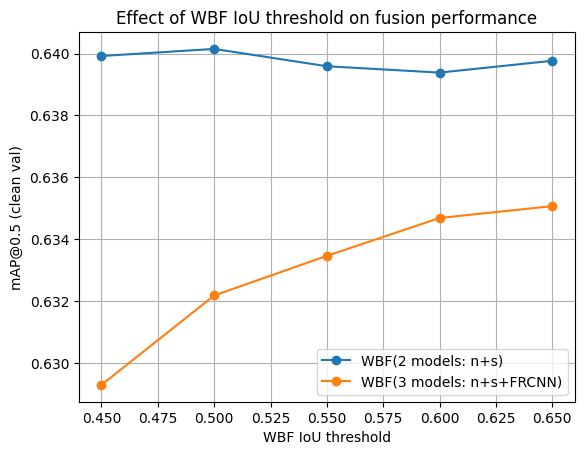

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df_iou = pd.read_csv("wbf_iou_sweep_clean.csv")
print(df_iou)

plt.figure()
plt.plot(df_iou["iou_thr_WBF"], df_iou["mAP@0.5_WBF_2models"], marker="o", label="WBF(2 models: n+s)")
plt.plot(df_iou["iou_thr_WBF"], df_iou["mAP@0.5_WBF_3models"], marker="o", label="WBF(3 models: n+s+FRCNN)")
plt.xlabel("WBF IoU threshold")
plt.ylabel("mAP@0.5 (clean val)")
plt.title("Effect of WBF IoU threshold on fusion performance")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
SEEDS = [0, 1, 42]
MODELS = ["yolov8n", "yolov8s"]

In [ ]:
!pip -q install torch==2.4.0 torchvision==0.19.0 --index-url https://download.pytorch.org/whl/cu118
!pip -q install ultralytics==8.0.196 opencv-python

import os, glob, yaml, cv2, json, random
import numpy as np
import torch
from ultralytics import YOLO

# If you have hardhat_yolo_data.zip, unzip it:
if not os.path.exists("data/val"):
    import zipfile
    with zipfile.ZipFile("hardhat_yolo_data.zip", "r") as z:
        z.extractall("data")

DATA_ROOT = os.path.abspath("data")
YAML_PATH = os.path.join(DATA_ROOT, "data.yaml")
TRAIN_IMAGES_DIR = os.path.join(DATA_ROOT, "train", "images")
VAL_IMAGES_DIR   = os.path.join(DATA_ROOT, "val", "images")

print("DATA_ROOT:", DATA_ROOT)
print("YAML_PATH:", YAML_PATH)
print("Train images:", len(glob.glob(os.path.join(TRAIN_IMAGES_DIR, "*"))))
print("Val images:", len(glob.glob(os.path.join(VAL_IMAGES_DIR, "*"))))

RUNS_DIR  = "runs_multi_seed"
PRED_DIR  = "preds_multi_seed"
os.makedirs(PRED_DIR, exist_ok=True)

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

DATA_ROOT: /content/data
YAML_PATH: /content/data/data.yaml
Train images: 4000
Val images: 1000


In [ ]:
def run_inference_and_save(model: YOLO, images_dir: str, out_json_path: str,
                           conf_threshold: float = 0.001, imgsz: int = 640):
    image_paths = sorted(
        glob.glob(os.path.join(images_dir, "*.jpg")) +
        glob.glob(os.path.join(images_dir, "*.jpeg")) +
        glob.glob(os.path.join(images_dir, "*.png"))
    )

    all_preds = []

    for img_path in image_paths:
        img = cv2.imread(img_path)
        if img is None:
            print(f"[WARN] Could not read {img_path}, skipping.")
            continue

        h, w = img.shape[:2]
        results = model(
            img,
            imgsz=imgsz,
            conf=conf_threshold,
            verbose=False
        )[0]

        boxes_xyxy = results.boxes.xyxy.cpu().numpy().tolist()
        scores = results.boxes.conf.cpu().numpy().tolist()
        labels = results.boxes.cls.cpu().numpy().astype(int).tolist()

        all_preds.append({
            "image_id": os.path.basename(img_path),
            "height": h,
            "width":  w,
            "boxes":  boxes_xyxy,
            "scores": scores,
            "labels": labels
        })

    with open(out_json_path, "w") as f:
        json.dump(all_preds, f, indent=2)

    print(f"Saved {len(all_preds)} predictions to {out_json_path}")

In [ ]:
import os, yaml, glob

# Where we unzipped the dataset
DATA_ROOT = os.path.abspath("data")
yaml_path = os.path.join(DATA_ROOT, "data.yaml")

print("DATA_ROOT:", DATA_ROOT)
print("yaml_path:", yaml_path)
print("data/ contents:", os.listdir(DATA_ROOT))

# Rewrite YAML so that:
#   path: /content/data
#   train: train/images
#   val:   val/images
with open(yaml_path, "r") as f:
    cfg = yaml.safe_load(f)

cfg["path"] = DATA_ROOT
cfg["train"] = "train/images"
cfg["val"]   = "val/images"

with open(yaml_path, "w") as f:
    yaml.safe_dump(cfg, f)

print("\nRewritten data.yaml:")
print(cfg)

# Quick sanity check
train_imgs = glob.glob(os.path.join(DATA_ROOT, "train", "images", "*"))
val_imgs   = glob.glob(os.path.join(DATA_ROOT, "val", "images", "*"))
print(f"\n# train images: {len(train_imgs)}")
print(f"# val images:   {len(val_imgs)}")

DATA_ROOT: /content/data
yaml_path: /content/data/data.yaml
data/ contents: ['train', 'data.yaml', 'val']

Rewritten data.yaml:
{'names': {0: 'head', 1: 'helmet', 2: 'person'}, 'path': '/content/data', 'train': 'train/images', 'val': 'val/images'}

# train images: 4000
# val images:   1000


In [ ]:
import os
os.environ["WANDB_MODE"] = "disabled"
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
import os, glob, torch
from ultralytics import YOLO

# seeds and models
SEEDS = [0, 1, 42]
MODELS = {
    "yolov8n": "yolov8n.pt",
    "yolov8s": "yolov8s.pt",
}

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
print("YAML_PATH:", YAML_PATH)
print("RUNS_DIR:", RUNS_DIR)
print("PRED_DIR:", PRED_DIR)
print("VAL_IMAGES_DIR:", VAL_IMAGES_DIR)

for seed in SEEDS:
    print("\n==============================")
    print(f"=== Training models for seed {seed} ===")
    print("==============================\n")
    set_seed(seed)

    for model_name, weights in MODELS.items():
        run_name = f"{model_name}_seed{seed}"
        print(f"\n-- Training {model_name} with seed={seed} (run_name={run_name}) --")

        model = YOLO(weights)

        results = model.train(
            data=YAML_PATH,
            project=RUNS_DIR,
            name=run_name,
            epochs=25,
            imgsz=640,
            batch=16,
            seed=seed,
            workers=2,
            optimizer="SGD",
            verbose=True,
        )

        # --- find the *actual* run directory (handles suffixes like _seed02) ---
        pattern = os.path.join(RUNS_DIR, f"{run_name}*")
        candidates = sorted(
            d for d in glob.glob(pattern)
            if os.path.isdir(d)
        )
        assert candidates, f"No run dir found for pattern: {pattern}"
        run_dir = candidates[-1]   # pick the last / newest
        best_weights = os.path.join(run_dir, "weights", "best.pt")

        print(f"Using best weights from: {best_weights}")

        # reload best weights for inference
        model_best = YOLO(best_weights).to(device)

        # output JSON path
        out_json = os.path.join(
            PRED_DIR,
            f"preds_{model_name}_seed{seed}.json"
        )
        run_inference_and_save(model_best, VAL_IMAGES_DIR, out_json)

print("\nAll seeds done. Prediction JSONs are in:", PRED_DIR)

New https://pypi.org/project/ultralytics/8.3.237 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.196 🚀 Python-3.12.12 torch-2.4.0+cu118 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/data/data.yaml, epochs=25, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=2, project=runs_multi_seed, name=yolov8n_seed0, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visua

Using device: cuda
YAML_PATH: /content/data/data.yaml
RUNS_DIR: runs_multi_seed
PRED_DIR: preds_multi_seed
VAL_IMAGES_DIR: /content/data/val/images

=== Training models for seed 0 ===


-- Training yolov8n with seed=0 (run_name=yolov8n_seed0) --


Model summary: 225 layers, 3011433 parameters, 3011417 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
TensorBoard: Start with 'tensorboard --logdir runs_multi_seed/yolov8n_seed03', view at http://localhost:6006/


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅
train: Scanning /content/data/train/labels.cache... 4000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4000/4000 [00:00<?, ?it/s]
/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:805: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0)]  # transforms
/usr/local/lib/python3.12/dist-packages/albumentations/core/composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Scanning /content/data/val/labels.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]

lr/pg0,█▅▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
lr/pg1,▃▆███▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▁▁
lr/pg2,▃▆███▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▁▁
metrics/mAP50(B),▂▃▃▁▃▁▄▆▆▆▆▆▆▇▇▇▇▇▇█▇████
metrics/mAP50-95(B),▂▂▂▁▂▁▄▅▅▅▅▆▆▆▇▆▇▇▇▇▇████
metrics/precision(B),▇▇▇▇▇▇▇▇████████████▁████
metrics/recall(B),▁▃▃▂▂▁▄▅▅▅▆▆▅▆▆▆▆▇▇▇█▇▇██
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
+6,...


Using best weights from: runs_multi_seed/yolov8n_seed03/weights/best.pt


Saved 1000 predictions to preds_multi_seed/preds_yolov8n_seed0.json

-- Training yolov8s with seed=0 (run_name=yolov8s_seed0) --


100%|██████████| 21.5M/21.5M [00:00<00:00, 43.3MB/s]
New https://pypi.org/project/ultralytics/8.3.237 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.196 🚀 Python-3.12.12 torch-2.4.0+cu118 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/data/data.yaml, epochs=25, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=2, project=runs_multi_seed, name=yolov8s_seed0, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_

Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅
train: Scanning /content/data/train/labels.cache... 4000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4000/4000 [00:00<?, ?it/s]
/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:805: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0)]  # transforms
/usr/local/lib/python3.12/dist-packages/albumentations/core/composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Scanning /content/data/val/labels.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]

lr/pg0,█▅▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
lr/pg1,▃▆███▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▁▁
lr/pg2,▃▆███▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▁▁
metrics/mAP50(B),▂▂▂▁▂▂▄▆▆▆▆▆▇▆▇█▇████████
metrics/mAP50-95(B),▂▁▂▂▁▁▃▅▆▅▅▆▆▆▇▇▇▇▇▇▇████
metrics/precision(B),▇▇▇▇▇▇█▇███████████▁▁▁▁▁▁
metrics/recall(B),▂▁▂▂▁▂▃▄▅▅▅▅▅▅▆▆▆▆▆▇█▆▆▇▆
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
+6,...


Using best weights from: runs_multi_seed/yolov8s_seed0/weights/best.pt


New https://pypi.org/project/ultralytics/8.3.237 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.196 🚀 Python-3.12.12 torch-2.4.0+cu118 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/data/data.yaml, epochs=25, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=2, project=runs_multi_seed, name=yolov8n_seed1, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=1, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visua

Saved 1000 predictions to preds_multi_seed/preds_yolov8s_seed0.json

=== Training models for seed 1 ===


-- Training yolov8n with seed=1 (run_name=yolov8n_seed1) --


Model summary: 225 layers, 3011433 parameters, 3011417 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
TensorBoard: Start with 'tensorboard --logdir runs_multi_seed/yolov8n_seed1', view at http://localhost:6006/


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅
train: Scanning /content/data/train/labels.cache... 4000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4000/4000 [00:00<?, ?it/s]
/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:805: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0)]  # transforms
/usr/local/lib/python3.12/dist-packages/albumentations/core/composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Scanning /content/data/val/labels.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]

lr/pg0,█▅▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
lr/pg1,▃▆███▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▁▁
lr/pg2,▃▆███▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▁▁
metrics/mAP50(B),▂▁▃▄▄▄▄▅▆▆▆▇▇▇▇▇▇████▇███
metrics/mAP50-95(B),▂▁▂▃▃▄▄▅▅▆▅▆▆▆▇▇▇█▇▇█▇███
metrics/precision(B),▁▁▂▂▄▄▃▆▅▆▆▆▆▆▆▆▇▇▇▆▇▇▇▇█
metrics/recall(B),▃▁▄▄▃▅▅▅▆▆▅▇▇▇▆▇▇▇▇▇▇▇▇█▇
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
+6,...


Using best weights from: runs_multi_seed/yolov8n_seed1/weights/best.pt


New https://pypi.org/project/ultralytics/8.3.237 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.196 🚀 Python-3.12.12 torch-2.4.0+cu118 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/data/data.yaml, epochs=25, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=2, project=runs_multi_seed, name=yolov8s_seed1, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=1, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visua

Saved 1000 predictions to preds_multi_seed/preds_yolov8n_seed1.json

-- Training yolov8s with seed=1 (run_name=yolov8s_seed1) --


 19                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
 20             [-1, 9]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 21                  -1  1   1969152  ultralytics.nn.modules.block.C2f             [768, 512, 1]                 
 22        [15, 18, 21]  1   2117209  ultralytics.nn.modules.head.Detect           [3, [128, 256, 512]]          
Model summary: 225 layers, 11136761 parameters, 11136745 gradients, 28.7 GFLOPs

Transferred 349/355 items from pretrained weights
TensorBoard: Start with 'tensorboard --logdir runs_multi_seed/yolov8s_seed1', view at http://localhost:6006/


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅
train: Scanning /content/data/train/labels.cache... 4000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4000/4000 [00:00<?, ?it/s]
/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:805: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0)]  # transforms
/usr/local/lib/python3.12/dist-packages/albumentations/core/composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Scanning /content/data/val/labels.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]

lr/pg0,█▅▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
lr/pg1,▃▆███▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▁▁
lr/pg2,▃▆███▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▁▁
metrics/mAP50(B),▁▂▃▂▃▄▄▄▆▆▇▇▇▇▇▇▇████████
metrics/mAP50-95(B),▁▁▂▂▂▃▃▄▅▅▆▆▆▆▇▇▇▇▇▇█████
metrics/precision(B),▇█▇▇▇█▇█████████████▁▁▁▁▁
metrics/recall(B),▃▁▄▃▃▄▄▄▅▅▆▆▆▆▇▇▆▇▇▇█▇▇▇▇
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
+6,...


Using best weights from: runs_multi_seed/yolov8s_seed1/weights/best.pt


New https://pypi.org/project/ultralytics/8.3.237 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.196 🚀 Python-3.12.12 torch-2.4.0+cu118 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/data/data.yaml, epochs=25, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=2, project=runs_multi_seed, name=yolov8n_seed42, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, vis

Saved 1000 predictions to preds_multi_seed/preds_yolov8s_seed1.json

=== Training models for seed 42 ===


-- Training yolov8n with seed=42 (run_name=yolov8n_seed42) --


Model summary: 225 layers, 3011433 parameters, 3011417 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
TensorBoard: Start with 'tensorboard --logdir runs_multi_seed/yolov8n_seed42', view at http://localhost:6006/


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅
train: Scanning /content/data/train/labels.cache... 4000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4000/4000 [00:00<?, ?it/s]
/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:805: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0)]  # transforms
/usr/local/lib/python3.12/dist-packages/albumentations/core/composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Scanning /content/data/val/labels.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]

lr/pg0,█▅▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
lr/pg1,▃▆███▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▁▁
lr/pg2,▃▆███▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▁▁
metrics/mAP50(B),▃▄▁▄▄▅▅▅▆▆▇▇▇▇▇▇▇▇▇█▇████
metrics/mAP50-95(B),▂▃▁▃▄▅▅▅▆▆▆▆▇▆▇▇▇▇▇▇▇████
metrics/precision(B),▇▇▇▇▇▇████████████████▁▄▄
metrics/recall(B),▃▄▁▄▃▅▅▅▅▆▆▆▆▇▇▆▇▇▇▇▇▇▇██
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
+6,...


Using best weights from: runs_multi_seed/yolov8n_seed42/weights/best.pt


New https://pypi.org/project/ultralytics/8.3.237 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.196 🚀 Python-3.12.12 torch-2.4.0+cu118 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/data/data.yaml, epochs=25, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=2, project=runs_multi_seed, name=yolov8s_seed42, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, vis

Saved 1000 predictions to preds_multi_seed/preds_yolov8n_seed42.json

-- Training yolov8s with seed=42 (run_name=yolov8s_seed42) --


 18                  -1  1    493056  ultralytics.nn.modules.block.C2f             [384, 256, 1]                 
 19                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
 20             [-1, 9]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 21                  -1  1   1969152  ultralytics.nn.modules.block.C2f             [768, 512, 1]                 
 22        [15, 18, 21]  1   2117209  ultralytics.nn.modules.head.Detect           [3, [128, 256, 512]]          
Model summary: 225 layers, 11136761 parameters, 11136745 gradients, 28.7 GFLOPs

Transferred 349/355 items from pretrained weights
TensorBoard: Start with 'tensorboard --logdir runs_multi_seed/yolov8s_seed42', view at http://localhost:6006/


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅
train: Scanning /content/data/train/labels.cache... 4000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4000/4000 [00:00<?, ?it/s]
/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:805: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0)]  # transforms
/usr/local/lib/python3.12/dist-packages/albumentations/core/composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Scanning /content/data/val/labels.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]

lr/pg0,█▅▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
lr/pg1,▃▆███▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▁▁
lr/pg2,▃▆███▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▁▁
metrics/mAP50(B),▁▄▂▄▄▄▅▆▆▆▇▇▇▇▇▇▇████████
metrics/mAP50-95(B),▁▂▁▄▃▃▄▅▆▆▆▆▆▆▇▇▇▇▇▇█████
metrics/precision(B),▇▇▇▇▇▇███████▁██████▁█▄▁▄
metrics/recall(B),▁▂▂▄▃▂▄▄▄▅▅▅▅▆▆▆▅▆▆▆▇▆▇█▇
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
+6,...


Using best weights from: runs_multi_seed/yolov8s_seed42/weights/best.pt
Saved 1000 predictions to preds_multi_seed/preds_yolov8s_seed42.json

All seeds done. Prediction JSONs are in: preds_multi_seed


-------

---


In [ ]:
!unzip -q /content/hardhat_yolo_data_clean.zip -d /content/
!ls /content/hardhat_yolo_data
!ls /content/hardhat_yolo_data/train

data.yaml  train  val
images	labels	labels.cache


In [ ]:
data_yaml = """
names:
  0: head
  1: helmet

path: /content/hardhat_yolo_data

train: train/images
val: val/images
"""

with open("data_hardhat_2class.yaml", "w") as f:
    f.write(data_yaml)

!cat data_hardhat_2class.yaml


names:
  0: head
  1: helmet

path: /content/hardhat_yolo_data

train: train/images
val: val/images


In [ ]:
!pip install ultralytics -q

from ultralytics import YOLO

DATA = "data_hardhat_2class.yaml"

# YOLOv8n
model_n = YOLO("yolov8n.pt")
model_n.train(
    data=DATA,
    epochs=100,
    imgsz=640,
    batch=16,
    seed=0,
    project="hardhat_hh_2class",
    name="yolov8n_seed0",
    patience=20,   # early stopping
)

# YOLOv8s
model_s = YOLO("yolov8s.pt")
model_s.train(
    data=DATA,
    epochs=100,
    imgsz=640,
    batch=16,
    seed=0,
    project="hardhat_hh_2class",
    name="yolov8s_seed0",
    patience=20,
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 42.2 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.238 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data_hardhat_2class.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None,

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f7b8ce01190>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

---

---

---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/CS6436_project')
!pwd
!ls

/content/drive/MyDrive/CS6436_project
data_hardhat_2class.yaml	  preds_yolov8n_clean.json  yolo11n.pt
hardhat_hh_2class		  preds_yolov8s_clean.json  yolov8n.pt
metrics_map_summary_nversion.csv  runs			    yolov8s.pt


In [ ]:
!pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 60.4 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO
import shutil
import glob
import os

DATA_YAML = "data_hardhat_2class.yaml"   # 2-class [head, helmet]

# 1) YOLOv8n
model_n = YOLO("hardhat_hh_2class/yolov8n_seed0/weights/best.pt")
results_n = model_n.val(
    data=DATA_YAML,
    split="val",
    imgsz=640,
    save_json=True
)

# find the predictions.json ultralytics just wrote
run_dir_n = sorted(glob.glob("runs/detect/val*"))[-1]
pred_json_n = os.path.join(run_dir_n, "predictions.json")
shutil.copy(pred_json_n, "preds_yolov8n_clean.json")

# 2) YOLOv8s
model_s = YOLO("hardhat_hh_2class/yolov8s_seed0/weights/best.pt")
results_s = model_s.val(
    data=DATA_YAML,
    split="val",
    imgsz=640,
    save_json=True
)

run_dir_s = sorted(glob.glob("runs/detect/val*"))[-1]
pred_json_s = os.path.join(run_dir_s, "predictions.json")
shutil.copy(pred_json_s, "preds_yolov8s_clean.json")

print("Saved:",
      os.path.exists("preds_yolov8n_clean.json"),
      os.path.exists("preds_yolov8s_clean.json"))

Ultralytics 8.3.238 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3241.1±1072.5 MB/s, size: 212.1 KB)
val: Scanning /content/hardhat_yolo_data/val/labels.cache... 1000 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1000/1000 1.9Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 63/63 8.3it/s 7.6s
                   all       1000       4699      0.929      0.895      0.943      0.628
                  head        178       1149      0.903      0.883       0.92       0.61
                helmet        917       3550      0.954      0.906      0.965      0.646
Speed: 0.8ms preprocess, 0.9ms inference, 0.0ms loss, 0.9ms postprocess per image
Saving /content/drive/MyDrive/CS6436_project/runs/detect/val/predictions.json...
Results saved to /content/drive/MyDrive

In [ ]:
from ultralytics import YOLO
import pandas as pd
from pathlib import Path

DATA_YAML = "data_hardhat_2class.yaml"
csv_path = Path("metrics_map_summary_nversion.csv")

def log_results(model_name: str, seed: int, results):
    # Ultralytics metrics
    mAP50   = results.box.map50          # overall mAP@0.5
    maps    = results.box.maps.tolist()  # per-class AP@0.5
    mp      = results.box.mp             # mean precision
    mr      = results.box.mr             # mean recall

    ap_head, ap_helmet = maps[0], maps[1]   # order = names in yaml: [head, helmet]

    row = {
        "method": model_name,
        "seed": seed,
        "corruption_type": "clean",
        "level": 0,
        "mAP50_all": mAP50,
        "AP_head": ap_head,
        "AP_helmet": ap_helmet,
        "precision": mp,
        "recall": mr,
    }

    if csv_path.exists():
        df = pd.read_csv(csv_path)
        df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
    else:
        df = pd.DataFrame([row])

    df.to_csv(csv_path, index=False)
    print(f"Logged metrics for {model_name} (seed {seed}).")

# Re-load models and re-run val once just to get the metrics object again
model_n = YOLO("hardhat_hh_2class/yolov8n_seed0/weights/best.pt")
results_n = model_n.val(data=DATA_YAML, split="val", imgsz=640, save_json=False)

model_s = YOLO("hardhat_hh_2class/yolov8s_seed0/weights/best.pt")
results_s = model_s.val(data=DATA_YAML, split="val", imgsz=640, save_json=False)

log_results("YOLOv8n_seed0", 0, results_n)
log_results("YOLOv8s_seed0", 0, results_s)

Ultralytics 8.3.238 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2753.1±1024.1 MB/s, size: 282.0 KB)
val: Scanning /content/hardhat_yolo_data/val/labels.cache... 1000 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1000/1000 1.3Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 63/63 10.1it/s 6.3s
                   all       1000       4699      0.929      0.895      0.943      0.628
                  head        178       1149      0.903      0.883       0.92       0.61
                helmet        917       3550      0.954      0.906      0.965      0.646
Speed: 0.8ms preprocess, 0.7ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /content/drive/MyDrive/CS6436_project/runs/detect/val3
Ultralytics 8.3.238 🚀 Python-3.12.12 torch-2.9.

In [ ]:
from pathlib import Path

base = Path("/content/drive/MyDrive/CS6436_project")
(src_n, src_s) = (
    base / "runs/detect/val/predictions.json",   # YOLOv8n
    base / "runs/detect/val2/predictions.json",  # YOLOv8s
)

dst_n = base / "preds_yolov8n_clean.json"
dst_s = base / "preds_yolov8s_clean.json"

dst_n.write_bytes(src_n.read_bytes())
dst_s.write_bytes(src_s.read_bytes())
print("Copied YOLO prediction JSONs.")

Copied YOLO prediction JSONs.


In [ ]:
from zipfile import ZipFile
from pathlib import Path

zip_path = "/content/hardhat_yolo_data.zip"
extract_dir = Path("/content/hardhat_yolo_data")

extract_dir.mkdir(parents=True, exist_ok=True)

with ZipFile(zip_path, "r") as zf:
    zf.extractall(extract_dir)

print("Unzipped to:", extract_dir)

Unzipped to: /content/hardhat_yolo_data


In [ ]:
!rm -rf /content/hardhat_yolo_data/__MACOSX

In [ ]:
from pathlib import Path

root = Path("/content/hardhat_yolo_data")
print("Listing top-level contents:")
for p in root.iterdir():
    print("  ", p)

print("\nSearching for any 'images' folders under /content/hardhat_yolo_data:\n")
for p in root.rglob("images"):
    num_jpg = len(list(p.glob("*.jpg")))
    num_png = len(list(p.glob("*.png")))
    print(f"{p}  -> {num_jpg} jpg, {num_png} png")

Listing top-level contents:
   /content/hardhat_yolo_data/hardhat_yolo_data

Searching for any 'images' folders under /content/hardhat_yolo_data:

/content/hardhat_yolo_data/hardhat_yolo_data/val/images  -> 0 jpg, 1000 png
/content/hardhat_yolo_data/hardhat_yolo_data/train/images  -> 0 jpg, 4000 png


In [ ]:
import torch
print(torch.__version__)
print(torch.__file__)

2.9.0+cu126
/usr/local/lib/python3.12/dist-packages/torch/__init__.py


In [ ]:
!pip install --quiet "torch==2.4.0" "torchvision==0.19.0" --index-url https://download.pytorch.org/whl/cu121

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 799.0/799.0 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 98.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 111.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 134.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from PIL import Image
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms.functional as F

# ------------- Dataset -------------

class YoloHardhatDataset(Dataset):
    """
    YOLO txt format -> Faster R-CNN targets.
    Classes: 0=head, 1=helmet  (we'll remap to 1,2 for FRCNN)
    """
    def __init__(self, root, split="train", transforms=None):
        self.root = Path(root)
        self.split = split
        self.transforms = transforms

        img_dir = self.root / split / "images"
        self.img_paths = sorted(
            list(img_dir.glob("*.jpg")) +
            list(img_dir.glob("*.jpeg")) +
            list(img_dir.glob("*.png"))
        )
        assert len(self.img_paths) > 0, f"No images found in {img_dir}"

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label_path = img_path.parent.parent / "labels" / (img_path.stem + ".txt")

        img = Image.open(img_path).convert("RGB")
        w, h = img.size

        boxes = []
        labels = []

        if label_path.exists():
            with open(label_path, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) != 5:
                        continue
                    cls, cx, cy, bw, bh = map(float, parts)
                    # YOLO (normalized) -> pixel xyxy
                    cx, cy, bw, bh = cx * w, cy * h, bw * w, bh * h
                    x1 = cx - bw / 2.0
                    y1 = cy - bh / 2.0
                    x2 = cx + bw / 2.0
                    y2 = cy + bh / 2.0

                    boxes.append([x1, y1, x2, y2])
                    # map 0->1, 1->2 so 0 is reserved for background
                    labels.append(int(cls) + 1)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx]),
            "area": (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
                     if len(boxes) > 0 else torch.tensor([]),
            "iscrowd": torch.zeros((len(boxes),), dtype=torch.int64),
        }

        img = F.to_tensor(img)

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target


def collate_fn(batch):
    return tuple(zip(*batch))


# ------------- Paths & datasets -------------

data_root = "/content/hardhat_yolo_data/hardhat_yolo_data"
project_root = Path("/content/drive/MyDrive/CS6436_project")

train_dataset = YoloHardhatDataset(data_root, split="train")
val_dataset   = YoloHardhatDataset(data_root, split="val")

train_loader = DataLoader(
    train_dataset, batch_size=4, shuffle=True,
    num_workers=2, collate_fn=collate_fn
)
val_loader = DataLoader(
    val_dataset, batch_size=4, shuffle=False,
    num_workers=2, collate_fn=collate_fn
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ------------- Model -------------

num_classes = 3  # background + 2 (head, helmet)

model = fasterrcnn_resnet50_fpn(weights="DEFAULT")
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

print("Model and data ready.")

Using device: cuda
Model and data ready.


In [ ]:
from pathlib import Path

label_root = Path("/content/hardhat_yolo_data/hardhat_yolo_data")

bad_files = []
classes_seen = set()

for split in ["train", "val"]:
    for txt in (label_root / split / "labels").glob("*.txt"):
        with open(txt, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                cls = int(float(parts[0]))
                classes_seen.add(cls)
                if cls not in (0, 1):
                    bad_files.append((split, txt, cls))

print("Classes seen:", classes_seen)
print("Bad entries:", len(bad_files))
print("Example bad files:", bad_files[:10])

Classes seen: {0, 1, 2}
Bad entries: 751
Example bad files: [('train', PosixPath('/content/hardhat_yolo_data/hardhat_yolo_data/train/labels/hard_hat_workers1924.txt'), 2), ('train', PosixPath('/content/hardhat_yolo_data/hardhat_yolo_data/train/labels/hard_hat_workers1924.txt'), 2), ('train', PosixPath('/content/hardhat_yolo_data/hardhat_yolo_data/train/labels/hard_hat_workers1924.txt'), 2), ('train', PosixPath('/content/hardhat_yolo_data/hardhat_yolo_data/train/labels/hard_hat_workers1924.txt'), 2), ('train', PosixPath('/content/hardhat_yolo_data/hardhat_yolo_data/train/labels/hard_hat_workers1924.txt'), 2), ('train', PosixPath('/content/hardhat_yolo_data/hardhat_yolo_data/train/labels/hard_hat_workers1924.txt'), 2), ('train', PosixPath('/content/hardhat_yolo_data/hardhat_yolo_data/train/labels/hard_hat_workers1901.txt'), 2), ('train', PosixPath('/content/hardhat_yolo_data/hardhat_yolo_data/train/labels/hard_hat_workers1901.txt'), 2), ('train', PosixPath('/content/hardhat_yolo_data/har

In [ ]:
! cp /content/hardhat_yolo_data.zip /content/drive/MyDrive/CS6436_project/
! ls -lh /content/drive/MyDrive/CS6436_project/hardhat_yolo_data.zip

-rw------- 1 root root 1.3G Dec 16 02:45 /content/drive/MyDrive/CS6436_project/hardhat_yolo_data.zip


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from PIL import Image
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms.functional as F

# ------------- Dataset -------------

class YoloHardhatDataset(Dataset):
    """
    YOLO txt format -> Faster R-CNN targets.
    We ONLY keep classes 0=head, 1=helmet.
    Any other class (e.g. old person=2) is ignored.
    """
    def __init__(self, root, split="train", transforms=None):
        self.root = Path(root)
        self.split = split
        self.transforms = transforms

        img_dir = self.root / split / "images"
        self.img_paths = sorted(
            list(img_dir.glob("*.jpg")) +
            list(img_dir.glob("*.jpeg")) +
            list(img_dir.glob("*.png"))
        )
        assert len(self.img_paths) > 0, f"No images found in {img_dir}"

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label_path = img_path.parent.parent / "labels" / (img_path.stem + ".txt")

        img = Image.open(img_path).convert("RGB")
        w, h = img.size

        boxes = []
        labels = []

        if label_path.exists():
            with open(label_path, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) != 5:
                        continue

                    cls, cx, cy, bw, bh = map(float, parts)
                    cls = int(cls)

                    # Only head (0) and helmet (1) are kept
                    if cls not in (0, 1):
                        continue

                    # YOLO (normalized) -> pixel xyxy
                    cx, cy, bw, bh = cx * w, cy * h, bw * w, bh * h
                    x1 = cx - bw / 2.0
                    y1 = cy - bh / 2.0
                    x2 = cx + bw / 2.0
                    y2 = cy + bh / 2.0

                    boxes.append([x1, y1, x2, y2])
                    # map 0->1, 1->2 so 0 is reserved for background
                    labels.append(cls + 1)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx]),
            "area": (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
                     if len(boxes) > 0 else torch.zeros((0,), dtype=torch.float32),
            "iscrowd": torch.zeros((len(boxes),), dtype=torch.int64),
        }

        img = F.to_tensor(img)

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target


def collate_fn(batch):
    return tuple(zip(*batch))


# ------------- Paths & datasets -------------

data_root = "/content/hardhat_yolo_data/hardhat_yolo_data"
project_root = Path("/content/drive/MyDrive/CS6436_project")

train_dataset = YoloHardhatDataset(data_root, split="train")
val_dataset   = YoloHardhatDataset(data_root, split="val")

train_loader = DataLoader(
    train_dataset, batch_size=4, shuffle=True,
    num_workers=2, collate_fn=collate_fn
)
val_loader = DataLoader(
    val_dataset, batch_size=4, shuffle=False,
    num_workers=2, collate_fn=collate_fn
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ------------- Model -------------

num_classes = 3  # background + head + helmet

model = fasterrcnn_resnet50_fpn(weights="DEFAULT")
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

print("Model and data ready.")

Using device: cuda
Model and data ready.


In [ ]:
import os
from pathlib import Path

num_epochs = 5  # bump to ~10 later if you have time
save_dir = project_root / "models"
save_dir.mkdir(parents=True, exist_ok=True)

best_loss = float("inf")

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    num_batches = 0

    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1

    epoch_loss /= max(num_batches, 1)
    lr_scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs} - train loss: {epoch_loss:.4f}")

    # save best-by-train-loss
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_path = save_dir / "fasterrcnn_seed0_best.pth"
        torch.save(model.state_dict(), best_path)
        print(f" New best model saved to {best_path}")

# always save a "last" checkpoint too
last_path = save_dir / "fasterrcnn_seed0_last.pth"
torch.save(model.state_dict(), last_path)
print(f"Training done. Last model saved to {last_path}")

Epoch 1/5 - train loss: 0.3657
 New best model saved to /content/drive/MyDrive/CS6436_project/models/fasterrcnn_seed0_best.pth
Epoch 2/5 - train loss: 0.3117
 New best model saved to /content/drive/MyDrive/CS6436_project/models/fasterrcnn_seed0_best.pth
Epoch 3/5 - train loss: 0.2865
 New best model saved to /content/drive/MyDrive/CS6436_project/models/fasterrcnn_seed0_best.pth
Epoch 4/5 - train loss: 0.2395
 New best model saved to /content/drive/MyDrive/CS6436_project/models/fasterrcnn_seed0_best.pth
Epoch 5/5 - train loss: 0.2278
 New best model saved to /content/drive/MyDrive/CS6436_project/models/fasterrcnn_seed0_best.pth
Training done. Last model saved to /content/drive/MyDrive/CS6436_project/models/fasterrcnn_seed0_last.pth


In [ ]:
import torch
from pathlib import Path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
project_root = Path("/content/drive/MyDrive/CS6436_project")

# Recreate the model exactly as before
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

num_classes = 3  # background + head + helmet

model = fasterrcnn_resnet50_fpn(weights=None)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

ckpt_path = project_root / "models" / "fasterrcnn_seed0_best.pth"
state_dict = torch.load(ckpt_path, map_location=device)
model.load_state_dict(state_dict)
model.to(device)
model.eval()

print("Loaded checkpoint from", ckpt_path)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 229MB/s]
/tmp/ipython-input-3195590797.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the load

Loaded checkpoint from /content/drive/MyDrive/CS6436_project/models/fasterrcnn_seed0_best.pth


In [ ]:
import json

out_path = project_root / "preds_frcnn_seed0_val.json"
all_preds = []

score_thresh = 0.001

model.eval()
with torch.no_grad():
    for images, targets in val_loader:
        images = [img.to(device) for img in images]
        outputs = model(images)

        for out, tgt in zip(outputs, targets):
            image_id = int(tgt["image_id"].item())

            boxes = out["boxes"].cpu().numpy()    # [N, 4] in xyxy
            scores = out["scores"].cpu().numpy()  # [N]
            labels = out["labels"].cpu().numpy()  # [N], 1=head, 2=helmet

            for box, score, label in zip(boxes, scores, labels):
                if score < score_thresh:
                    continue

                x1, y1, x2, y2 = box
                w = x2 - x1
                h = y2 - y1

                # map 1->0 (head), 2->1 (helmet)
                category_id = int(label - 1)

                all_preds.append({
                    "image_id": image_id,
                    "category_id": category_id,
                    "bbox": [float(x1), float(y1), float(w), float(h)],
                    "score": float(score),
                })

with open(out_path, "w") as f:
    json.dump(all_preds, f)

print(f"Saved {len(all_preds)} predictions to {out_path}")

Saved 6884 predictions to /content/drive/MyDrive/CS6436_project/preds_frcnn_seed0_val.json


In [ ]:
import json
from pathlib import Path
from collections import defaultdict
import numpy as np
from PIL import Image
import csv


def _xywh_norm_to_xyxy_pixels(cx, cy, bw, bh, w, h):
    """YOLO normalized (cx,cy,w,h) -> pixel xyxy."""
    cx, cy, bw, bh = cx * w, cy * h, bw * w, bh * h
    x1 = cx - bw / 2.0
    y1 = cy - bh / 2.0
    x2 = cx + bw / 2.0
    y2 = cy + bh / 2.0
    return [x1, y1, x2, y2]


def _box_iou_xyxy(box, boxes):
    """
    box:  (4,)  [x1,y1,x2,y2]
    boxes: (N,4)
    returns IoU with each of the N boxes.
    """
    if boxes.size == 0:
        return np.zeros((0,), dtype=np.float32)

    box = np.array(box, dtype=np.float32)
    boxes = np.asarray(boxes, dtype=np.float32)

    x1 = np.maximum(box[0], boxes[:, 0])
    y1 = np.maximum(box[1], boxes[:, 1])
    x2 = np.minimum(box[2], boxes[:, 2])
    y2 = np.minimum(box[3], boxes[:, 3])

    inter_w = np.clip(x2 - x1, a_min=0, a_max=None)
    inter_h = np.clip(y2 - y1, a_min=0, a_max=None)
    inter = inter_w * inter_h

    area_box = (box[2] - box[0]) * (box[3] - box[1])
    area_boxes = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

    union = area_box + area_boxes - inter + 1e-8
    iou = inter / union
    return iou


def _compute_ap(recall, precision):
    """Standard VOC-style AP with interpolated precision."""
    if len(recall) == 0:
        return 0.0

    mrec = np.concatenate(([0.0], recall, [1.0]))
    mpre = np.concatenate(([0.0], precision, [0.0]))

    # make precision monotonically decreasing
    for i in range(len(mpre) - 1, 0, -1):
        mpre[i - 1] = max(mpre[i - 1], mpre[i])

    # indices where recall changes
    idx = np.where(mrec[1:] != mrec[:-1])[0]
    ap = np.sum((mrec[idx + 1] - mrec[idx]) * mpre[idx + 1])
    return float(ap)


def evaluate_predictions(
    json_path,
    labels_dir,
    class_names,
    method_name="method",
    csv_path=None,
    iou_thresh=0.5,
):
    """
    Evaluate detection predictions against YOLO-style GT labels.
    """

    json_path = Path(json_path)
    labels_dir = Path(labels_dir)
    images_dir = labels_dir.parent / "images"
    num_classes = len(class_names)

    # --------- Load predictions ---------
    with open(json_path, "r") as f:
        raw = json.load(f)

    preds = []  # list of dicts: {image_id, box(x1y1x2y2), score, cls}

    if isinstance(raw, dict) and "annotations" in raw:
        # COCO-style
        for ann in raw["annotations"]:
            image_id = int(ann["image_id"])
            x, y, w, h = ann["bbox"]
            box = [x, y, x + w, y + h]
            cls = int(ann.get("category_id", 0))
            score = float(ann.get("score", 1.0))
            preds.append(
                {"image_id": image_id, "box": box, "score": score, "cls": cls}
            )
    elif isinstance(raw, list):
        if len(raw) == 0:
            preds = []
        else:
            first = raw[0]
            if "bbox" in first:
                # one det per element
                for d in raw:
                    box = d["bbox"]
                    # allow xywh
                    if len(box) == 4 and (box[2] < box[0] or box[3] < box[1]):
                        # assume xywh
                        x, y, w, h = box
                        box = [x, y, x + w, y + h]
                    image_id = int(d["image_id"])
                    score = float(d["score"])
                    cls = int(
                        d.get("category_id", d.get("label", 0))
                    )
                    preds.append(
                        {"image_id": image_id, "box": box, "score": score, "cls": cls}
                    )
            elif "boxes" in first:
                # per-image grouping
                for d in raw:
                    img_id = int(d["image_id"])
                    boxes = d["boxes"]
                    scores = d["scores"]
                    labels = d.get("labels", d.get("category_ids"))
                    for b, s, c in zip(boxes, scores, labels):
                        b = list(b)
                        if len(b) == 4 and (b[2] < b[0] or b[3] < b[1]):
                            x, y, w, h = b
                            b = [x, y, x + w, y + h]
                        preds.append(
                            {
                                "image_id": img_id,
                                "box": b,
                                "score": float(s),
                                "cls": int(c),
                            }
                        )
            else:
                raise ValueError("Unknown JSON format for predictions.")
    else:
        raise ValueError("Unknown JSON format for predictions.")

    if len(preds) == 0:
        print("No predictions found in JSON.")
        return {}

    # normalize class ids to 0..num_classes-1 if they are 1..num_classes
    all_cls = [p["cls"] for p in preds]
    min_cls, max_cls = min(all_cls), max(all_cls)
    if min_cls == 1 and max_cls == num_classes:
        # shift by 1
        for p in preds:
            p["cls"] -= 1

    # filter out-of-range classes
    preds = [p for p in preds if 0 <= p["cls"] < num_classes]

    # --------- Load ground truth from YOLO labels ---------
    image_paths = sorted(
        list(images_dir.glob("*.jpg"))
        + list(images_dir.glob("*.jpeg"))
        + list(images_dir.glob("*.png"))
    )
    if len(image_paths) == 0:
        raise RuntimeError(f"No images found in {images_dir}")

    gt_boxes_by_img = {}
    total_gt_per_class = np.zeros(num_classes, dtype=np.int64)

    for img_id, img_path in enumerate(image_paths):
        stem = img_path.stem
        label_path = labels_dir / f"{stem}.txt"

        boxes = []
        labels_gt = []

        if label_path.exists():
            w, h = Image.open(img_path).size
            with open(label_path, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) != 5:
                        continue
                    cls, cx, cy, bw, bh = map(float, parts)
                    cls = int(cls)
                    if cls < 0 or cls >= num_classes:
                        # ignore "person" or other legacy classes
                        continue
                    box = _xywh_norm_to_xyxy_pixels(cx, cy, bw, bh, w, h)
                    boxes.append(box)
                    labels_gt.append(cls)

        boxes = np.array(boxes, dtype=np.float32)
        labels_gt = np.array(labels_gt, dtype=np.int64)
        used = np.zeros(len(boxes), dtype=bool)

        gt_boxes_by_img[img_id] = {
            "boxes": boxes,
            "labels": labels_gt,
            "used": used,
        }

        # accumulate GT counts
        for c in range(num_classes):
            total_gt_per_class[c] += np.sum(labels_gt == c)

    # --------- Evaluation per class ---------
    aps = []
    ap_by_class = {}
    total_TP = 0
    total_FP = 0

    for c in range(num_classes):
        # gather predictions of class c
        dets_c = [p for p in preds if p["cls"] == c]
        if len(dets_c) == 0 or total_gt_per_class[c] == 0:
            ap_by_class[class_names[c]] = 0.0
            aps.append(0.0)
            continue

        # sort by confidence descending
        dets_c.sort(key=lambda d: d["score"], reverse=True)

        tps = np.zeros(len(dets_c), dtype=np.float32)
        fps = np.zeros(len(dets_c), dtype=np.float32)

        for i, det in enumerate(dets_c):
            img_id = det["image_id"]
            pred_box = det["box"]

            gt_info = gt_boxes_by_img.get(img_id, None)
            if gt_info is None or gt_info["boxes"].shape[0] == 0:
                # no GT for this image -> FP
                fps[i] = 1.0
                continue

            gt_boxes = gt_info["boxes"]
            gt_labels = gt_info["labels"]
            gt_used = gt_info["used"]

            # only GT of this class
            mask = (gt_labels == c)
            gt_boxes_c = gt_boxes[mask]
            used_c = gt_used[mask]

            if gt_boxes_c.shape[0] == 0:
                fps[i] = 1.0
                continue

            ious = _box_iou_xyxy(pred_box, gt_boxes_c)
            max_iou = ious.max()
            max_idx = ious.argmax()

            if max_iou >= iou_thresh and not used_c[max_idx]:
                tps[i] = 1.0
                fps[i] = 0.0
                # mark that specific GT as used
                # need index in the original gt_used array
                orig_indices = np.where(gt_labels == c)[0]
                orig_idx = orig_indices[max_idx]
                gt_used[orig_idx] = True
            else:
                tps[i] = 0.0
                fps[i] = 1.0

        # accumulate global TP/FP
        total_TP += int(tps.sum())
        total_FP += int(fps.sum())

        # precision-recall curve
        tp_cum = np.cumsum(tps)
        fp_cum = np.cumsum(fps)

        recalls = tp_cum / (total_gt_per_class[c] + 1e-8)
        precisions = tp_cum / (tp_cum + fp_cum + 1e-8)

        ap_c = _compute_ap(recalls, precisions)
        ap_by_class[class_names[c]] = ap_c
        aps.append(ap_c)

    mAP_50 = float(np.mean(aps)) if len(aps) > 0 else 0.0
    total_gt = int(total_gt_per_class.sum())
    precision_overall = float(total_TP / (total_TP + total_FP + 1e-8))
    recall_overall = float(total_TP / (total_gt + 1e-8))

    metrics = {
        "method": method_name,
        "mAP@0.5": mAP_50,
        "precision": precision_overall,
        "recall": recall_overall,
        "num_gt": total_gt,
    }
    for cname in class_names:
        metrics[f"AP_{cname}"] = float(ap_by_class.get(cname, 0.0))

    print(f"Method: {method_name}")
    print(f"  mAP@0.5      : {mAP_50:.4f}")
    print(f"  precision    : {precision_overall:.4f}")
    print(f"  recall       : {recall_overall:.4f}")
    for cname in class_names:
        print(f"  AP_{cname:<8}: {metrics[f'AP_{cname}']:.4f}")

    # --------- optional CSV logging ---------
    if csv_path is not None:
        csv_path = Path(csv_path)
        file_exists = csv_path.exists()

        fieldnames = (
            ["method", "mAP@0.5", "precision", "recall", "num_gt"]
            + [f"AP_{c}" for c in class_names]
        )

        with csv_path.open("a", newline="") as f:
            writer = csv.DictWriter(f, fieldnames=fieldnames)
            if not file_exists:
                writer.writeheader()
            writer.writerow(metrics)

        print(f"Logged metrics to {csv_path}")

    return metrics

In [ ]:


labels_dir = Path(data_root) / "val" / "labels"
json_path = project_root / "preds_frcnn_seed0_val.json"
csv_path = project_root / "metrics_map_summary_nversion.csv"

metrics = evaluate_predictions(
    json_path=json_path,
    labels_dir=labels_dir,
    class_names=["head", "helmet"],
    method_name="FasterRCNN_seed0",
    csv_path=csv_path
)

print(metrics)

Method: FasterRCNN_seed0
  mAP@0.5      : 0.8893
  precision    : 0.6384
  recall       : 0.9353
  AP_head    : 0.8862
  AP_helmet  : 0.8924
Logged metrics to /content/drive/MyDrive/CS6436_project/metrics_map_summary_nversion.csv
{'method': 'FasterRCNN_seed0', 'mAP@0.5': 0.889314979691741, 'precision': 0.6384369552576432, 'recall': 0.9353053841222914, 'num_gt': 4699, 'AP_head': 0.8862004034124592, 'AP_helmet': 0.8924295559710227}


---------

WBF fusion

------

In [ ]:
!pip install -q ensemble-boxes

In [ ]:
import json
from pathlib import Path
from ensemble_boxes import weighted_boxes_fusion

project_root = Path("/content/drive/MyDrive/CS6436_project")

def load_predictions(json_path):
    """
    Load predictions.json into:
    {image_id: {"boxes": [...], "scores": [...], "labels": [...]}}

    Assumes format like:
    [
      {"image_id": "xxx",
       "boxes": [[x1,y1,x2,y2], ...],
       "scores": [...],
       "labels": [...]
      },
      ...
    ]
    """
    with open(json_path, "r") as f:
        data = json.load(f)

    preds = {}
    # data may be a list or dict; handle both
    if isinstance(data, list):
        for rec in data:
            image_id = str(rec["image_id"])
            preds[image_id] = {
                "boxes": rec.get("boxes", []),
                "scores": rec.get("scores", []),
                "labels": rec.get("labels", []),
            }
    elif isinstance(data, dict):
        # if it's already {image_id: {...}}
        for image_id, rec in data.items():
            preds[str(image_id)] = {
                "boxes": rec.get("boxes", []),
                "scores": rec.get("scores", []),
                "labels": rec.get("labels", []),
            }
    else:
        raise ValueError("Unsupported JSON format for predictions")

    return preds


def fuse_models_wbf(preds_list, weights, iou_thr=0.55, skip_box_thr=0.001):
    """
    preds_list: [preds_model1, preds_model2, ...]
                each is {image_id: {"boxes": [...], "scores": [...], "labels": [...]}}
    weights: list of floats, same length as preds_list
    Returns same dict structure.
    """
    # union of all image_ids across models
    all_image_ids = set()
    for preds in preds_list:
        all_image_ids.update(preds.keys())

    fused = {}

    for image_id in sorted(all_image_ids):
        boxes_list = []
        scores_list = []
        labels_list = []

        for preds in preds_list:
            det = preds.get(image_id, {"boxes": [], "scores": [], "labels": []})
            boxes_list.append(det["boxes"])
            scores_list.append(det["scores"])
            labels_list.append(det["labels"])

        # if all are empty
        if sum(len(b) for b in boxes_list) == 0:
            fused[image_id] = {"boxes": [], "scores": [], "labels": []}
            continue

        # WBF expects lists of boxes, scores, labels per model
        # We pass pixel coords directly; IoU is scale-invariant.
        b, s, l = weighted_boxes_fusion(
            boxes_list,
            scores_list,
            labels_list,
            weights=weights,
            iou_thr=iou_thr,
            skip_box_thr=skip_box_thr,
        )

        fused[image_id] = {
            "boxes": [list(map(float, box)) for box in b],
            "scores": [float(x) for x in s],
            "labels": [int(x) for x in l],
        }

    return fused


def save_preds_json(preds_dict, out_path):
    """
    Convert {image_id: {...}} back to list-of-dicts JSON.
    """
    records = []
    for image_id, det in preds_dict.items():
        records.append({
            "image_id": image_id,
            "boxes": det["boxes"],
            "scores": det["scores"],
            "labels": det["labels"],
        })
    out_path = Path(out_path)
    with open(out_path, "w") as f:
        json.dump(records, f)
    print(f"Saved fused predictions to {out_path}")

In [ ]:
from pathlib import Path

project_root = Path("/content/drive/MyDrive/CS6436_project")

print("Searching for predictions.json under project_root...")
for p in project_root.rglob("predictions.json"):
    print(p)

Searching for predictions.json under project_root...
/content/drive/MyDrive/CS6436_project/runs/detect/val/predictions.json
/content/drive/MyDrive/CS6436_project/runs/detect/val2/predictions.json


In [ ]:
from pathlib import Path
import shutil

project_root = Path("/content/drive/MyDrive/CS6436_project")

# Source files from YOLO runs
yolo_n_src = project_root / "runs/detect/val/predictions.json"   # YOLOv8n_seed0
yolo_s_src = project_root / "runs/detect/val2/predictions.json"  # YOLOv8s_seed0

# Target files expected by the WBF script
yolo_n_dst = project_root / "preds_yolov8n_seed0_val.json"
yolo_s_dst = project_root / "preds_yolov8s_seed0_val.json"

shutil.copy(yolo_n_src, yolo_n_dst)
shutil.copy(yolo_s_src, yolo_s_dst)

print("Copied:")
print(" ", yolo_n_src, "->", yolo_n_dst)
print(" ", yolo_s_src, "->", yolo_s_dst)

Copied:
  /content/drive/MyDrive/CS6436_project/runs/detect/val/predictions.json -> /content/drive/MyDrive/CS6436_project/preds_yolov8n_seed0_val.json
  /content/drive/MyDrive/CS6436_project/runs/detect/val2/predictions.json -> /content/drive/MyDrive/CS6436_project/preds_yolov8s_seed0_val.json


In [ ]:
def dict_to_list(per_img_dict, out_path):
    """Convert dict img_id->... into a list of per-image records for JSON."""
    out = []
    # just sort as strings; do NOT cast to int
    for img_id in sorted(per_img_dict.keys()):
        v = per_img_dict[img_id]
        out.append({
            "image_id": img_id,  # keep as string (e.g. 'hard_hat_workers0')
            "boxes": v["boxes"].tolist(),
            "scores": v["scores"].tolist(),
            "labels": v["labels"].tolist(),
        })
    with open(out_path, "w") as f:
        json.dump(out, f)
    print(f"Saved {len(out)} per-image entries to {out_path}")

In [ ]:
out_ns  = project_root / "preds_wbf_yolov8n_yolov8s_val.json"
out_nsf = project_root / "preds_wbf_yolov8n_yolov8s_frcnn_val.json"

dict_to_list(fused_ns, out_ns)
dict_to_list(fused_nsf, out_nsf)

Saved 1000 per-image entries to /content/drive/MyDrive/CS6436_project/preds_wbf_yolov8n_yolov8s_val.json
Saved 1999 per-image entries to /content/drive/MyDrive/CS6436_project/preds_wbf_yolov8n_yolov8s_frcnn_val.json


In [ ]:
import json
import csv
from pathlib import Path
from collections import defaultdict
import numpy as np
from PIL import Image


def evaluate_predictions(
    json_path,
    labels_dir,
    class_names,
    method_name,
    csv_path=None,
    iou_thresh=0.5,
):
    """
    Evaluate detection predictions (per-image JSON) against YOLO-format
    ground-truth labels.

    Assumes:
      - labels_dir contains YOLO txt files:
            cls cx cy w h   (normalized)
        with classes 0,1 = head, helmet
      - json_path is a list of dicts:
            {
              "image_id": <int or numeric string>,
              "boxes": [[x1,y1,x2,y2], ...]  (pixel coords, same scale as images)
              "scores": [...],
              "labels": [...],              # 0=head, 1=helmet
            }

    We:
      - map images by sorted label filenames (index = 0..N-1)
      - map predictions by int(image_id)
      - compute AP per class at IoU=iou_thresh
      - return dict with mAP, precision, recall, AP_head, AP_helmet
    """
    json_path = Path(json_path)
    labels_dir = Path(labels_dir)
    if csv_path is not None:
        csv_path = Path(csv_path)

    # -------------------------
    # 1. Load ground truth
    # -------------------------
    label_files = sorted(labels_dir.glob("*.txt"))
    if len(label_files) == 0:
        raise RuntimeError(f"No label files found in {labels_dir}")

    gt_boxes = {}
    gt_labels = {}
    img_ids = []  # numeric IDs: 0..N-1

    for idx, lf in enumerate(label_files):
        stem = lf.stem  # e.g. "hard_hat_workers0"

        # Find matching image (try jpg, jpeg, png)
        images_dir = labels_dir.parent / "images"
        img_path = None
        for ext in [".jpg", ".jpeg", ".png"]:
            candidate = images_dir / f"{stem}{ext}"
            if candidate.exists():
                img_path = candidate
                break
        if img_path is None:
            # if for some reason image is missing, skip this GT
            continue

        img = Image.open(img_path)
        w, h = img.size

        boxes = []
        labels = []

        with open(lf, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                cls, cx, cy, bw, bh = map(float, parts)
                cls = int(cls)

                # convert normalized YOLO -> pixel xyxy
                cx_pix = cx * w
                cy_pix = cy * h
                bw_pix = bw * w
                bh_pix = bh * h

                x1 = cx_pix - bw_pix / 2.0
                y1 = cy_pix - bh_pix / 2.0
                x2 = cx_pix + bw_pix / 2.0
                y2 = cy_pix + bh_pix / 2.0

                boxes.append([x1, y1, x2, y2])
                labels.append(cls)

        gt_boxes[idx] = np.array(boxes, dtype=np.float32)
        gt_labels[idx] = np.array(labels, dtype=np.int64)
        img_ids.append(idx)

    num_classes = len(class_names)

    # -------------------------
    # 2. Load predictions
    # -------------------------
    with open(json_path, "r") as f:
        raw = json.load(f)

    preds_by_img = defaultdict(lambda: {"boxes": [], "scores": [], "labels": []})

    # Expect per-image format: {image_id, boxes, scores, labels}
    for d in raw:
        img_id = int(d["image_id"])  # handles "0" or 0
        boxes = np.array(d.get("boxes", []), dtype=np.float32)
        scores = np.array(d.get("scores", []), dtype=np.float32)
        labels = np.array(d.get("labels", []), dtype=np.int64)

        preds_by_img[img_id]["boxes"] = boxes
        preds_by_img[img_id]["scores"] = scores
        preds_by_img[img_id]["labels"] = labels

    # -------------------------
    # 3. Helper: IoU for one pred vs many GT
    # -------------------------
    def iou_with_many(box, boxes):
        if boxes.size == 0:
            return np.array([])

        x1 = np.maximum(box[0], boxes[:, 0])
        y1 = np.maximum(box[1], boxes[:, 1])
        x2 = np.minimum(box[2], boxes[:, 2])
        y2 = np.minimum(box[3], boxes[:, 3])

        inter_w = np.clip(x2 - x1, a_min=0, a_max=None)
        inter_h = np.clip(y2 - y1, a_min=0, a_max=None)
        inter = inter_w * inter_h

        area_p = (box[2] - box[0]) * (box[3] - box[1])
        area_g = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

        union = area_p + area_g - inter
        return inter / np.clip(union, a_min=1e-6, a_max=None)

    # -------------------------
    # 4. Compute AP per class
    # -------------------------
    aps = [0.0] * num_classes
    total_tp = 0.0
    total_fp = 0.0
    total_fn = 0.0

    for cls in range(num_classes):
        # Collect all predictions of this class
        preds_cls = []
        npos = 0  # total GT positives for this class

        # Count ground truth
        for img_id in img_ids:
            gt_l = gt_labels.get(img_id, np.zeros((0,), dtype=np.int64))
            npos += np.sum(gt_l == cls)

        if npos == 0:
            aps[cls] = 0.0
            continue

        # Collect predictions
        for img_id in img_ids:
            pred = preds_by_img.get(img_id, None)
            if pred is None:
                continue
            b = pred["boxes"]
            s = pred["scores"]
            l = pred["labels"]

            mask = (l == cls)
            for box, score in zip(b[mask], s[mask]):
                preds_cls.append(
                    {"img_id": img_id, "score": float(score), "box": box}
                )

        if len(preds_cls) == 0:
            aps[cls] = 0.0
            total_fn += npos
            continue

        # sort by score descending
        preds_cls.sort(key=lambda x: -x["score"])

        tp = np.zeros(len(preds_cls), dtype=np.float32)
        fp = np.zeros(len(preds_cls), dtype=np.float32)

        # matched flags per image for this class
        matched = {
            img_id: np.zeros(
                np.sum(gt_labels.get(img_id, np.zeros((0,), dtype=np.int64)) == cls),
                dtype=bool,
            )
            for img_id in img_ids
        }

        for i, pred in enumerate(preds_cls):
            img_id = pred["img_id"]
            box_p = pred["box"]

            gt_b = gt_boxes.get(img_id, np.zeros((0, 4), dtype=np.float32))
            gt_l = gt_labels.get(img_id, np.zeros((0,), dtype=np.int64))
            gt_mask = (gt_l == cls)
            gt_cls_boxes = gt_b[gt_mask]

            if gt_cls_boxes.size == 0:
                fp[i] = 1.0
                continue

            ious = iou_with_many(box_p, gt_cls_boxes)
            j = np.argmax(ious)
            iou_max = ious[j]

            # index of this GT box among all GT of this class in this image
            if iou_max >= iou_thresh and not matched[img_id][j]:
                tp[i] = 1.0
                matched[img_id][j] = True
            else:
                fp[i] = 1.0

        tp_cum = np.cumsum(tp)
        fp_cum = np.cumsum(fp)

        rec = tp_cum / float(npos)
        prec = tp_cum / np.maximum(tp_cum + fp_cum, 1e-6)

        # AP via standard PR curve envelope
        mrec = np.concatenate(([0.0], rec, [1.0]))
        mpre = np.concatenate(([0.0], prec, [0.0]))

        for i in range(len(mpre) - 1, 0, -1):
            mpre[i - 1] = max(mpre[i - 1], mpre[i])

        idx = np.where(mrec[1:] != mrec[:-1])[0]
        ap = np.sum((mrec[idx + 1] - mrec[idx]) * mpre[idx + 1])
        aps[cls] = float(ap)

        total_tp += tp.sum()
        total_fp += fp.sum()
        # total matched = sum of matched flags across all images
        total_matched = sum(m.sum() for m in matched.values())
        total_fn += npos - total_matched

    mAP = float(np.mean(aps))
    precision = float(total_tp / max(total_tp + total_fp, 1e-6))
    recall = float(total_tp / max(total_tp + total_fn, 1e-6))

    AP_head = aps[0] if num_classes > 0 else 0.0
    AP_helmet = aps[1] if num_classes > 1 else 0.0

    print(f"Method: {method_name}")
    print(f"  mAP@0.5      : {mAP:.4f}")
    print(f"  precision    : {precision:.4f}")
    print(f"  recall       : {recall:.4f}")
    print(f"  AP_head   : {AP_head:.4f}")
    print(f"  AP_helmet : {AP_helmet:.4f}")
    print(f"  #GT boxes    : {int(total_tp + total_fn)}")

    metrics = {
        "method": method_name,
        "mAP@0.5": mAP,
        "precision": precision,
        "recall": recall,
        "num_gt": int(total_tp + total_fn),
        "AP_head": AP_head,
        "AP_helmet": AP_helmet,
    }

    # -------------------------
    # 5. Optional CSV logging
    # -------------------------
    if csv_path is not None:
        write_header = not csv_path.exists()
        with open(csv_path, "a", newline="") as f:
            writer = csv.DictWriter(
                f,
                fieldnames=[
                    "method",
                    "mAP@0.5",
                    "precision",
                    "recall",
                    "num_gt",
                    "AP_head",
                    "AP_helmet",
                ],
            )
            if write_header:
                writer.writeheader()
            writer.writerow(metrics)
        print(f"Logged metrics to {csv_path}")

    return metrics

In [ ]:
import json
import csv
from pathlib import Path
from collections import defaultdict
import numpy as np
from PIL import Image


def evaluate_predictions(
    json_path,
    labels_dir,
    class_names,
    method_name,
    csv_path=None,
    iou_thresh=0.5,
):
    """
    Robust evaluator for YOLO-style datasets.
    """
    json_path = Path(json_path)
    labels_dir = Path(labels_dir)
    if csv_path is not None:
        csv_path = Path(csv_path)

    # -------------------------
    # 1. Load GT: YOLO txt -> pixel xyxy
    # -------------------------
    label_files = sorted(labels_dir.glob("*.txt"))
    if len(label_files) == 0:
        raise RuntimeError(f"No label files found in {labels_dir}")

    images_root = labels_dir.parent / "images"

    gt_boxes = {}
    gt_labels = {}
    img_infos = []    # list of dicts per index: {"stem": ..., "w": ..., "h": ...}
    stem_to_idx = {}

    for idx, lf in enumerate(label_files):
        stem = lf.stem  # e.g. "hard_hat_workers0"

        # Find image
        img_path = None
        for ext in [".jpg", ".jpeg", ".png"]:
            candidate = images_root / f"{stem}{ext}"
            if candidate.exists():
                img_path = candidate
                break
        if img_path is None:
            # no image -> skip
            continue

        img = Image.open(img_path)
        w, h = img.size

        boxes = []
        labels = []

        with open(lf, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                cls, cx, cy, bw, bh = map(float, parts)
                cls = int(cls)

                # YOLO normalized -> pixel xyxy
                cx_pix = cx * w
                cy_pix = cy * h
                bw_pix = bw * w
                bh_pix = bh * h

                x1 = cx_pix - bw_pix / 2.0
                y1 = cy_pix - bh_pix / 2.0
                x2 = cx_pix + bw_pix / 2.0
                y2 = cy_pix + bh_pix / 2.0

                boxes.append([x1, y1, x2, y2])
                labels.append(cls)

        gt_boxes[idx] = np.array(boxes, dtype=np.float32)
        gt_labels[idx] = np.array(labels, dtype=np.int64)

        img_infos.append({"stem": stem, "w": w, "h": h})
        stem_to_idx[stem] = idx

    num_images = len(img_infos)
    num_classes = len(class_names)

    # helper: map any image_id value -> numeric idx
    def img_id_to_index(img_id_raw):
        # 1) numeric id
        if isinstance(img_id_raw, (int, float)):
            i = int(img_id_raw)
            if 0 <= i < num_images:
                return i

        s = str(img_id_raw)
        # 2) if it's just digits as string
        if s.isdigit():
            i = int(s)
            if 0 <= i < num_images:
                return i

        # 3) general string -> use stem
        stem = Path(s).stem
        return stem_to_idx.get(stem, None)

    # -------------------------
    # 2. Load predictions
    # -------------------------
    with open(json_path, "r") as f:
        raw = json.load(f)

    if len(raw) == 0:
        raise RuntimeError(f"No predictions in {json_path}")

    first = raw[0]
    is_per_image = ("boxes" in first)  # our WBF / FRCNN / per-image
    preds_by_img = defaultdict(lambda: {"boxes": [], "scores": [], "labels": []})

    if is_per_image:
        # format B: per-image
        for d in raw:
            idx = img_id_to_index(d["image_id"])
            if idx is None:
                continue

            b_list = d.get("boxes", [])
            s_list = d.get("scores", [])
            l_list = d.get("labels", [])

            if len(b_list) == 0:
                continue

            # get image size
            w = img_infos[idx]["w"]
            h = img_infos[idx]["h"]

            for b, s, lab in zip(b_list, s_list, l_list):
                if len(b) != 4:
                    continue
                x1, y1, x2, y2 = map(float, b)

                # if coords look normalized, scale to pixels
                if max(x1, x2) <= 1.0 and max(y1, y2) <= 1.0:
                    x1 *= w
                    x2 *= w
                    y1 *= h
                    y2 *= h

                preds_by_img[idx]["boxes"].append([x1, y1, x2, y2])
                preds_by_img[idx]["scores"].append(float(s))
                preds_by_img[idx]["labels"].append(int(lab))
    else:
        # format A: COCO-style, one detection per record
        for d in raw:
            idx = img_id_to_index(d["image_id"])
            if idx is None:
                continue

            b = d.get("bbox", None)
            if b is None or len(b) != 4:
                continue

            x, y, w_box, h_box = map(float, b)
            w_img = img_infos[idx]["w"]
            h_img = img_infos[idx]["h"]

            # check if normalized
            if w_box <= 1.0 and h_box <= 1.0 and x <= 1.0 and y <= 1.0:
                x *= w_img
                y *= h_img
                w_box *= w_img
                h_box *= h_img

            x1 = x
            y1 = y
            x2 = x + w_box
            y2 = y + h_box

            score = float(d["score"])
            lab = int(d["category_id"])

            preds_by_img[idx]["boxes"].append([x1, y1, x2, y2])
            preds_by_img[idx]["scores"].append(score)
            preds_by_img[idx]["labels"].append(lab)

    # convert lists to numpy
    for idx, rec in preds_by_img.items():
        rec["boxes"]  = np.array(rec["boxes"], dtype=np.float32)
        rec["scores"] = np.array(rec["scores"], dtype=np.float32)
        rec["labels"] = np.array(rec["labels"], dtype=np.int64)

    # -------------------------
    # 3. IoU helper
    # -------------------------
    def iou_with_many(box, boxes):
        if boxes.size == 0:
            return np.array([])

        x1 = np.maximum(box[0], boxes[:, 0])
        y1 = np.maximum(box[1], boxes[:, 1])
        x2 = np.minimum(box[2], boxes[:, 2])
        y2 = np.minimum(box[3], boxes[:, 3])

        inter_w = np.clip(x2 - x1, a_min=0, a_max=None)
        inter_h = np.clip(y2 - y1, a_min=0, a_max=None)
        inter = inter_w * inter_h

        area_p = (box[2] - box[0]) * (box[3] - box[1])
        area_g = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

        union = area_p + area_g - inter
        return inter / np.clip(union, a_min=1e-6, a_max=None)

    # -------------------------
    # 4. Compute AP per class
    # -------------------------
    aps = [0.0] * num_classes
    total_tp = 0.0
    total_fp = 0.0
    total_fn = 0.0

    img_indices = list(range(num_images))

    for cls in range(num_classes):
        preds_cls = []
        npos = 0  # GT positives for this class

        # count GT
        for img_idx in img_indices:
            gt_l = gt_labels.get(img_idx, np.zeros((0,), dtype=np.int64))
            npos += np.sum(gt_l == cls)

        if npos == 0:
            aps[cls] = 0.0
            continue

        # collect preds of this class
        for img_idx in img_indices:
            rec = preds_by_img.get(img_idx, None)
            if rec is None:
                continue
            b = rec["boxes"]
            s = rec["scores"]
            l = rec["labels"]
            mask = (l == cls)
            for box, score in zip(b[mask], s[mask]):
                preds_cls.append({"img_id": img_idx, "score": float(score), "box": box})

        if len(preds_cls) == 0:
            aps[cls] = 0.0
            total_fn += npos
            continue

        preds_cls.sort(key=lambda x: -x["score"])

        tp = np.zeros(len(preds_cls), dtype=np.float32)
        fp = np.zeros(len(preds_cls), dtype=np.float32)

        matched = {
            img_idx: np.zeros(
                np.sum(gt_labels.get(img_idx, np.zeros((0,), dtype=np.int64)) == cls),
                dtype=bool,
            )
            for img_idx in img_indices
        }

        for i, pred in enumerate(preds_cls):
            img_idx = pred["img_id"]
            box_p = pred["box"]

            gt_b = gt_boxes.get(img_idx, np.zeros((0, 4), dtype=np.float32))
            gt_l = gt_labels.get(img_idx, np.zeros((0,), dtype=np.int64))
            gt_mask = (gt_l == cls)
            gt_cls_boxes = gt_b[gt_mask]

            if gt_cls_boxes.size == 0:
                fp[i] = 1.0
                continue

            ious = iou_with_many(box_p, gt_cls_boxes)
            j = np.argmax(ious)
            iou_max = ious[j]

            if iou_max >= iou_thresh and not matched[img_idx][j]:
                tp[i] = 1.0
                matched[img_idx][j] = True
            else:
                fp[i] = 1.0

        tp_cum = np.cumsum(tp)
        fp_cum = np.cumsum(fp)

        rec = tp_cum / float(npos)
        prec = tp_cum / np.maximum(tp_cum + fp_cum, 1e-6)

        # AP via PR envelope
        mrec = np.concatenate(([0.0], rec, [1.0]))
        mpre = np.concatenate(([0.0], prec, [0.0]))
        for i in range(len(mpre) - 1, 0, -1):
            mpre[i - 1] = max(mpre[i - 1], mpre[i])

        idx_chg = np.where(mrec[1:] != mrec[:-1])[0]
        ap = np.sum((mrec[idx_chg + 1] - mrec[idx_chg]) * mpre[idx_chg + 1])

        aps[cls] = float(ap)

        total_tp += tp.sum()
        total_fp += fp.sum()
        total_matched = sum(m.sum() for m in matched.values())
        total_fn += npos - total_matched

    mAP = float(np.mean(aps))
    precision = float(total_tp / max(total_tp + total_fp, 1e-6))
    recall = float(total_tp / max(total_tp + total_fn, 1e-6))

    AP_head = aps[0] if num_classes > 0 else 0.0
    AP_helmet = aps[1] if num_classes > 1 else 0.0

    print(f"Method: {method_name}")
    print(f"  mAP@0.5      : {mAP:.4f}")
    print(f"  precision    : {precision:.4f}")
    print(f"  recall       : {recall:.4f}")
    print(f"  AP_head   : {AP_head:.4f}")
    print(f"  AP_helmet : {AP_helmet:.4f}")
    print(f"  #GT boxes    : {int(total_tp + total_fn)}")

    metrics = {
        "method": method_name,
        "mAP@0.5": mAP,
        "precision": precision,
        "recall": recall,
        "num_gt": int(total_tp + total_fn),
        "AP_head": AP_head,
        "AP_helmet": AP_helmet,
    }

    # -------------------------
    # 5. CSV logging
    # -------------------------
    if csv_path is not None:
        write_header = not csv_path.exists()
        with open(csv_path, "a", newline="") as f:
            writer = csv.DictWriter(
                f,
                fieldnames=[
                    "method",
                    "mAP@0.5",
                    "precision",
                    "recall",
                    "num_gt",
                    "AP_head",
                    "AP_helmet",
                ],
            )
            if write_header:
                writer.writeheader()
            writer.writerow(metrics)
        print(f"Logged metrics to {csv_path}")

    return metrics

In [ ]:
from pathlib import Path

project_root = Path("/content/drive/MyDrive/CS6436_project")

to_archive = [
    "preds_yolov8n_seed0_val.json",
    "preds_yolov8s_seed0_val.json",
    "preds_wbf_yolov8n_yolov8s_val.json",
    "preds_wbf_yolov8n_yolov8s_frcnn_val.json",
]

for name in to_archive:
    p = project_root / name
    if p.exists():
        new_p = p.with_suffix(p.suffix + ".old")
        p.rename(new_p)
        print(f"Archived {p.name} -> {new_p.name}")
    else:
        print(f"{p.name} not found (ok)")

Archived preds_yolov8n_seed0_val.json -> preds_yolov8n_seed0_val.json.old
Archived preds_yolov8s_seed0_val.json -> preds_yolov8s_seed0_val.json.old
Archived preds_wbf_yolov8n_yolov8s_val.json -> preds_wbf_yolov8n_yolov8s_val.json.old
Archived preds_wbf_yolov8n_yolov8s_frcnn_val.json -> preds_wbf_yolov8n_yolov8s_frcnn_val.json.old


In [ ]:
!pip install -q ultralytics

from ultralytics import YOLO
from pathlib import Path
import json
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

project_root = Path("/content/drive/MyDrive/CS6436_project")
data_root = Path("/content/hardhat_yolo_data/hardhat_yolo_data")

val_images = sorted((data_root / "val" / "images").glob("*.png"))
print("Num val images:", len(val_images), "example:", val_images[0].name if val_images else "NONE")


yolo_n_weights = "/content/drive/MyDrive/CS6436_project/hardhat_hh_2class/yolov8n_seed0/weights/best.pt"
yolo_s_weights = "/content/drive/MyDrive/CS6436_project/hardhat_hh_2class/yolov8s_seed0/weights/best.pt"

print("YOLOv8n weights:", yolo_n_weights)
print("YOLOv8s weights:", yolo_s_weights)


def run_yolo_and_save_json(weights_path, out_json):
    """
    Run YOLO on val images and save per-image JSON in the format our
    evaluate_predictions() expects:

      {
        "image_id": "hard_hat_workers123",
        "boxes": [[x1, y1, x2, y2], ...],  # normalized [0,1] xyxy
        "scores": [...],
        "labels": [...],                    # 0=head, 1=helmet
      }
    """
    model = YOLO(str(weights_path))
    model.to(device)

    records = []

    for img_path in val_images:
        stem = img_path.stem  # e.g. hard_hat_workers...
        # single-image prediction
        result = model(str(img_path), verbose=False, device=0 if device == "cuda" else None)[0]

        if result.boxes is None or len(result.boxes) == 0:
            records.append({
                "image_id": stem,
                "boxes": [],
                "scores": [],
                "labels": [],
            })
            continue

        # normalized xyxy in [0,1]
        xyxyn = result.boxes.xyxyn.cpu().numpy()
        scores = result.boxes.conf.cpu().numpy()
        labels = result.boxes.cls.cpu().numpy().astype(int)

        records.append({
            "image_id": stem,
            "boxes": xyxyn.tolist(),
            "scores": scores.tolist(),
            "labels": labels.tolist(),
        })

    out_json = Path(out_json)
    with open(out_json, "w") as f:
        json.dump(records, f)

    print(f"Saved {len(records)} records to {out_json}")


# Run for YOLOv8n and YOLOv8s
preds_n_json = project_root / "preds_yolov8n_seed0_val.json"
preds_s_json = project_root / "preds_yolov8s_seed0_val.json"

run_yolo_and_save_json(yolo_n_weights, preds_n_json)
run_yolo_and_save_json(yolo_s_weights, preds_s_json)

Using device: cuda
Num val images: 1000 example: hard_hat_workers0.png
YOLOv8n weights: /content/drive/MyDrive/CS6436_project/hardhat_hh_2class/yolov8n_seed0/weights/best.pt
YOLOv8s weights: /content/drive/MyDrive/CS6436_project/hardhat_hh_2class/yolov8s_seed0/weights/best.pt
Saved 1000 records to /content/drive/MyDrive/CS6436_project/preds_yolov8n_seed0_val.json
Saved 1000 records to /content/drive/MyDrive/CS6436_project/preds_yolov8s_seed0_val.json


In [ ]:
import json
import numpy as np
from pathlib import Path
from PIL import Image
from ensemble_boxes import weighted_boxes_fusion

project_root = Path("/content/drive/MyDrive/CS6436_project")
data_root = Path("/content/hardhat_yolo_data/hardhat_yolo_data")

# Paths to per-image JSONs we trust now
p_n = project_root / "preds_yolov8n_seed0_val.json"
p_s = project_root / "preds_yolov8s_seed0_val.json"
p_f = project_root / "preds_frcnn_seed0_val.json"

# Build a mapping: stem -> (w, h)
val_img_paths = sorted((data_root / "val" / "images").glob("*.png"))
stem_to_size = {}
for p in val_img_paths:
    with Image.open(p) as im:
        w, h = im.size
    stem_to_size[p.stem] = (w, h)

idx_to_stem = {i: p.stem for i, p in enumerate(val_img_paths)}


def load_grouped_per_image(path):
    """
    Load per-image JSON and return:
        stem -> {"boxes": np[N,4] in [0,1] xyxy, "scores": np[N], "labels": np[N]}
    Handles:
      - image_id as stem string ("hard_hat_workers0")
      - image_id as int index (0..999) -> mapped via idx_to_stem
      - boxes in normalized [0,1] or in pixels (auto-detected)
    """
    path = Path(path)
    with open(path, "r") as f:
        data = json.load(f)
    print(f"{path.name}: {len(data)} per-image records")

    grouped = {}

    for d in data:
        raw_id = d["image_id"]
        if isinstance(raw_id, int):
            stem = idx_to_stem.get(raw_id, None)
        else:
            stem = Path(str(raw_id)).stem

        if stem is None or stem not in stem_to_size:
            continue

        w, h = stem_to_size[stem]

        boxes_norm = []
        scores = d.get("scores", [])
        labels = d.get("labels", [])

        for b in d.get("boxes", []):
            if len(b) != 4:
                continue
            x1, y1, x2, y2 = map(float, b)

            # If coords look like pixels, convert to normalized [0,1]
            if max(x1, x2) > 1.5 or max(y1, y2) > 1.5:
                x1 /= w
                x2 /= w
                y1 /= h
                y2 /= h

            boxes_norm.append([x1, y1, x2, y2])

        rec = grouped.setdefault(stem, {"boxes": [], "scores": [], "labels": []})
        rec["boxes"].extend(boxes_norm)
        rec["scores"].extend(scores)
        rec["labels"].extend(labels)

    # convert lists to numpy
    for stem, rec in grouped.items():
        rec["boxes"] = np.array(rec["boxes"], dtype=np.float32)
        rec["scores"] = np.array(rec["scores"], dtype=np.float32)
        rec["labels"] = np.array(rec["labels"], dtype=np.int32)

    print(f"  -> {len(grouped)} images with at least one detection")
    return grouped


g_n = load_grouped_per_image(p_n)  # YOLOv8n
g_s = load_grouped_per_image(p_s)  # YOLOv8s
g_f = load_grouped_per_image(p_f)  # Faster R-CNN

preds_yolov8n_seed0_val.json: 1000 per-image records
  -> 1000 images with at least one detection
preds_yolov8s_seed0_val.json: 1000 per-image records
  -> 1000 images with at least one detection
preds_frcnn_seed0_val.json: 6884 per-image records
  -> 999 images with at least one detection


In [ ]:
def run_wbf_per_image(g_models, weights, iou_thr=0.55, skip_box_thr=0.001):
    """
    g_models: list of dicts [g_n, g_s, g_f]
    weights:  list of floats, same length as g_models

    Returns:
      fused: dict stem ->
        {"boxes": np[K,4] in [0,1] xyxy, "scores": np[K], "labels": np[K]}
    """
    all_stems = set()
    for g in g_models:
        all_stems |= set(g.keys())
    all_stems = sorted(all_stems)

    fused = {}

    for stem in all_stems:
        boxes_list = []
        scores_list = []
        labels_list = []

        for g in g_models:
            if stem in g:
                boxes_list.append(g[stem]["boxes"].tolist())
                scores_list.append(g[stem]["scores"].tolist())
                labels_list.append(g[stem]["labels"].tolist())
            else:
                boxes_list.append([])
                scores_list.append([])
                labels_list.append([])

        total_boxes = sum(len(b) for b in boxes_list)
        if total_boxes == 0:
            fused[stem] = {
                "boxes": np.zeros((0, 4), dtype=np.float32),
                "scores": np.zeros((0,), dtype=np.float32),
                "labels": np.zeros((0,), dtype=np.int32),
            }
            continue

        boxes_f, scores_f, labels_f = weighted_boxes_fusion(
            boxes_list,
            scores_list,
            labels_list,
            weights=weights,
            iou_thr=iou_thr,
            skip_box_thr=skip_box_thr,
        )

        fused[stem] = {
            "boxes": boxes_f.astype(np.float32),
            "scores": scores_f.astype(np.float32),
            "labels": labels_f.astype(np.int32),
        }

    return fused


def fused_dict_to_per_image_json(fused_dict, out_path):
    """
    Convert dict stem->... into a per-image JSON:
      [{"image_id": "hard_hat_workers0",
        "boxes": [...],
        "scores": [...],
        "labels": [...]}, ...]
    Boxes stay normalized [0,1] xyxy (evaluate_predictions handles that).
    """
    out = []
    for stem in sorted(fused_dict.keys()):
        v = fused_dict[stem]
        out.append({
            "image_id": stem,
            "boxes": v["boxes"].tolist(),
            "scores": v["scores"].tolist(),
            "labels": v["labels"].tolist(),
        })
    out_path = Path(out_path)
    with open(out_path, "w") as f:
        json.dump(out, f)
    print(f"Saved {len(out)} per-image entries to {out_path}")


# --- Run WBF(n+s) ---
print("Running WBF for YOLOv8n + YOLOv8s ...")
fused_ns = run_wbf_per_image(
    g_models=[g_n, g_s],
    weights=[1.0, 1.0],
    iou_thr=0.55,
    skip_box_thr=0.001,
)

# --- Run WBF(n+s+FRCNN) ---
print("Running WBF for YOLOv8n + YOLOv8s + FRCNN ...")
fused_nsf = run_wbf_per_image(
    g_models=[g_n, g_s, g_f],
    weights=[1.0, 1.0, 0.7],
    iou_thr=0.55,
    skip_box_thr=0.001,
)

# Save
wbf_ns_json  = project_root / "preds_wbf_yolov8n_yolov8s_val.json"
wbf_nsf_json = project_root / "preds_wbf_yolov8n_yolov8s_frcnn_val.json"

fused_dict_to_per_image_json(fused_ns, wbf_ns_json)
fused_dict_to_per_image_json(fused_nsf, wbf_nsf_json)

Running WBF for YOLOv8n + YOLOv8s ...
Running WBF for YOLOv8n + YOLOv8s + FRCNN ...
Saved 1000 per-image entries to /content/drive/MyDrive/CS6436_project/preds_wbf_yolov8n_yolov8s_val.json
Saved 1000 per-image entries to /content/drive/MyDrive/CS6436_project/preds_wbf_yolov8n_yolov8s_frcnn_val.json


In [ ]:
from pathlib import Path

labels_dir = Path("/content/hardhat_yolo_data/hardhat_yolo_data/val/labels")
csv_path   = project_root / "metrics_map_summary_nversion.csv"

metrics_wbf_ns = evaluate_predictions(
    json_path=project_root / "preds_wbf_yolov8n_yolov8s_val.json",
    labels_dir=labels_dir,
    class_names=["head", "helmet"],
    method_name="WBF_yolov8n_yolov8s_clean",
    csv_path=csv_path,
    iou_thresh=0.5,
)

metrics_wbf_nsf = evaluate_predictions(
    json_path=project_root / "preds_wbf_yolov8n_yolov8s_frcnn_val.json",
    labels_dir=labels_dir,
    class_names=["head", "helmet"],
    method_name="WBF_yolov8n_yolov8s_frcnn_clean",
    csv_path=csv_path,
    iou_thresh=0.5,
)

print("WBF(n+s):", metrics_wbf_ns)
print("WBF(n+s+frcnn):", metrics_wbf_nsf)

Method: WBF_yolov8n_yolov8s_clean
  mAP@0.5      : 0.9216
  precision    : 0.8739
  recall       : 0.9468
  AP_head   : 0.8973
  AP_helmet : 0.9459
  #GT boxes    : 4699
Logged metrics to /content/drive/MyDrive/CS6436_project/metrics_map_summary_nversion.csv
Method: WBF_yolov8n_yolov8s_frcnn_clean
  mAP@0.5      : 0.9214
  precision    : 0.8739
  recall       : 0.9468
  AP_head   : 0.8976
  AP_helmet : 0.9451
  #GT boxes    : 4699
Logged metrics to /content/drive/MyDrive/CS6436_project/metrics_map_summary_nversion.csv
WBF(n+s): {'method': 'WBF_yolov8n_yolov8s_clean', 'mAP@0.5': 0.9216423918904049, 'precision': 0.8738951086997986, 'recall': 0.9467971908916791, 'num_gt': 4699, 'AP_head': 0.8973442053515263, 'AP_helmet': 0.9459405784292834}
WBF(n+s+frcnn): {'method': 'WBF_yolov8n_yolov8s_frcnn_clean', 'mAP@0.5': 0.9213630699043307, 'precision': 0.8738951086997986, 'recall': 0.9467971908916791, 'num_gt': 4699, 'AP_head': 0.897615289625219, 'AP_helmet': 0.9451108501834424}


**Majority-vote voter**

In [ ]:
import numpy as np
import json
from pathlib import Path

project_root = Path("/content/drive/MyDrive/CS6436_project")

def iou(box, boxes):
    """
    box: [4]
    boxes: [N,4]
    returns IoU with each box in boxes.
    """
    if boxes.size == 0:
        return np.zeros((0,), dtype=np.float32)

    x1 = np.maximum(box[0], boxes[:, 0])
    y1 = np.maximum(box[1], boxes[:, 1])
    x2 = np.minimum(box[2], boxes[:, 2])
    y2 = np.minimum(box[3], boxes[:, 3])

    inter_w = np.clip(x2 - x1, 0, None)
    inter_h = np.clip(y2 - y1, 0, None)
    inter = inter_w * inter_h

    area_p = (box[2] - box[0]) * (box[3] - box[1])
    area_g = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    union = area_p + area_g - inter
    return inter / np.clip(union, 1e-6, None)


def majority_vote_fusion(g_n, g_s, g_f, iou_thr=0.55):
    """
    Build a 3-model majority-vote detector:

      - Gather detections from YOLOv8n, YOLOv8s, FRCNN.
      - Cluster boxes per image by IoU >= iou_thr AND same class.
      - For each cluster, keep it only if detections come
        from >= 2 distinct models (2-out-of-3 voter).
      - Fuse coordinates as score-weighted average.

    Inputs:
      g_n, g_s, g_f: dict
        stem -> {"boxes": [N,4] in [0,1] xyxy, "scores": [N], "labels": [N]}

    Returns:
      fused: dict
        stem -> {"boxes": [K,4], "scores": [K], "labels": [K]}
        still in normalized [0,1] xyxy.
    """
    fused = {}
    all_stems = sorted(set(g_n.keys()) | set(g_s.keys()) | set(g_f.keys()))

    for stem in all_stems:
        # collect all detections from 3 models
        boxes_all = []
        scores_all = []
        labels_all = []
        model_ids = []  # 0=n, 1=s, 2=f

        for mid, g in enumerate([g_n, g_s, g_f]):
            if stem not in g:
                continue
            rec = g[stem]
            b = rec["boxes"]
            s = rec["scores"]
            l = rec["labels"]

            for box, sc, lab in zip(b, s, l):
                boxes_all.append(box)
                scores_all.append(sc)
                labels_all.append(lab)
                model_ids.append(mid)

        if len(boxes_all) == 0:
            fused[stem] = {
                "boxes": np.zeros((0, 4), dtype=np.float32),
                "scores": np.zeros((0,), dtype=np.float32),
                "labels": np.zeros((0,), dtype=np.int32),
            }
            continue

        boxes_all = np.array(boxes_all, dtype=np.float32)
        scores_all = np.array(scores_all, dtype=np.float32)
        labels_all = np.array(labels_all, dtype=np.int32)
        model_ids = np.array(model_ids, dtype=np.int32)

        # sort detections by score desc
        order = np.argsort(-scores_all)
        boxes_all = boxes_all[order]
        scores_all = scores_all[order]
        labels_all = labels_all[order]
        model_ids = model_ids[order]

        clusters = []  # each: dict with "indices" (list of detection idxs)

        for i in range(len(boxes_all)):
            box_i = boxes_all[i]
            lab_i = labels_all[i]

            placed = False
            for c in clusters:
                # only cluster with same label
                ref_idx = c["indices"][0]
                if labels_all[ref_idx] != lab_i:
                    continue

                ious = iou(box_i, boxes_all[c["indices"]])
                if np.max(ious) >= iou_thr:
                    c["indices"].append(i)
                    placed = True
                    break

            if not placed:
                clusters.append({"indices": [i]})

        # now build fused detections with 2-out-of-3 vote
        fused_boxes = []
        fused_scores = []
        fused_labels = []

        for c in clusters:
            idxs = c["indices"]
            models_in_cluster = set(model_ids[idxs].tolist())

            # majority vote: need boxes from at least 2 different models
            if len(models_in_cluster) < 2:
                continue

            # score-weighted average of coords
            b = boxes_all[idxs]
            s = scores_all[idxs]
            s_sum = np.sum(s) + 1e-6

            box_fused = np.sum(b * s[:, None], axis=0) / s_sum

            # label by majority (they should almost always agree anyway)
            labs = labels_all[idxs]
            labels, counts = np.unique(labs, return_counts=True)
            lab_fused = int(labels[np.argmax(counts)])

            score_fused = float(np.max(s))  # or np.mean(s)

            fused_boxes.append(box_fused)
            fused_scores.append(score_fused)
            fused_labels.append(lab_fused)

        if len(fused_boxes) == 0:
            fused[stem] = {
                "boxes": np.zeros((0, 4), dtype=np.float32),
                "scores": np.zeros((0,), dtype=np.float32),
                "labels": np.zeros((0,), dtype=np.int32),
            }
        else:
            fused[stem] = {
                "boxes": np.array(fused_boxes, dtype=np.float32),
                "scores": np.array(fused_scores, dtype=np.float32),
                "labels": np.array(fused_labels, dtype=np.int32),
            }

    return fused


# --- Run the majority voter ---
print("Running majority-vote fusion (YOLOv8n + YOLOv8s + FRCNN)...")
fused_mv = majority_vote_fusion(g_n, g_s, g_f, iou_thr=0.55)

# Convert to per-image JSON
mv_json = project_root / "preds_majority_yolov8n_yolov8s_frcnn_val.json"
fused_dict_to_per_image_json(fused_mv, mv_json)

Running majority-vote fusion (YOLOv8n + YOLOv8s + FRCNN)...
Saved 1000 per-image entries to /content/drive/MyDrive/CS6436_project/preds_majority_yolov8n_yolov8s_frcnn_val.json


In [ ]:
from pathlib import Path

labels_dir = Path("/content/hardhat_yolo_data/hardhat_yolo_data/val/labels")
csv_path   = project_root / "metrics_map_summary_nversion.csv"

metrics_mv = evaluate_predictions(
    json_path=project_root / "preds_majority_yolov8n_yolov8s_frcnn_val.json",
    labels_dir=labels_dir,
    class_names=["head", "helmet"],
    method_name="MajorityVote_n_s_frcnn_clean",
    csv_path=csv_path,
    iou_thresh=0.5,
)

print("Majority-vote fusion:", metrics_mv)

Method: MajorityVote_n_s_frcnn_clean
  mAP@0.5      : 0.8904
  precision    : 0.9357
  recall       : 0.9140
  AP_head   : 0.8652
  AP_helmet : 0.9156
  #GT boxes    : 4699
Logged metrics to /content/drive/MyDrive/CS6436_project/metrics_map_summary_nversion.csv
Majority-vote fusion: {'method': 'MajorityVote_n_s_frcnn_clean', 'mAP@0.5': 0.8904194681152708, 'precision': 0.9357298612594604, 'recall': 0.9140242604809534, 'num_gt': 4699, 'AP_head': 0.865194442608567, 'AP_helmet': 0.9156444936219748}


In [ ]:
import pandas as pd
from pathlib import Path

csv_path = Path("/content/drive/MyDrive/CS6436_project/metrics_map_summary_nversion.csv")
df = pd.read_csv(csv_path)

print("Columns in CSV:")
print(df.columns.tolist())
print("\nFirst few rows:")
print(df.head())

Columns in CSV:
['method', 'seed', 'corruption_type', 'level', 'mAP50_all', 'AP_head', 'AP_helmet', 'precision', 'recall']

First few rows:
                      method      seed     corruption_type     level  \
0              YOLOv8n_seed0  0.000000               clean  0.000000   
1              YOLOv8s_seed0  0.000000               clean  0.000000   
2           FasterRCNN_seed0  0.889315  0.6384369552576432  0.935305   
3        WBF_yolov8n_yolov8s  0.000000                 0.0  0.000000   
4  WBF_yolov8n_yolov8s_frcnn  0.000000                 0.0  0.000000   

     mAP50_all   AP_head  AP_helmet  precision    recall  
0     0.942693  0.610289   0.646382   0.928605  0.894928  
1     0.945763  0.614751   0.651707   0.935142  0.899294  
2  4699.000000  0.886200   0.892430        NaN       NaN  
3  4699.000000  0.000000   0.000000        NaN       NaN  
4  4699.000000  0.000000   0.000000        NaN       NaN  


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

project_root = Path("/content/drive/MyDrive/CS6436_project")
labels_dir = Path("/content/hardhat_yolo_data/hardhat_yolo_data/val/labels")

# method_name, json_filename
methods = [
    ("YOLOv8n_seed0_clean",           "preds_yolov8n_seed0_val.json"),
    ("YOLOv8s_seed0_clean",           "preds_yolov8s_seed0_val.json"),
    ("FasterRCNN_seed0",              "preds_frcnn_seed0_val.json"),
    ("WBF_yolov8n_yolov8s_clean",     "preds_wbf_yolov8n_yolov8s_val.json"),
    ("WBF_yolov8n_yolov8s_frcnn_clean","preds_wbf_yolov8n_yolov8s_frcnn_val.json"),
    ("MajorityVote_n_s_frcnn_clean",  "preds_majority_yolov8n_yolov8s_frcnn_val.json"),
]

rows = []
for method_name, fname in methods:
    m = evaluate_predictions(
        json_path=project_root / fname,
        labels_dir=labels_dir,
        class_names=["head", "helmet"],
        method_name=method_name,
        csv_path=None,
        iou_thresh=0.5,
    )
    rows.append({
        "method": method_name,
        "mAP": m["mAP@0.5"],
        "precision": m["precision"],
        "recall": m["recall"],
        "AP_head": m["AP_head"],
        "AP_helmet": m["AP_helmet"],
    })

df_plot = pd.DataFrame(rows).set_index("method")
print(df_plot)

Method: YOLOv8n_seed0_clean
  mAP@0.5      : 0.9011
  precision    : 0.8958
  recall       : 0.9279
  AP_head   : 0.8753
  AP_helmet : 0.9269
  #GT boxes    : 4699
Method: YOLOv8s_seed0_clean
  mAP@0.5      : 0.9093
  precision    : 0.8971
  recall       : 0.9334
  AP_head   : 0.8853
  AP_helmet : 0.9333
  #GT boxes    : 4699
Method: FasterRCNN_seed0
  mAP@0.5      : 0.9232
  precision    : 0.6530
  recall       : 0.9566
  AP_head   : 0.8993
  AP_helmet : 0.9471
  #GT boxes    : 4699
Method: WBF_yolov8n_yolov8s_clean
  mAP@0.5      : 0.9216
  precision    : 0.8739
  recall       : 0.9468
  AP_head   : 0.8973
  AP_helmet : 0.9459
  #GT boxes    : 4699
Method: WBF_yolov8n_yolov8s_frcnn_clean
  mAP@0.5      : 0.9214
  precision    : 0.8739
  recall       : 0.9468
  AP_head   : 0.8976
  AP_helmet : 0.9451
  #GT boxes    : 4699
Method: MajorityVote_n_s_frcnn_clean
  mAP@0.5      : 0.8904
  precision    : 0.9357
  recall       : 0.9140
  AP_head   : 0.8652
  AP_helmet : 0.9156
  #GT boxes   

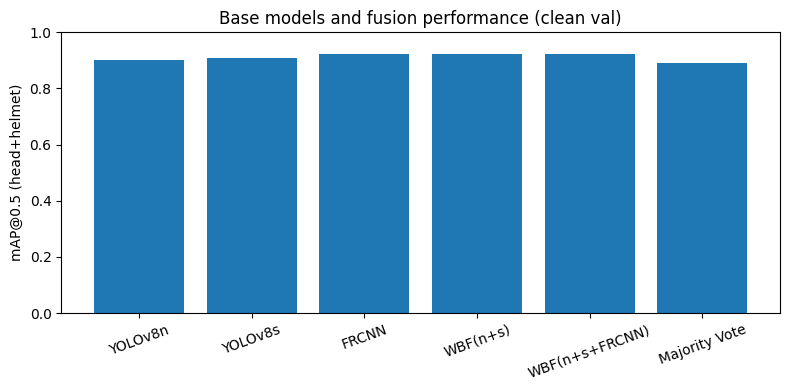

In [ ]:
display_names = [
    "YOLOv8n", "YOLOv8s", "FRCNN",
    "WBF(n+s)", "WBF(n+s+FRCNN)", "Majority Vote",
]

plt.figure(figsize=(8, 4))
plt.bar(range(len(df_plot)), df_plot["mAP"])
plt.xticks(range(len(df_plot)), display_names, rotation=20)
plt.ylabel("mAP@0.5 (head+helmet)")
plt.title("Base models and fusion performance (clean val)")
plt.ylim(0.0, 1.0)
plt.tight_layout()
plt.show()

Multiple seeds for YOLO

In [ ]:
from pathlib import Path

project_root = "/content/drive/MyDrive/CS6436_project"
data_yaml = Path(project_root) / "data_hardhat_2class.yaml"

yaml_text = """path: /content/hardhat_yolo_data/hardhat_yolo_data
train: train/images
val: val/images
names:
  0: head
  1: helmet
"""

data_yaml.write_text(yaml_text)
print(data_yaml.read_text())

path: /content/hardhat_yolo_data/hardhat_yolo_data
train: train/images
val: val/images
names:
  0: head
  1: helmet



In [ ]:
from ultralytics import YOLO

project_root = "/content/drive/MyDrive/CS6436_project"
data_yaml = f"{project_root}/data_hardhat_2class.yaml"

for arch in ["yolov8n", "yolov8s"]:
    for seed in [1, 42]:        # seed 0 already trained
        print(f"Training {arch}, seed={seed}")
        model = YOLO(f"{project_root}/{arch}.pt")
        model.train(
            data=data_yaml,
            epochs=30,           # same as before
            imgsz=640,
            seed=seed,
            project=f"{project_root}/hardhat_hh_2class",
            name=f"{arch}_seed{seed}",
        )

Training yolov8n, seed=1
Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/CS6436_project/data_hardhat_2class.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/MyDrive/CS6436_project/yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_seed12, nbs=64, nms=Fal

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic becaus

AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3301.0±827.9 MB/s, size: 280.4 KB)
train: Scanning /content/hardhat_yolo_data/hardhat_yolo_data/train/labels... 4000 images, 0 backgrounds, 124 corrupt: 100% ━━━━━━━━━━━━ 4000/4000 745.5it/s 5.4s
train: /content/hardhat_yolo_data/hardhat_yolo_data/train/images/hard_hat_workers1007.png: ignoring corrupt image/label: Label class 2 exceeds dataset class count 2. Possible class labels are 0-1
train: /content/hardhat_yolo_data/hardhat_yolo_data/train/images/hard_hat_workers1011.png: ignoring corrupt image/label: Label class 2 exceeds dataset class count 2. Possible class labels are 0-1
train: /content/hardhat_yolo_data/hardhat_yolo_data/train/images/hard_hat_workers1022.png: ignoring corrupt image/label: Label class 2 exceeds dataset class count 2. Possible class labels are 0-1
train: /content/hardhat_yolo_data/hardhat_yolo_data/train/images/hard_hat_workers1029.png: ignoring corrupt image/label: Label class 2 exceeds 

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       1/30      5.92G      1.488      1.669      1.219         17        640: 100% ━━━━━━━━━━━━ 243/243 9.6it/s 25.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 6.0it/s 5.2s
                   all        966       4547      0.848      0.773      0.841      0.471

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/30      5.92G      1.488       1.12      1.163        116        640: 0% ──────────── 0/243  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       2/30      5.93G      1.426      1.113      1.164         11        640: 100% ━━━━━━━━━━━━ 243/243 10.9it/s 22.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.3it/s 3.7s
                   all        966       4547      0.787        0.7      0.787      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       3/30      5.93G      1.483      1.115      1.279         89        640: 0% ──────────── 1/243 1.7it/s 0.2s<2:24

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       3/30      5.93G      1.423       1.02      1.174         32        640: 100% ━━━━━━━━━━━━ 243/243 11.0it/s 22.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.8it/s 3.5s
                   all        966       4547      0.882      0.773      0.854      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       4/30      5.93G      1.339     0.8985      1.211         89        640: 0% ──────────── 1/243 1.8it/s 0.2s<2:16

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       4/30      5.93G      1.396     0.9454      1.169         46        640: 100% ━━━━━━━━━━━━ 243/243 11.1it/s 21.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.8it/s 3.5s
                   all        966       4547      0.885      0.792      0.869       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       5/30      5.93G      1.377     0.9573      1.164        100        640: 0% ──────────── 1/243 2.0it/s 0.1s<2:00

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       5/30      5.93G      1.372     0.8909      1.148         25        640: 100% ━━━━━━━━━━━━ 243/243 10.9it/s 22.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.8it/s 3.5s
                   all        966       4547       0.89      0.786      0.875      0.533

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       6/30      5.93G      1.295     0.7866      1.132        142        640: 0% ──────────── 1/243 2.0it/s 0.2s<2:02

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       6/30      5.93G      1.364     0.8622      1.148         34        640: 100% ━━━━━━━━━━━━ 243/243 11.2it/s 21.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.7it/s 3.6s
                   all        966       4547      0.892      0.834      0.892      0.543

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       7/30      5.93G      1.394     0.8522      1.119        118        640: 0% ──────────── 1/243 1.7it/s 0.2s<2:26

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       7/30      5.93G      1.342     0.8312       1.14         40        640: 100% ━━━━━━━━━━━━ 243/243 11.1it/s 21.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.8it/s 3.5s
                   all        966       4547      0.909      0.827      0.898      0.562

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       8/30      5.93G      1.317     0.7945      1.105        105        640: 0% ──────────── 1/243 1.7it/s 0.2s<2:25

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       8/30      5.93G      1.338     0.8066      1.133         22        640: 100% ━━━━━━━━━━━━ 243/243 11.0it/s 22.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 9.0it/s 3.4s
                   all        966       4547      0.898       0.82      0.893      0.557

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       9/30      5.93G      1.358     0.7636      1.078        100        640: 0% ──────────── 1/243 1.9it/s 0.2s<2:07

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       9/30      5.93G      1.318     0.7875      1.123          8        640: 100% ━━━━━━━━━━━━ 243/243 11.1it/s 22.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.8it/s 3.5s
                   all        966       4547      0.907       0.85      0.916      0.578

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      10/30      5.93G      1.234     0.7541      1.095        109        640: 0% ──────────── 1/243 1.8it/s 0.2s<2:17

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      10/30      5.93G      1.307     0.7718      1.114         40        640: 100% ━━━━━━━━━━━━ 243/243 11.3it/s 21.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.9it/s 3.5s
                   all        966       4547      0.912      0.848      0.913      0.575

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      11/30      5.93G      1.382     0.7778      1.066        116        640: 0% ──────────── 1/243 1.6it/s 0.2s<2:32

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      11/30      5.93G      1.303     0.7545       1.12          9        640: 100% ━━━━━━━━━━━━ 243/243 11.1it/s 21.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.8it/s 3.5s
                   all        966       4547      0.908      0.847      0.917      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      12/30      5.93G      1.192     0.7511      1.146         93        640: 0% ──────────── 0/243  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      12/30      5.93G      1.291     0.7448      1.107         20        640: 100% ━━━━━━━━━━━━ 243/243 11.1it/s 21.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.7it/s 3.6s
                   all        966       4547      0.907      0.851      0.918      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      13/30      5.93G       1.15      0.661      1.064         97        640: 0% ──────────── 1/243 1.9it/s 0.2s<2:05

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      13/30      5.93G      1.285     0.7298      1.106         25        640: 100% ━━━━━━━━━━━━ 243/243 11.2it/s 21.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.6it/s 3.6s
                   all        966       4547      0.914      0.851      0.921      0.582

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      14/30      5.93G      1.239      0.768      1.104         97        640: 0% ──────────── 1/243 1.9it/s 0.2s<2:05

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      14/30      5.93G      1.278     0.7255        1.1         35        640: 100% ━━━━━━━━━━━━ 243/243 11.0it/s 22.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.8it/s 3.5s
                   all        966       4547      0.915      0.865      0.927      0.595

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      15/30      5.93G      1.275     0.7707       1.15         77        640: 0% ──────────── 0/243  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      15/30      5.93G       1.27     0.7053      1.101         28        640: 100% ━━━━━━━━━━━━ 243/243 11.0it/s 22.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.7it/s 3.6s
                   all        966       4547      0.908      0.866       0.92      0.594

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      16/30      5.93G      1.252     0.7121        1.1        128        640: 0% ──────────── 1/243 1.6it/s 0.2s<2:33

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      16/30      5.93G      1.259     0.6926      1.096         16        640: 100% ━━━━━━━━━━━━ 243/243 11.1it/s 21.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.9it/s 3.5s
                   all        966       4547      0.921      0.856      0.926      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      17/30      5.93G      1.192     0.6906      1.083        109        640: 0% ──────────── 1/243 1.9it/s 0.2s<2:07

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      17/30      5.93G      1.256      0.697      1.094         18        640: 100% ━━━━━━━━━━━━ 243/243 11.2it/s 21.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.9it/s 3.5s
                   all        966       4547      0.913      0.867      0.926      0.588

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      18/30      5.93G      1.341     0.7517      1.147         81        640: 0% ──────────── 1/243 2.0it/s 0.1s<2:00

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      18/30      5.93G      1.248     0.6766      1.093         31        640: 100% ━━━━━━━━━━━━ 243/243 11.0it/s 22.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.7it/s 3.6s
                   all        966       4547      0.923      0.872      0.932        0.6

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      19/30      5.93G      1.226     0.6111      1.132         75        640: 0% ──────────── 0/243  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      19/30      5.93G      1.237     0.6663      1.087         18        640: 100% ━━━━━━━━━━━━ 243/243 11.2it/s 21.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.6it/s 3.6s
                   all        966       4547      0.917      0.884      0.934      0.595

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      20/30      5.93G      1.357     0.7896      1.111         96        640: 0% ──────────── 1/243 1.6it/s 0.2s<2:33

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      20/30      5.93G      1.232     0.6642      1.079         62        640: 100% ━━━━━━━━━━━━ 243/243 11.1it/s 22.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.8it/s 3.5s
                   all        966       4547      0.924       0.88      0.934      0.603
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      21/30      5.93G      1.242     0.6054      1.077         52        640: 0% ──────────── 0/243  0.6s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      21/30      5.93G      1.226     0.5967      1.094          8        640: 100% ━━━━━━━━━━━━ 243/243 10.7it/s 22.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.8it/s 3.5s
                   all        966       4547       0.93      0.885      0.934      0.606

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      22/30      5.93G      1.185     0.6067      1.111         61        640: 0% ──────────── 1/243 1.8it/s 0.2s<2:15

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      22/30      5.93G      1.214     0.5859      1.092         17        640: 100% ━━━━━━━━━━━━ 243/243 11.5it/s 21.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.8it/s 3.5s
                   all        966       4547      0.923      0.887      0.937       0.61

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      23/30      5.93G      1.206     0.5741      1.086         11        640: 100% ━━━━━━━━━━━━ 243/243 11.3it/s 21.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.7it/s 3.5s
                   all        966       4547      0.927      0.879      0.935       0.61

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      24/30      5.93G      1.274     0.5901      1.153         81        640: 0% ──────────── 1/243 1.8it/s 0.2s<2:18

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      24/30      5.93G      1.191     0.5607      1.081         18        640: 100% ━━━━━━━━━━━━ 243/243 11.6it/s 21.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.8it/s 3.5s
                   all        966       4547      0.923      0.887      0.935      0.611

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      25/30      5.93G      1.189     0.6293      1.072        101        640: 0% ──────────── 1/243 2.0it/s 0.2s<2:01

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      25/30      5.93G      1.183     0.5505      1.077         17        640: 100% ━━━━━━━━━━━━ 243/243 11.4it/s 21.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.6it/s 3.6s
                   all        966       4547      0.931      0.889      0.942      0.612

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      26/30      5.93G      1.231     0.5951      1.127         53        640: 0% ──────────── 1/243 1.9it/s 0.2s<2:08

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      26/30      5.93G      1.172      0.543      1.071         20        640: 100% ━━━━━━━━━━━━ 243/243 11.5it/s 21.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.7it/s 3.6s
                   all        966       4547      0.932      0.888      0.941      0.616

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      27/30      5.93G      1.181     0.5265      1.076         66        640: 0% ──────────── 1/243 1.8it/s 0.2s<2:17

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      27/30      5.93G      1.166     0.5318      1.064         12        640: 100% ━━━━━━━━━━━━ 243/243 11.6it/s 20.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.6it/s 3.6s
                   all        966       4547      0.936      0.891      0.942      0.619

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      28/30      5.93G       1.09      0.536      1.098         62        640: 0% ──────────── 1/243 1.7it/s 0.2s<2:18

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      28/30      5.93G      1.156      0.524      1.059         17        640: 100% ━━━━━━━━━━━━ 243/243 11.6it/s 21.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.6it/s 3.6s
                   all        966       4547      0.933      0.892      0.944      0.622

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      29/30      5.93G      1.275     0.5861      1.041         86        640: 0% ──────────── 1/243 2.0it/s 0.2s<2:02

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      29/30      5.93G      1.145     0.5179      1.056         14        640: 100% ━━━━━━━━━━━━ 243/243 11.6it/s 20.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.8it/s 3.5s
                   all        966       4547      0.926      0.897      0.942      0.621

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      30/30      5.93G      1.087      0.442      1.053         59        640: 0% ──────────── 1/243 1.9it/s 0.2s<2:06

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      30/30      5.93G      1.142     0.5114      1.057         32        640: 100% ━━━━━━━━━━━━ 243/243 11.5it/s 21.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.8it/s 3.5s
                   all        966       4547      0.928      0.899      0.943      0.623

30 epochs completed in 0.215 hours.
Optimizer stripped from /content/drive/MyDrive/CS6436_project/hardhat_hh_2class/yolov8n_seed12/weights/last.pt, 6.2MB
Optimizer stripped from /content/drive/MyDrive/CS6436_project/hardhat_hh_2class/yolov8n_seed12/weights/best.pt, 6.2MB

Validating /content/drive/MyDrive/CS6436_project/hardhat_hh_2class/yolov8n_seed12/weights/best.pt...
Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic becaus

train: Scanning /content/hardhat_yolo_data/hardhat_yolo_data/train/labels.cache... 4000 images, 0 backgrounds, 124 corrupt: 100% ━━━━━━━━━━━━ 4000/4000 6.7Mit/s 0.0s
train: /content/hardhat_yolo_data/hardhat_yolo_data/train/images/hard_hat_workers1007.png: ignoring corrupt image/label: Label class 2 exceeds dataset class count 2. Possible class labels are 0-1
train: /content/hardhat_yolo_data/hardhat_yolo_data/train/images/hard_hat_workers1011.png: ignoring corrupt image/label: Label class 2 exceeds dataset class count 2. Possible class labels are 0-1
train: /content/hardhat_yolo_data/hardhat_yolo_data/train/images/hard_hat_workers1022.png: ignoring corrupt image/label: Label class 2 exceeds dataset class count 2. Possible class labels are 0-1
train: /content/hardhat_yolo_data/hardhat_yolo_data/train/images/hard_hat_workers1029.png: ignoring corrupt image/label: Label class 2 exceeds dataset class count 2. Possible class labels are 0-1
train: /content/hardhat_yolo_data/hardhat_yolo_dat

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       1/30      2.88G      1.488      1.675      1.179         17        640: 100% ━━━━━━━━━━━━ 243/243 9.4it/s 25.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 7.3it/s 4.2s
                   all        966       4547      0.866      0.779      0.853      0.475

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/30      2.88G      1.499      1.094      1.137        116        640: 0% ──────────── 0/243  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       2/30      2.99G      1.419      1.083      1.143         11        640: 100% ━━━━━━━━━━━━ 243/243 10.8it/s 22.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.0it/s 3.9s
                   all        966       4547      0.838      0.776      0.833      0.486

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       3/30      2.99G      1.485      1.084      1.243         89        640: 0% ──────────── 1/243 1.7it/s 0.2s<2:26

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       3/30      2.99G      1.421      1.007      1.161         32        640: 100% ━━━━━━━━━━━━ 243/243 10.9it/s 22.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.8it/s 3.5s
                   all        966       4547      0.863      0.769      0.834      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       4/30      2.99G      1.359     0.9077      1.175         89        640: 0% ──────────── 1/243 1.6it/s 0.2s<2:27

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       4/30      3.12G      1.398     0.9332      1.156         46        640: 100% ━━━━━━━━━━━━ 243/243 11.0it/s 22.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.7it/s 3.6s
                   all        966       4547      0.888       0.82       0.89      0.535

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       5/30      3.12G      1.344     0.9226      1.134        100        640: 0% ──────────── 1/243 1.9it/s 0.2s<2:08

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       5/30      3.12G      1.369     0.8857      1.138         25        640: 100% ━━━━━━━━━━━━ 243/243 11.0it/s 22.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 7.1it/s 4.3s
                   all        966       4547      0.883      0.802      0.884       0.54

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       6/30      3.12G      1.305     0.8007      1.121        142        640: 0% ──────────── 1/243 1.8it/s 0.2s<2:11

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       6/30      3.12G       1.36     0.8549      1.135         34        640: 100% ━━━━━━━━━━━━ 243/243 10.9it/s 22.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.7it/s 3.6s
                   all        966       4547        0.9      0.806      0.888      0.554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       7/30      3.12G      1.382     0.8207      1.106        118        640: 0% ──────────── 1/243 1.7it/s 0.2s<2:19

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       7/30      3.12G      1.342     0.8309      1.133         40        640: 100% ━━━━━━━━━━━━ 243/243 10.7it/s 22.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.9it/s 3.5s
                   all        966       4547      0.908      0.832      0.898      0.562

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       8/30      3.12G      1.352     0.8153      1.107        105        640: 0% ──────────── 1/243 1.7it/s 0.2s<2:22

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       8/30      3.12G      1.338     0.8014      1.125         22        640: 100% ━━━━━━━━━━━━ 243/243 11.0it/s 22.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.5it/s 3.6s
                   all        966       4547      0.905      0.828      0.896       0.55

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       9/30      3.12G      1.354     0.7418      1.074        100        640: 0% ──────────── 1/243 1.9it/s 0.2s<2:11

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       9/30      3.12G      1.321     0.7824      1.119          8        640: 100% ━━━━━━━━━━━━ 243/243 10.8it/s 22.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.5it/s 3.7s
                   all        966       4547      0.903      0.843      0.915      0.571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      10/30      3.12G      1.198     0.7557      1.086        109        640: 0% ──────────── 1/243 2.0it/s 0.2s<2:04

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      10/30      3.12G      1.305     0.7661      1.105         40        640: 100% ━━━━━━━━━━━━ 243/243 10.9it/s 22.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.8it/s 3.5s
                   all        966       4547      0.918      0.849      0.914      0.573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      11/30      3.12G      1.372     0.7132      1.058        110        640: 0% ──────────── 0/243  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      11/30      3.12G        1.3     0.7572      1.111          9        640: 100% ━━━━━━━━━━━━ 243/243 10.8it/s 22.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.7it/s 3.6s
                   all        966       4547      0.908      0.846       0.91      0.576

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      12/30      3.12G      1.205     0.7187      1.138         94        640: 0% ──────────── 1/243 1.7it/s 0.2s<2:22

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      12/30      3.12G      1.289     0.7372      1.101         20        640: 100% ━━━━━━━━━━━━ 243/243 10.8it/s 22.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.7it/s 3.5s
                   all        966       4547      0.921      0.855      0.923      0.577

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      13/30      3.12G      1.173     0.6593      1.069         97        640: 0% ──────────── 1/243 2.0it/s 0.2s<2:03

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      13/30      3.12G      1.285     0.7262      1.103         25        640: 100% ━━━━━━━━━━━━ 243/243 10.9it/s 22.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.7it/s 3.6s
                   all        966       4547      0.916      0.859      0.925      0.584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      14/30      3.12G      1.208     0.7517      1.089         97        640: 0% ──────────── 1/243 2.0it/s 0.2s<2:04

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      14/30      3.12G      1.272     0.7165      1.096         35        640: 100% ━━━━━━━━━━━━ 243/243 10.7it/s 22.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.4it/s 3.7s
                   all        966       4547      0.916      0.871      0.926      0.594

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      15/30      3.12G      1.268     0.7912      1.135         77        640: 0% ──────────── 0/243  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      15/30      3.12G       1.27     0.7039      1.095         28        640: 100% ━━━━━━━━━━━━ 243/243 11.0it/s 22.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.8it/s 3.5s
                   all        966       4547      0.931      0.863      0.926      0.597

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      16/30      3.12G      1.256     0.7082       1.09        128        640: 0% ──────────── 1/243 1.6it/s 0.2s<2:33

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      16/30      3.12G      1.253     0.6915      1.088         16        640: 100% ━━━━━━━━━━━━ 243/243 10.9it/s 22.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.8it/s 3.5s
                   all        966       4547      0.927      0.859      0.927      0.598

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      17/30      3.12G      1.181     0.6752      1.074        109        640: 0% ──────────── 1/243 1.7it/s 0.2s<2:22

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      17/30      3.12G       1.26     0.6956      1.091         18        640: 100% ━━━━━━━━━━━━ 243/243 10.7it/s 22.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.5it/s 3.7s
                   all        966       4547      0.923      0.856      0.924      0.594

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      18/30      3.12G      1.314     0.7348       1.12         81        640: 0% ──────────── 1/243 1.9it/s 0.2s<2:06

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      18/30      3.12G      1.253      0.678      1.089         31        640: 100% ━━━━━━━━━━━━ 243/243 11.0it/s 22.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.6it/s 3.6s
                   all        966       4547      0.935      0.867      0.936      0.608

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      19/30      3.12G      1.239     0.6259      1.127         75        640: 0% ──────────── 0/243  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      19/30      3.12G      1.233     0.6606      1.079         18        640: 100% ━━━━━━━━━━━━ 243/243 10.9it/s 22.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.6it/s 3.6s
                   all        966       4547      0.928      0.873      0.936      0.601

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      20/30      3.12G      1.358      0.795      1.106         96        640: 0% ──────────── 1/243 1.5it/s 0.2s<2:45

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      20/30      3.12G       1.23     0.6578      1.073         62        640: 100% ━━━━━━━━━━━━ 243/243 11.0it/s 22.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.5it/s 3.7s
                   all        966       4547       0.92      0.884      0.937      0.604
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      21/30      3.12G      1.304     0.6668      1.065         62        640: 0% ──────────── 1/243 2.5it/s 0.6s<1:38

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      21/30      3.12G      1.223     0.5957      1.086          8        640: 100% ━━━━━━━━━━━━ 243/243 10.7it/s 22.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.3it/s 3.7s
                   all        966       4547      0.927      0.883      0.938      0.604

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      22/30      3.12G      1.194     0.6291      1.111         61        640: 0% ──────────── 1/243 1.9it/s 0.2s<2:06

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      22/30      3.12G      1.214     0.5842      1.083         17        640: 100% ━━━━━━━━━━━━ 243/243 11.3it/s 21.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.5it/s 3.6s
                   all        966       4547       0.93      0.881       0.94      0.617

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      23/30      3.12G       1.14     0.5316      1.043         55        640: 0% ──────────── 0/243  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      23/30      3.12G      1.204     0.5723      1.077         11        640: 100% ━━━━━━━━━━━━ 243/243 11.3it/s 21.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.4it/s 3.7s
                   all        966       4547       0.93      0.888      0.941      0.614

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      24/30      3.12G      1.253     0.5906      1.135         81        640: 0% ──────────── 1/243 1.7it/s 0.2s<2:22

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      24/30      3.12G      1.191     0.5579      1.072         18        640: 100% ━━━━━━━━━━━━ 243/243 11.3it/s 21.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.4it/s 3.7s
                   all        966       4547      0.931      0.876      0.937      0.617

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      25/30      3.12G      1.169     0.5958      1.056        101        640: 0% ──────────── 1/243 1.9it/s 0.2s<2:06

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      25/30      3.12G      1.182     0.5457      1.068         17        640: 100% ━━━━━━━━━━━━ 243/243 11.3it/s 21.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.4it/s 3.7s
                   all        966       4547       0.92      0.893      0.943      0.614

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      26/30      3.12G      1.244      0.567      1.115         53        640: 0% ──────────── 1/243 1.7it/s 0.2s<2:20

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      26/30      3.12G      1.176     0.5451      1.063         20        640: 100% ━━━━━━━━━━━━ 243/243 11.2it/s 21.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.6it/s 3.6s
                   all        966       4547      0.924        0.9      0.944      0.622

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      27/30      3.12G      1.108     0.4662      1.058         94        640: 0% ──────────── 0/243  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      27/30      3.12G      1.165     0.5327      1.055         12        640: 100% ━━━━━━━━━━━━ 243/243 11.1it/s 22.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.4it/s 3.7s
                   all        966       4547      0.932       0.89      0.943      0.622

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      28/30      3.12G      1.107     0.5605      1.095         62        640: 0% ──────────── 1/243 1.7it/s 0.2s<2:21

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      28/30      3.12G      1.154     0.5246      1.052         17        640: 100% ━━━━━━━━━━━━ 243/243 11.2it/s 21.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.6it/s 3.6s
                   all        966       4547      0.924      0.895      0.942      0.623

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      29/30      3.12G      1.267     0.5756      1.038         86        640: 0% ──────────── 1/243 2.0it/s 0.2s<2:03

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      29/30      3.12G      1.145     0.5202      1.048         14        640: 100% ━━━━━━━━━━━━ 243/243 11.2it/s 21.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.5it/s 3.7s
                   all        966       4547       0.93      0.893      0.943      0.623

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      30/30      3.12G        1.1     0.4517      1.057         59        640: 0% ──────────── 1/243 1.9it/s 0.2s<2:10

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      30/30      3.12G       1.14     0.5049      1.049         32        640: 100% ━━━━━━━━━━━━ 243/243 11.3it/s 21.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.5it/s 3.6s
                   all        966       4547      0.933      0.893      0.946      0.627

30 epochs completed in 0.219 hours.
Optimizer stripped from /content/drive/MyDrive/CS6436_project/hardhat_hh_2class/yolov8n_seed42/weights/last.pt, 6.2MB
Optimizer stripped from /content/drive/MyDrive/CS6436_project/hardhat_hh_2class/yolov8n_seed42/weights/best.pt, 6.2MB

Validating /content/drive/MyDrive/CS6436_project/hardhat_hh_2class/yolov8n_seed42/weights/best.pt...
Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic becaus

train: Scanning /content/hardhat_yolo_data/hardhat_yolo_data/train/labels.cache... 4000 images, 0 backgrounds, 124 corrupt: 100% ━━━━━━━━━━━━ 4000/4000 6.3Mit/s 0.0s
train: /content/hardhat_yolo_data/hardhat_yolo_data/train/images/hard_hat_workers1007.png: ignoring corrupt image/label: Label class 2 exceeds dataset class count 2. Possible class labels are 0-1
train: /content/hardhat_yolo_data/hardhat_yolo_data/train/images/hard_hat_workers1011.png: ignoring corrupt image/label: Label class 2 exceeds dataset class count 2. Possible class labels are 0-1
train: /content/hardhat_yolo_data/hardhat_yolo_data/train/images/hard_hat_workers1022.png: ignoring corrupt image/label: Label class 2 exceeds dataset class count 2. Possible class labels are 0-1
train: /content/hardhat_yolo_data/hardhat_yolo_data/train/images/hard_hat_workers1029.png: ignoring corrupt image/label: Label class 2 exceeds dataset class count 2. Possible class labels are 0-1
train: /content/hardhat_yolo_data/hardhat_yolo_dat

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       1/30      4.38G      1.456      1.299      1.213         17        640: 100% ━━━━━━━━━━━━ 243/243 9.2it/s 26.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 7.8it/s 4.0s
                   all        966       4547      0.838       0.78      0.854      0.507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/30      5.15G      1.434     0.8175      1.157        116        640: 0% ──────────── 0/243  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       2/30      5.15G      1.408      0.922      1.175         11        640: 100% ━━━━━━━━━━━━ 243/243 10.2it/s 23.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 7.6it/s 4.1s
                   all        966       4547      0.866       0.78      0.857      0.498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       3/30      5.15G      1.446     0.8874      1.267        100        640: 0% ──────────── 0/243  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       3/30      5.15G      1.404      0.914       1.18         32        640: 100% ━━━━━━━━━━━━ 243/243 10.4it/s 23.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.0it/s 3.9s
                   all        966       4547      0.872      0.803      0.872      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       4/30      5.15G      1.401     0.8298      1.232         89        640: 0% ──────────── 1/243 1.6it/s 0.2s<2:36

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       4/30      5.15G      1.384     0.8761      1.172         46        640: 100% ━━━━━━━━━━━━ 243/243 10.5it/s 23.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 7.8it/s 4.0s
                   all        966       4547      0.885      0.828      0.891      0.535

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       5/30      5.15G      1.401     0.9025       1.19        100        640: 0% ──────────── 1/243 1.9it/s 0.2s<2:06

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       5/30      5.15G      1.356     0.8356      1.152         25        640: 100% ━━━━━━━━━━━━ 243/243 10.6it/s 23.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 7.9it/s 3.9s
                   all        966       4547      0.873      0.802      0.894      0.548

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       6/30      5.15G      1.286     0.7276       1.13        142        640: 0% ──────────── 1/243 1.7it/s 0.2s<2:23

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       6/30      5.15G      1.346     0.8003      1.147         34        640: 100% ━━━━━━━━━━━━ 243/243 10.4it/s 23.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.0it/s 3.9s
                   all        966       4547      0.898      0.842      0.904       0.56

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       7/30      5.15G      1.447     0.7358      1.123         76        640: 0% ──────────── 0/243  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       7/30      5.15G      1.317     0.7768      1.137         40        640: 100% ━━━━━━━━━━━━ 243/243 10.5it/s 23.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 7.8it/s 4.0s
                   all        966       4547      0.914       0.84      0.912      0.564

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       8/30      5.15G      1.343     0.7495      1.129        105        640: 0% ──────────── 1/243 1.7it/s 0.2s<2:24

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       8/30      5.15G      1.312     0.7552      1.132         22        640: 100% ━━━━━━━━━━━━ 243/243 10.5it/s 23.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 7.9it/s 3.9s
                   all        966       4547      0.902      0.855      0.915      0.569

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       9/30      5.15G      1.277     0.6768      1.064        100        640: 0% ──────────── 1/243 1.9it/s 0.2s<2:09

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       9/30      5.15G      1.291     0.7345      1.122          8        640: 100% ━━━━━━━━━━━━ 243/243 10.5it/s 23.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.1it/s 3.8s
                   all        966       4547      0.913      0.862      0.927      0.589

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      10/30      5.15G      1.169     0.6926      1.084        109        640: 0% ──────────── 1/243 1.9it/s 0.2s<2:10

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      10/30      5.15G      1.281     0.7218      1.113         40        640: 100% ━━━━━━━━━━━━ 243/243 10.7it/s 22.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 7.9it/s 3.9s
                   all        966       4547      0.919      0.858      0.926      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      11/30      5.15G      1.387     0.7192      1.078        110        640: 0% ──────────── 0/243  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      11/30      5.15G      1.273     0.7054      1.115          9        640: 100% ━━━━━━━━━━━━ 243/243 10.5it/s 23.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 7.8it/s 4.0s
                   all        966       4547      0.906      0.866      0.924       0.58

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      12/30      5.15G      1.205     0.6884      1.143         94        640: 0% ──────────── 1/243 1.6it/s 0.2s<2:32

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      12/30      5.15G      1.258      0.687      1.103         20        640: 100% ━━━━━━━━━━━━ 243/243 10.5it/s 23.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.3it/s 3.8s
                   all        966       4547       0.92      0.875      0.931      0.594

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      13/30      5.15G      1.137     0.6237      1.069         97        640: 0% ──────────── 1/243 1.9it/s 0.2s<2:05

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      13/30      5.15G       1.26     0.6795      1.109         25        640: 100% ━━━━━━━━━━━━ 243/243 10.5it/s 23.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.1it/s 3.8s
                   all        966       4547      0.915      0.887      0.937      0.595

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      14/30      5.15G      1.199     0.6956      1.108         97        640: 0% ──────────── 1/243 1.8it/s 0.2s<2:11

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      14/30      5.15G      1.243     0.6703      1.098         35        640: 100% ━━━━━━━━━━━━ 243/243 10.5it/s 23.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.2it/s 3.8s
                   all        966       4547      0.922      0.877      0.934      0.599

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      15/30      5.15G       1.23     0.6936      1.131         77        640: 0% ──────────── 0/243  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      15/30      5.15G      1.239     0.6576      1.099         28        640: 100% ━━━━━━━━━━━━ 243/243 10.4it/s 23.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.2it/s 3.8s
                   all        966       4547       0.92      0.868      0.929      0.605

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      16/30      5.15G      1.204     0.6401      1.081        128        640: 0% ──────────── 1/243 1.6it/s 0.2s<2:33

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      16/30      5.15G      1.226     0.6462      1.093         16        640: 100% ━━━━━━━━━━━━ 243/243 10.6it/s 23.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 7.8it/s 4.0s
                   all        966       4547      0.925      0.884       0.94      0.606

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      17/30      5.15G      1.198     0.6175      1.088        109        640: 0% ──────────── 1/243 1.9it/s 0.2s<2:09

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      17/30      5.15G      1.222     0.6431       1.09         18        640: 100% ━━━━━━━━━━━━ 243/243 10.5it/s 23.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.0it/s 3.9s
                   all        966       4547      0.928      0.881      0.943      0.605

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      18/30      5.15G       1.31     0.6913      1.154         81        640: 0% ──────────── 1/243 1.9it/s 0.2s<2:08

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      18/30      5.15G      1.214     0.6264      1.086         31        640: 100% ━━━━━━━━━━━━ 243/243 10.7it/s 22.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.0it/s 3.9s
                   all        966       4547      0.918      0.892      0.942      0.611

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      19/30      5.15G      1.202     0.5965      1.124         75        640: 0% ──────────── 0/243  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      19/30      5.15G      1.201     0.6138      1.082         18        640: 100% ━━━━━━━━━━━━ 243/243 10.6it/s 23.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 7.8it/s 4.0s
                   all        966       4547      0.927      0.891      0.945      0.613

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      20/30      5.15G      1.335     0.6959       1.12         96        640: 0% ──────────── 1/243 1.6it/s 0.2s<2:33

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      20/30      5.15G      1.191     0.6072      1.074         62        640: 100% ━━━━━━━━━━━━ 243/243 10.5it/s 23.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.0it/s 3.9s
                   all        966       4547      0.924       0.89      0.942      0.613
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      21/30      5.15G      1.183     0.5157      1.072         52        640: 0% ──────────── 0/243  0.8s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      21/30      5.15G      1.189     0.5491      1.093          8        640: 100% ━━━━━━━━━━━━ 243/243 10.0it/s 24.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.0it/s 3.9s
                   all        966       4547       0.93      0.894      0.944      0.618

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      22/30      5.15G      1.174     0.5886      1.117         61        640: 0% ──────────── 1/243 1.9it/s 0.2s<2:04

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      22/30      5.15G      1.176     0.5383       1.09         17        640: 100% ━━━━━━━━━━━━ 243/243 10.8it/s 22.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.1it/s 3.8s
                   all        966       4547      0.928      0.901      0.949      0.626

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      23/30      5.15G       1.13     0.4988      1.043         55        640: 0% ──────────── 0/243  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      23/30      5.15G      1.172     0.5329      1.086         11        640: 100% ━━━━━━━━━━━━ 243/243 10.8it/s 22.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 7.9it/s 3.9s
                   all        966       4547      0.922      0.898      0.945       0.62

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      24/30      5.15G      1.201     0.5923      1.152         81        640: 0% ──────────── 1/243 1.6it/s 0.2s<2:31

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      24/30      5.15G       1.16     0.5149      1.082         18        640: 100% ━━━━━━━━━━━━ 243/243 10.7it/s 22.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 7.1it/s 4.4s
                   all        966       4547      0.933      0.897      0.942       0.62

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      25/30      5.15G      1.163     0.5705       1.07        101        640: 0% ──────────── 1/243 1.8it/s 0.2s<2:16

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      25/30      5.15G      1.147     0.5043      1.074         17        640: 100% ━━━━━━━━━━━━ 243/243 10.9it/s 22.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 7.9it/s 3.9s
                   all        966       4547      0.935      0.902      0.949      0.624

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      26/30      5.15G      1.211     0.5428      1.127         53        640: 0% ──────────── 1/243 1.8it/s 0.2s<2:16

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      26/30      5.15G      1.136     0.4931      1.069         20        640: 100% ━━━━━━━━━━━━ 243/243 10.9it/s 22.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.0it/s 3.9s
                   all        966       4547      0.923      0.906      0.948      0.629

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      27/30      5.15G       1.04     0.4326      1.068         94        640: 0% ──────────── 0/243  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      27/30      5.15G      1.122     0.4831       1.06         12        640: 100% ━━━━━━━━━━━━ 243/243 10.7it/s 22.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.2it/s 3.8s
                   all        966       4547      0.925      0.913      0.948      0.629

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      28/30      5.15G      1.071      0.502      1.134         62        640: 0% ──────────── 1/243 1.6it/s 0.2s<2:36

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      28/30      5.15G      1.111      0.476      1.057         17        640: 100% ━━━━━━━━━━━━ 243/243 10.6it/s 22.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 7.8it/s 4.0s
                   all        966       4547      0.933      0.901      0.948      0.629

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      29/30      5.15G      1.248     0.5318      1.044         86        640: 0% ──────────── 1/243 1.7it/s 0.2s<2:19

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      29/30      5.15G      1.096      0.468      1.049         14        640: 100% ━━━━━━━━━━━━ 243/243 10.9it/s 22.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.2it/s 3.8s
                   all        966       4547      0.919      0.919      0.946       0.63

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      30/30      5.15G      1.042     0.4143       1.05         59        640: 0% ──────────── 1/243 1.9it/s 0.2s<2:10

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      30/30      5.15G      1.094     0.4606      1.051         32        640: 100% ━━━━━━━━━━━━ 243/243 10.7it/s 22.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.0it/s 3.9s
                   all        966       4547      0.932      0.905      0.948      0.635

30 epochs completed in 0.231 hours.
Optimizer stripped from /content/drive/MyDrive/CS6436_project/hardhat_hh_2class/yolov8s_seed1/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/CS6436_project/hardhat_hh_2class/yolov8s_seed1/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/CS6436_project/hardhat_hh_2class/yolov8s_seed1/weights/best.pt...
Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
Model summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/3

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic becaus

train: Scanning /content/hardhat_yolo_data/hardhat_yolo_data/train/labels.cache... 4000 images, 0 backgrounds, 124 corrupt: 100% ━━━━━━━━━━━━ 4000/4000 6.6Mit/s 0.0s
train: /content/hardhat_yolo_data/hardhat_yolo_data/train/images/hard_hat_workers1007.png: ignoring corrupt image/label: Label class 2 exceeds dataset class count 2. Possible class labels are 0-1
train: /content/hardhat_yolo_data/hardhat_yolo_data/train/images/hard_hat_workers1011.png: ignoring corrupt image/label: Label class 2 exceeds dataset class count 2. Possible class labels are 0-1
train: /content/hardhat_yolo_data/hardhat_yolo_data/train/images/hard_hat_workers1022.png: ignoring corrupt image/label: Label class 2 exceeds dataset class count 2. Possible class labels are 0-1
train: /content/hardhat_yolo_data/hardhat_yolo_data/train/images/hard_hat_workers1029.png: ignoring corrupt image/label: Label class 2 exceeds dataset class count 2. Possible class labels are 0-1
train: /content/hardhat_yolo_data/hardhat_yolo_dat

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       1/30      4.51G      1.456      1.267      1.257         17        640: 100% ━━━━━━━━━━━━ 243/243 9.3it/s 26.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 7.7it/s 4.0s
                   all        966       4547      0.864      0.781      0.862      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/30      5.28G      1.396     0.8478      1.165        116        640: 0% ──────────── 0/243  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       2/30      5.28G      1.405     0.9337        1.2         11        640: 100% ━━━━━━━━━━━━ 243/243 10.3it/s 23.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.0it/s 3.9s
                   all        966       4547       0.88      0.796      0.871      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       3/30      5.28G      1.529     0.9431      1.351         89        640: 0% ──────────── 1/243 1.7it/s 0.2s<2:21

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       3/30      5.28G      1.405     0.9063      1.212         32        640: 100% ━━━━━━━━━━━━ 243/243 10.5it/s 23.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.1it/s 3.8s
                   all        966       4547      0.859      0.769      0.859      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       4/30      5.28G      1.416     0.8598      1.287         89        640: 0% ──────────── 1/243 1.7it/s 0.2s<2:23

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       4/30      5.28G      1.382      0.871      1.205         46        640: 100% ━━━━━━━━━━━━ 243/243 10.6it/s 23.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.1it/s 3.8s
                   all        966       4547      0.879      0.813      0.884      0.537

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       5/30      5.28G      1.368     0.8772      1.203        100        640: 0% ──────────── 1/243 1.9it/s 0.2s<2:06

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       5/30      5.28G      1.356     0.8312      1.182         25        640: 100% ━━━━━━━━━━━━ 243/243 10.7it/s 22.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 6.9it/s 4.5s
                   all        966       4547      0.885      0.803      0.889      0.537

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       6/30      5.28G       1.28     0.7468      1.158        142        640: 0% ──────────── 1/243 1.9it/s 0.2s<2:08

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       6/30      5.28G      1.347      0.804      1.178         34        640: 100% ━━━━━━━━━━━━ 243/243 10.6it/s 22.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.1it/s 3.8s
                   all        966       4547      0.889      0.842      0.902      0.557

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       7/30      5.28G      1.473     0.7293      1.174         76        640: 0% ──────────── 0/243  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       7/30      5.28G      1.322     0.7732      1.175         40        640: 100% ━━━━━━━━━━━━ 243/243 10.6it/s 22.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 7.9it/s 3.9s
                   all        966       4547      0.908      0.854      0.916      0.568

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       8/30      5.28G       1.32     0.7447      1.165        105        640: 0% ──────────── 1/243 1.7it/s 0.2s<2:23

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       8/30      5.28G      1.312      0.752      1.164         22        640: 100% ━━━━━━━━━━━━ 243/243 10.5it/s 23.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 7.9it/s 3.9s
                   all        966       4547      0.917      0.855      0.919      0.564

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       9/30      5.28G      1.268     0.6542      1.095        100        640: 0% ──────────── 1/243 1.7it/s 0.2s<2:21

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       9/30      5.28G      1.294     0.7329      1.152          8        640: 100% ━━━━━━━━━━━━ 243/243 10.6it/s 22.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.0it/s 3.9s
                   all        966       4547      0.911      0.862      0.927      0.584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      10/30      5.28G      1.178     0.7016      1.133        109        640: 0% ──────────── 1/243 1.7it/s 0.2s<2:25

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      10/30      5.28G      1.274     0.7153      1.138         40        640: 100% ━━━━━━━━━━━━ 243/243 10.5it/s 23.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 7.9it/s 3.9s
                   all        966       4547      0.915      0.861       0.92      0.587

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      11/30      5.28G       1.32       0.66      1.094        110        640: 0% ──────────── 0/243  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      11/30      5.28G      1.271     0.6985      1.146          9        640: 100% ━━━━━━━━━━━━ 243/243 10.6it/s 23.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.1it/s 3.8s
                   all        966       4547      0.914      0.877      0.927      0.583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      12/30      5.28G      1.206     0.6704      1.182         94        640: 0% ──────────── 1/243 1.7it/s 0.2s<2:24

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      12/30      5.28G      1.259     0.6814      1.134         20        640: 100% ━━━━━━━━━━━━ 243/243 10.5it/s 23.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.3it/s 3.7s
                   all        966       4547      0.918      0.887      0.933      0.599

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      13/30      5.28G      1.101     0.6032      1.081         97        640: 0% ──────────── 1/243 1.8it/s 0.2s<2:15

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      13/30      5.28G      1.257     0.6791      1.136         25        640: 100% ━━━━━━━━━━━━ 243/243 10.5it/s 23.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.1it/s 3.9s
                   all        966       4547      0.908      0.868      0.929      0.593

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      14/30      5.28G      1.209     0.7597      1.141         97        640: 0% ──────────── 1/243 1.8it/s 0.2s<2:13

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      14/30      5.28G      1.241      0.662      1.123         35        640: 100% ━━━━━━━━━━━━ 243/243 10.3it/s 23.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.0it/s 3.9s
                   all        966       4547      0.921      0.881      0.935      0.599

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      15/30      5.28G      1.223       0.69      1.146         77        640: 0% ──────────── 0/243  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      15/30      5.28G       1.24     0.6569      1.127         28        640: 100% ━━━━━━━━━━━━ 243/243 10.4it/s 23.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 7.8it/s 4.0s
                   all        966       4547      0.918      0.887      0.933      0.608

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      16/30      5.28G      1.191     0.6464      1.102        128        640: 0% ──────────── 1/243 1.6it/s 0.2s<2:27

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      16/30      5.28G      1.223     0.6461      1.117         16        640: 100% ━━━━━━━━━━━━ 243/243 10.4it/s 23.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 7.8it/s 4.0s
                   all        966       4547       0.91      0.894      0.936      0.605

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      17/30      5.28G      1.163     0.5965      1.095        109        640: 0% ──────────── 1/243 1.8it/s 0.2s<2:16

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      17/30      5.28G      1.227     0.6384      1.117         18        640: 100% ━━━━━━━━━━━━ 243/243 10.6it/s 22.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 7.8it/s 4.0s
                   all        966       4547      0.917      0.889      0.935      0.606

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      18/30      5.28G      1.288     0.6701      1.169         81        640: 0% ──────────── 1/243 1.8it/s 0.2s<2:15

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      18/30      5.28G      1.211     0.6236      1.109         31        640: 100% ━━━━━━━━━━━━ 243/243 10.4it/s 23.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.0it/s 3.9s
                   all        966       4547      0.921      0.889      0.941      0.609

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      19/30      5.28G      1.214     0.6049      1.154         75        640: 0% ──────────── 0/243  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      19/30      5.28G      1.199     0.6115      1.106         18        640: 100% ━━━━━━━━━━━━ 243/243 10.4it/s 23.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.0it/s 3.9s
                   all        966       4547      0.927      0.897      0.947      0.616

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      20/30      5.28G      1.343      0.707      1.137         96        640: 0% ──────────── 1/243 1.7it/s 0.2s<2:25

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      20/30      5.28G      1.186     0.5985      1.092         62        640: 100% ━━━━━━━━━━━━ 243/243 10.4it/s 23.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.1it/s 3.8s
                   all        966       4547      0.917       0.89      0.942      0.608
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      21/30      5.28G      1.174     0.5551      1.096         52        640: 0% ──────────── 0/243  0.4s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      21/30      5.28G      1.188     0.5481      1.115          8        640: 100% ━━━━━━━━━━━━ 243/243 10.2it/s 23.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 7.8it/s 4.0s
                   all        966       4547      0.919      0.891      0.943      0.616

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      22/30      5.28G      1.144     0.5755      1.133         61        640: 0% ──────────── 1/243 1.9it/s 0.2s<2:08

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      22/30      5.28G      1.176     0.5357      1.116         17        640: 100% ━━━━━━━━━━━━ 243/243 10.8it/s 22.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 7.8it/s 4.0s
                   all        966       4547      0.922        0.9      0.947      0.623

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      23/30      5.28G      1.116     0.5141      1.056         55        640: 0% ──────────── 0/243  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      23/30      5.28G       1.17      0.528      1.112         11        640: 100% ━━━━━━━━━━━━ 243/243 10.8it/s 22.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 7.9it/s 3.9s
                   all        966       4547      0.922      0.899      0.946       0.62

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      24/30      5.28G      1.208     0.5651      1.187         81        640: 0% ──────────── 1/243 1.6it/s 0.2s<2:27

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      24/30      5.28G      1.153     0.5114      1.106         18        640: 100% ━━━━━━━━━━━━ 243/243 10.8it/s 22.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.1it/s 3.8s
                   all        966       4547      0.931      0.895      0.945      0.625

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      25/30      5.28G      1.142     0.5869      1.091        101        640: 0% ──────────── 1/243 1.9it/s 0.2s<2:07

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      25/30      5.28G      1.146     0.5029      1.098         17        640: 100% ━━━━━━━━━━━━ 243/243 10.7it/s 22.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.1it/s 3.8s
                   all        966       4547      0.917      0.903       0.95      0.624

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      26/30      5.28G      1.201     0.5317      1.147         53        640: 0% ──────────── 1/243 1.7it/s 0.2s<2:20

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      26/30      5.28G      1.138     0.4969      1.093         20        640: 100% ━━━━━━━━━━━━ 243/243 10.8it/s 22.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.1it/s 3.8s
                   all        966       4547      0.928      0.896      0.948      0.627

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      27/30      5.28G      1.038     0.4061      1.074         94        640: 0% ──────────── 0/243  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      27/30      5.28G      1.121     0.4831      1.081         12        640: 100% ━━━━━━━━━━━━ 243/243 10.8it/s 22.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.1it/s 3.8s
                   all        966       4547      0.934      0.898      0.946      0.625

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      28/30      5.28G      1.051     0.5084      1.123         62        640: 0% ──────────── 1/243 1.7it/s 0.2s<2:26

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      28/30      5.28G      1.108     0.4786      1.077         17        640: 100% ━━━━━━━━━━━━ 243/243 10.8it/s 22.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.1it/s 3.8s
                   all        966       4547      0.928      0.903      0.945      0.628

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      29/30      5.28G      1.215     0.5159      1.065         86        640: 0% ──────────── 1/243 1.9it/s 0.2s<2:06

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      29/30      5.28G      1.098     0.4693      1.072         14        640: 100% ━━━━━━━━━━━━ 243/243 10.7it/s 22.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.1it/s 3.8s
                   all        966       4547      0.918      0.913      0.946       0.63

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      30/30      5.28G      1.038     0.4112      1.078         59        640: 0% ──────────── 1/243 1.8it/s 0.2s<2:13

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      30/30      5.28G       1.09     0.4583      1.072         32        640: 100% ━━━━━━━━━━━━ 243/243 10.9it/s 22.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.0it/s 3.9s
                   all        966       4547       0.93      0.906      0.947      0.633

30 epochs completed in 0.230 hours.
Optimizer stripped from /content/drive/MyDrive/CS6436_project/hardhat_hh_2class/yolov8s_seed42/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/CS6436_project/hardhat_hh_2class/yolov8s_seed42/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/CS6436_project/hardhat_hh_2class/yolov8s_seed42/weights/best.pt...
Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
Model summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3

In [ ]:
!EXP=/content/drive/MyDrive/CS6436_project/hardhat_hh_2class/yolov8n_seed42
!find $EXP -maxdepth 4 -type f \( -name "args.yaml" -o -name "opt.yaml" \)

In [ ]:
!cat /content/drive/MyDrive/CS6436_project/hardhat_hh_2class/yolov8n_seed42/args.yaml

task: detect
mode: train
model: /content/drive/MyDrive/CS6436_project/yolov8n.pt
data: /content/drive/MyDrive/CS6436_project/data_hardhat_2class.yaml
epochs: 30
time: null
patience: 100
batch: 16
imgsz: 640
save: true
save_period: -1
cache: false
device: '0'
workers: 8
project: /content/drive/MyDrive/CS6436_project/hardhat_hh_2class
name: yolov8n_seed42
exist_ok: false
pretrained: true
optimizer: auto
verbose: true
seed: 42
deterministic: true
single_cls: false
rect: false
cos_lr: false
close_mosaic: 10
resume: false
amp: true
fraction: 1.0
profile: false
freeze: null
multi_scale: false
compile: false
overlap_mask: true
mask_ratio: 4
dropout: 0.0
val: true
split: val
save_json: false
conf: null
iou: 0.7
max_det: 300
half: false
dnn: false
plots: true
source: null
vid_stride: 1
stream_buffer: false
visualize: false
augment: false
agnostic_nms: false
classes: null
retina_masks: false
embed: null
show: false
save_frames: false
save_txt: false
save_conf: false
save_crop: false
show_labels:

In [ ]:
!yolo detect val \
  model="/content/drive/MyDrive/CS6436_project/hardhat_hh_2class/yolov8n_seed42/weights/best.pt" \
  data="/content/drive/MyDrive/CS6436_project/data_hardhat_2class.yaml" \
  imgsz=640 \
  batch=16 \
  device=0 \
  name="yolov8n_seed42_reval"

Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3604.4±853.9 MB/s, size: 245.6 KB)
val: Scanning /content/hardhat_yolo_data/hardhat_yolo_data/val/labels.cache... 1000 images, 0 backgrounds, 34 corrupt: 100% ━━━━━━━━━━━━ 1000/1000 14.1Mit/s 0.0s
val: /content/hardhat_yolo_data/hardhat_yolo_data/val/images/hard_hat_workers1148.png: ignoring corrupt image/label: Label class 2 exceeds dataset class count 2. Possible class labels are 0-1
val: /content/hardhat_yolo_data/hardhat_yolo_data/val/images/hard_hat_workers1236.png: ignoring corrupt image/label: Label class 2 exceeds dataset class count 2. Possible class labels are 0-1
val: /content/hardhat_yolo_data/hardhat_yolo_data/val/images/hard_hat_workers1553.png: ignoring corrupt image/label: Label class 2 exceeds dataset class count 2. Possible class labels are 0-1
v

In [ ]:
# Train set
!grep -rl '^2 ' /content/hardhat_yolo_data/hardhat_yolo_data/train/labels

# Val set
!grep -rl '^2 ' /content/hardhat_yolo_data/hardhat_yolo_data/val/labels

/content/hardhat_yolo_data/hardhat_yolo_data/train/labels/hard_hat_workers1924.txt
/content/hardhat_yolo_data/hardhat_yolo_data/train/labels/hard_hat_workers1901.txt
/content/hardhat_yolo_data/hardhat_yolo_data/train/labels/hard_hat_workers4532.txt
/content/hardhat_yolo_data/hardhat_yolo_data/train/labels/hard_hat_workers1011.txt
/content/hardhat_yolo_data/hardhat_yolo_data/train/labels/hard_hat_workers3286.txt
/content/hardhat_yolo_data/hardhat_yolo_data/train/labels/hard_hat_workers3789.txt
/content/hardhat_yolo_data/hardhat_yolo_data/train/labels/hard_hat_workers2694.txt
/content/hardhat_yolo_data/hardhat_yolo_data/train/labels/hard_hat_workers3958.txt
/content/hardhat_yolo_data/hardhat_yolo_data/train/labels/hard_hat_workers3832.txt
/content/hardhat_yolo_data/hardhat_yolo_data/train/labels/hard_hat_workers1346.txt
/content/hardhat_yolo_data/hardhat_yolo_data/train/labels/hard_hat_workers2522.txt
/content/hardhat_yolo_data/hardhat_yolo_data/train/labels/hard_hat_workers873.txt
/cont

# Remove only the class-2 lines: best for a 2-class “head vs helmet” project

In [ ]:
!cp -r /content/hardhat_yolo_data/hardhat_yolo_data \
      /content/hardhat_yolo_data/hardhat_yolo_data_backup_before_class2_clean

In [ ]:
%%bash
for split in train val; do
  echo "Cleaning split: $split"
  for f in /content/hardhat_yolo_data/hardhat_yolo_data/$split/labels/*.txt; do
    sed -i '/^2 /d' "$f"
  done
done

Cleaning split: train
Cleaning split: val


In [ ]:
!rm -f /content/hardhat_yolo_data/hardhat_yolo_data/train/labels.cache
!rm -f /content/hardhat_yolo_data/hardhat_yolo_data/val/labels.cache

In [ ]:
!grep -rl '^2 ' /content/hardhat_yolo_data/hardhat_yolo_data/train/labels || echo "No class-2 labels in train ✅"
!grep -rl '^2 ' /content/hardhat_yolo_data/hardhat_yolo_data/val/labels   || echo "No class-2 labels in val ✅"

No class-2 labels in train ✅
No class-2 labels in val ✅


In [ ]:
!yolo val \
  task=detect \
  mode=val \
  model=/content/drive/MyDrive/CS6436_project/hardhat_hh_2class/yolov8n_seed42/weights/best.pt \
  data=/content/hardhat_yolo_data/hardhat_yolo_data/data.yaml \
  imgsz=640 \
  batch=16 \
  device=0 \
  split=val \
  name=yolov8n_seed42_reval_clean

Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3237.2±744.7 MB/s, size: 229.4 KB)
val: Scanning /content/hardhat_yolo_data/hardhat_yolo_data/val/labels... 1000 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1000/1000 765.9it/s 1.3s
val: New cache created: /content/hardhat_yolo_data/hardhat_yolo_data/val/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 63/63 10.9it/s 5.8s
                   all       1000       4699      0.931      0.891      0.944      0.625
                  head        178       1149      0.908       0.88      0.924      0.605
                helmet        917       3550      0.955      0.901      0.964      0.645
Speed: 0.8ms preprocess, 0.8ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /con

In [ ]:
!yolo predict \
  task=detect \
  mode=predict \
  model=/content/drive/MyDrive/CS6436_project/hardhat_hh_2class/yolov8n_seed42/weights/best.pt \
  source=/content/hardhat_yolo_data/hardhat_yolo_data/val/images \
  imgsz=640 \
  device=0 \
  save=True \
  name=yolov8n_seed42_val_preds

Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs

image 1/1000 /content/hardhat_yolo_data/hardhat_yolo_data/val/images/hard_hat_workers0.png: 640x640 9 heads, 6 helmets, 8.2ms
image 2/1000 /content/hardhat_yolo_data/hardhat_yolo_data/val/images/hard_hat_workers1.png: 640x640 9 helmets, 7.2ms
image 3/1000 /content/hardhat_yolo_data/hardhat_yolo_data/val/images/hard_hat_workers10.png: 640x640 3 helmets, 7.4ms
image 4/1000 /content/hardhat_yolo_data/hardhat_yolo_data/val/images/hard_hat_workers1005.png: 640x640 1 head, 6 helmets, 6.5ms
image 5/1000 /content/hardhat_yolo_data/hardhat_yolo_data/val/images/hard_hat_workers1008.png: 640x640 3 helmets, 6.6ms
image 6/1000 /content/hardhat_yolo_data/hardhat_yolo_data/val/images/hard_hat_workers1010.png: 640x640 9 heads, 1 helmet, 6.7ms
image 7/1000 /content/hardhat_yolo_data/hardhat_yolo_data/val/images/hard_hat_workers1

Found 1000 prediction images
/content/runs/detect/yolov8n_seed42_val_preds/hard_hat_workers3460.jpg


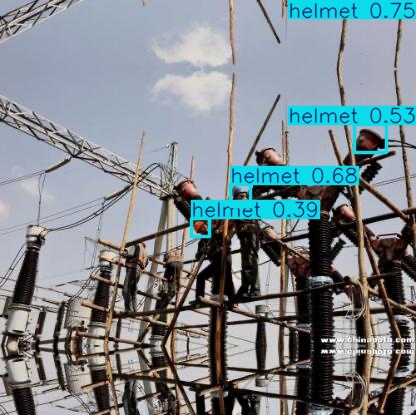

/content/runs/detect/yolov8n_seed42_val_preds/hard_hat_workers1954.jpg


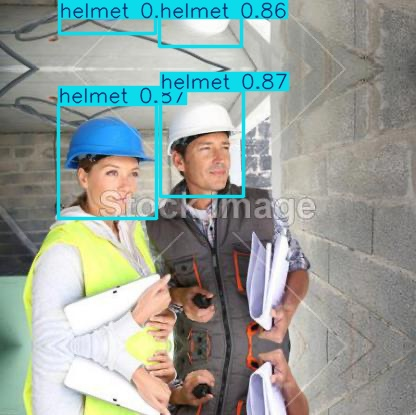

/content/runs/detect/yolov8n_seed42_val_preds/hard_hat_workers3155.jpg


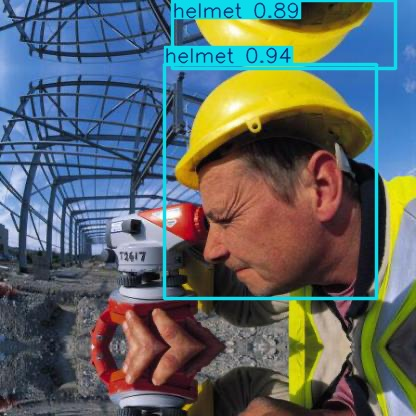

/content/runs/detect/yolov8n_seed42_val_preds/hard_hat_workers4378.jpg


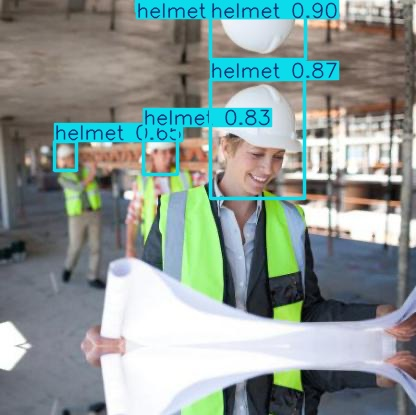

/content/runs/detect/yolov8n_seed42_val_preds/hard_hat_workers1604.jpg


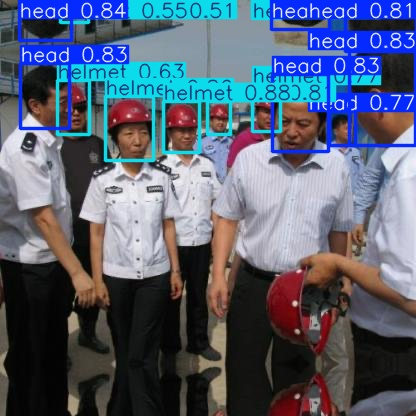

/content/runs/detect/yolov8n_seed42_val_preds/hard_hat_workers2845.jpg


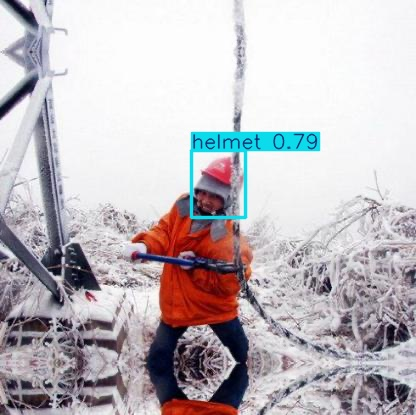

/content/runs/detect/yolov8n_seed42_val_preds/hard_hat_workers534.jpg


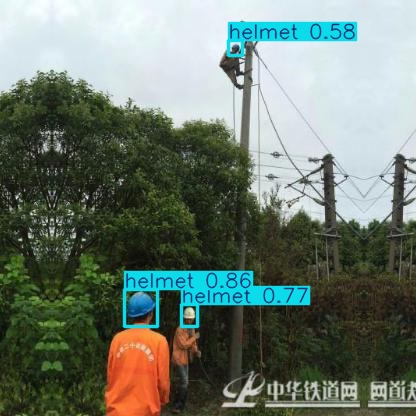

/content/runs/detect/yolov8n_seed42_val_preds/hard_hat_workers3775.jpg


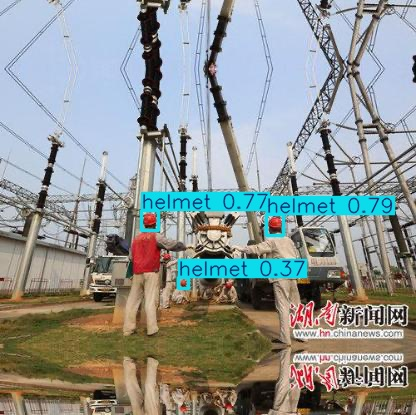

/content/runs/detect/yolov8n_seed42_val_preds/hard_hat_workers3408.jpg


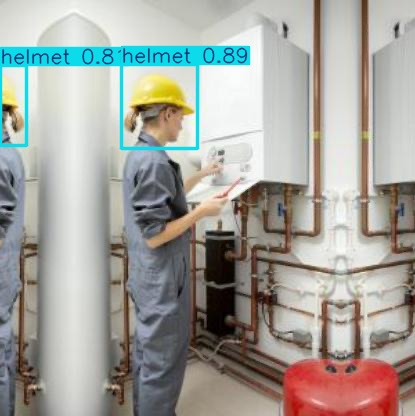

/content/runs/detect/yolov8n_seed42_val_preds/hard_hat_workers2401.jpg


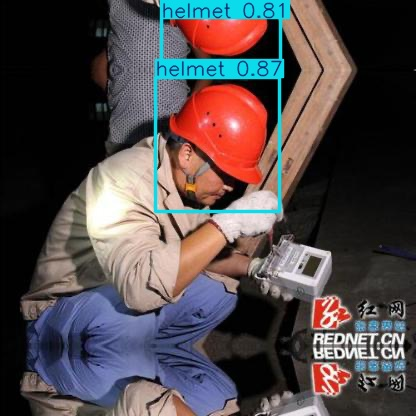

/content/runs/detect/yolov8n_seed42_val_preds/hard_hat_workers4036.jpg


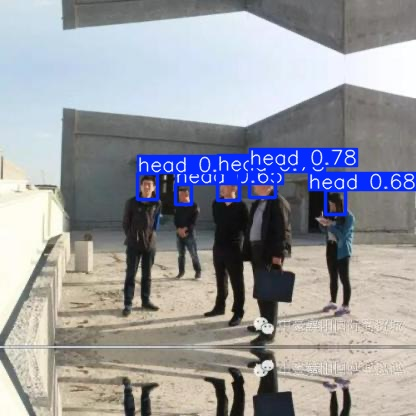

/content/runs/detect/yolov8n_seed42_val_preds/hard_hat_workers1617.jpg


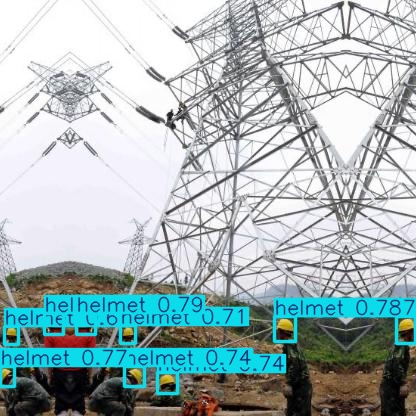

In [ ]:
import glob, random
from IPython.display import Image, display

pred_dir = "/content/runs/detect/yolov8n_seed42_val_preds"
imgs = glob.glob(pred_dir + "/*.jpg")

print(f"Found {len(imgs)} prediction images")

# show 12 random examples
for img_path in random.sample(imgs, 12):
    print(img_path)
    display(Image(filename=img_path, width=800))

In [ ]:
!cp -r /content/runs/detect/yolov8n_seed42_reval_clean \
      /content/drive/MyDrive/CS6436_project/hardhat_hh_2class/

!cp -r /content/runs/detect/yolov8n_seed42_val_preds \
      /content/drive/MyDrive/CS6436_project/hardhat_hh_2class/

# Pre-DEMO

In [ ]:
from ultralytics import YOLO
import torch
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import cv2

device = "cuda" if torch.cuda.is_available() else "cpu"

# Paths (adjust to your actual structure)
project_root = Path("/content/drive/MyDrive/CS6436_project")
data_root = Path("/content/hardhat_yolo_data/hardhat_yolo_data")
val_images_dir = data_root / "val" / "images"

# Model weights
yolo_n_weights = project_root / "hardhat_hh_2class/yolov8n_seed0/weights/best.pt"
yolo_s_weights = project_root / "hardhat_hh_2class/yolov8s_seed0/weights/best.pt"
frcnn_ckpt     = project_root / "models/fasterrcnn_seed0_best.pth"

# Prediction JSONs and fused JSONs
preds_n_json   = project_root / "preds_yolov8n_seed0_val.json"
preds_s_json   = project_root / "preds_yolov8s_seed0_val.json"
preds_f_json   = project_root / "preds_frcnn_seed0_val.json"
preds_wbf_ns   = project_root / "preds_wbf_yolov8n_yolov8s_val.json"
preds_wbf_nsf  = project_root / "preds_wbf_yolov8n_yolov8s_frcnn_val.json"
preds_mv_nsf   = project_root / "preds_majority_yolov8n_yolov8s_frcnn_val.json"

In [ ]:
yolo_n = YOLO(str(yolo_n_weights))
yolo_s = YOLO(str(yolo_s_weights))

yolo_n.to(device)
yolo_s.to(device)

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_s

In [ ]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def load_frcnn_model(ckpt_path):
    num_classes = 3  # background + head + helmet
    model = fasterrcnn_resnet50_fpn(weights="DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt)
    model.to(device)
    model.eval()
    return model

frcnn = load_frcnn_model(frcnn_ckpt)

/tmp/ipython-input-2196254651.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=device)


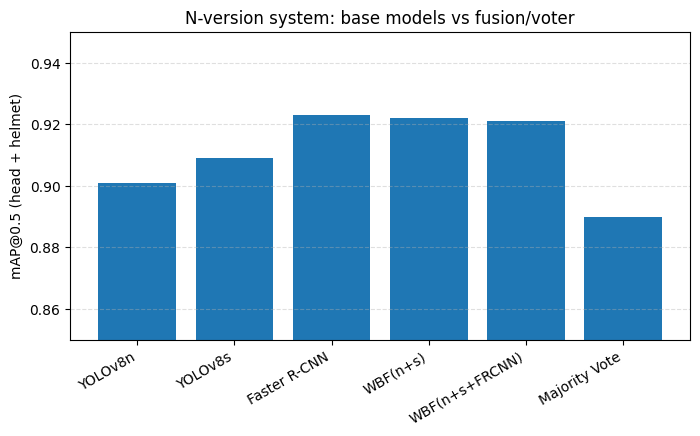

In [ ]:
methods = [
    "YOLOv8n",
    "YOLOv8s",
    "Faster R-CNN",
    "WBF(n+s)",
    "WBF(n+s+FRCNN)",
    "Majority Vote"
]

map50 = [
    0.901,  # YOLOv8n_seed0_clean
    0.909,  # YOLOv8s_seed0_clean
    0.923,  # FRCNN_seed0
    0.922,  # WBF(n+s)
    0.921,  # WBF(n+s+FRCNN)
    0.890   # MajorityVote(n,s,frcnn)
]

plt.figure(figsize=(8,4))
plt.bar(methods, map50)
plt.xticks(rotation=30, ha="right")
plt.ylabel("mAP@0.5 (head + helmet)")
plt.title("N-version system: base models vs fusion/voter")
plt.ylim(0.85, 0.95)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()

In [ ]:
example_img = val_images_dir / "hard_hat_workers0.png"  # or any that looks nice
print(example_img)

/content/hardhat_yolo_data/hardhat_yolo_data/val/images/hard_hat_workers0.png


In [ ]:
def show_yolo_result(model, img_path, title):
    res = model(str(img_path), verbose=False, device=0 if device=="cuda" else None)[0]
    im = res.plot()  # numpy BGR image
    im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im_rgb)
    plt.axis("off")
    plt.title(title)

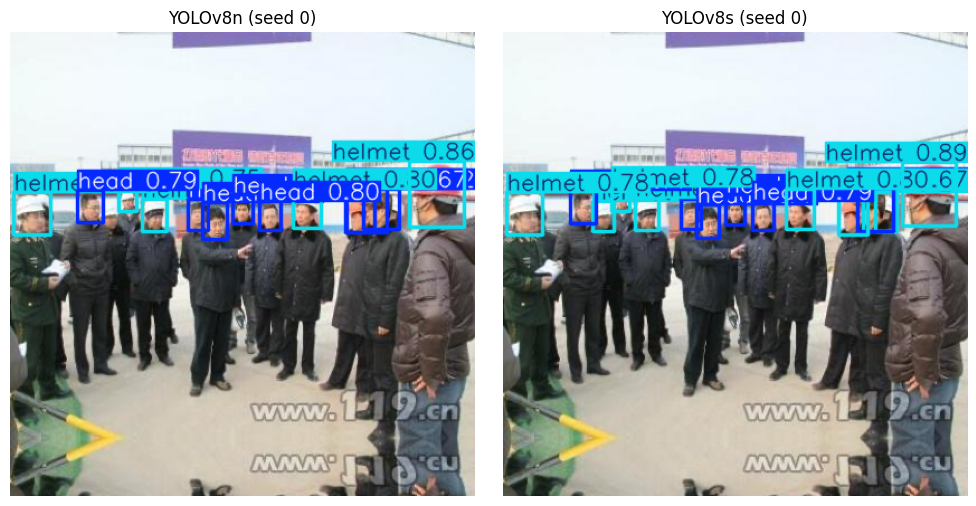

In [ ]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
show_yolo_result(yolo_n, example_img, "YOLOv8n (seed 0)")

plt.subplot(1,2,2)
show_yolo_result(yolo_s, example_img, "YOLOv8s (seed 0)")

plt.tight_layout()
plt.show()

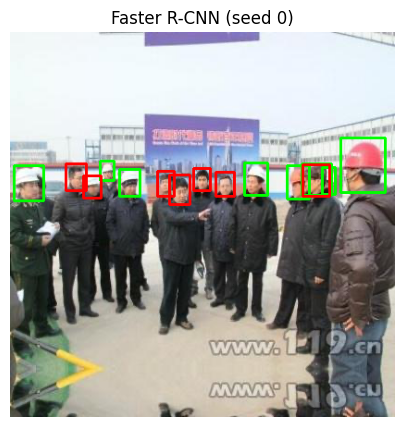

In [ ]:
from torchvision.transforms.functional import to_tensor

def frcnn_predict_boxes(model, img_path, score_thr=0.5):
    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    tensor = to_tensor(img_rgb).to(device)
    with torch.no_grad():
        out = model([tensor])[0]
    boxes = out["boxes"].cpu().numpy()
    scores = out["scores"].cpu().numpy()
    labels = out["labels"].cpu().numpy()  # 1=head, 2=helmet
    sel = scores >= score_thr
    return img_rgb, boxes[sel], scores[sel], labels[sel]

def draw_frcnn_boxes(img_rgb, boxes, labels, title):
    img_copy = img_rgb.copy()
    for box, lab in zip(boxes, labels):
        x1, y1, x2, y2 = box.astype(int)
        color = (0,255,0) if lab == 2 else (255,0,0)  # helmet=green, head=red
        cv2.rectangle(img_copy, (x1,y1), (x2,y2), color, 2)
    plt.imshow(img_copy)
    plt.axis("off")
    plt.title(title)

img_rgb, boxes_f, scores_f, labels_f = frcnn_predict_boxes(frcnn, example_img, score_thr=0.5)

plt.figure(figsize=(5,5))
draw_frcnn_boxes(img_rgb, boxes_f, labels_f, "Faster R-CNN (seed 0)")
plt.show()

 **Same image, fusion & majority**

In [ ]:
def load_per_image_preds(json_path):
    data = json.load(open(json_path, "r"))
    # build a dict: stem -> record
    return {rec["image_id"]: rec for rec in data}

g_wbf_ns  = load_per_image_preds(preds_wbf_ns)
g_wbf_nsf = load_per_image_preds(preds_wbf_nsf)
g_mv_nsf  = load_per_image_preds(preds_mv_nsf)

In [ ]:
def draw_normalized_boxes_on_image(img_path, rec, title, score_thr=0.3):
    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img_rgb.shape

    boxes = np.array(rec["boxes"])
    scores = np.array(rec["scores"])
    labels = np.array(rec["labels"])

    keep = scores >= score_thr
    boxes = boxes[keep]
    labels = labels[keep]

    img_copy = img_rgb.copy()
    for box, lab in zip(boxes, labels):
        x1 = int(box[0] * w)
        y1 = int(box[1] * h)
        x2 = int(box[2] * w)
        y2 = int(box[3] * h)
        color = (0,255,0) if lab == 1 else (255,0,0)  # 1=helmet, 0=head
        cv2.rectangle(img_copy, (x1,y1), (x2,y2), color, 2)
    plt.imshow(img_copy)
    plt.axis("off")
    plt.title(title)

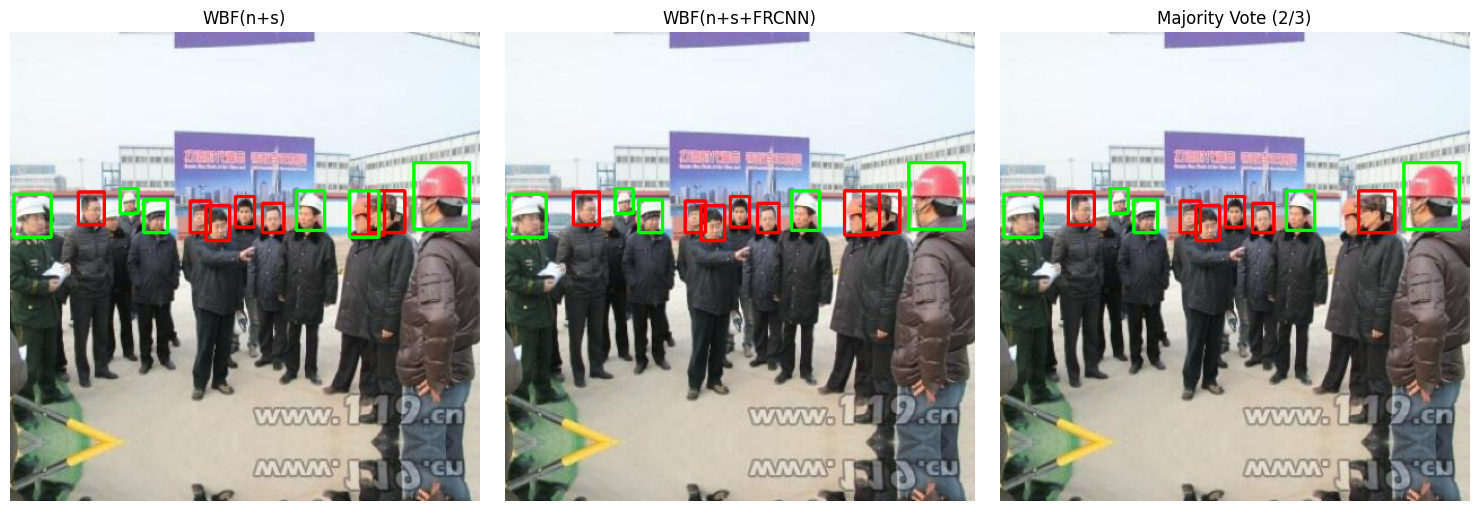

In [ ]:
stem = example_img.stem
wbf_ns_rec  = g_wbf_ns[stem]
wbf_nsf_rec = g_wbf_nsf[stem]
mv_nsf_rec  = g_mv_nsf[stem]

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
draw_normalized_boxes_on_image(example_img, wbf_ns_rec, "WBF(n+s)")

plt.subplot(1,3,2)
draw_normalized_boxes_on_image(example_img, wbf_nsf_rec, "WBF(n+s+FRCNN)")

plt.subplot(1,3,3)
draw_normalized_boxes_on_image(example_img, mv_nsf_rec, "Majority Vote (2/3)")

plt.tight_layout()
plt.show()

# Safety interpretation on a “no-helmet” head

In [ ]:
ppe_img = val_images_dir / "hard_hat_workers0.png"

Majority Vote detections: heads = 6 helmets = 5


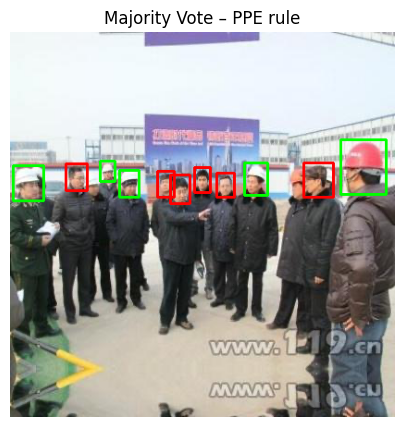

In [ ]:
stem = ppe_img.stem
ppe_mv_rec = g_mv_nsf[stem]

# simple count
labels = np.array(ppe_mv_rec["labels"])
num_heads = (labels == 0).sum()
num_helmets = (labels == 1).sum()
print("Majority Vote detections: heads =", num_heads, "helmets =", num_helmets)

plt.figure(figsize=(5,5))
draw_normalized_boxes_on_image(ppe_img, ppe_mv_rec, "Majority Vote – PPE rule")
plt.show()